# Full script to analyse Food and You survey data

It focuses on:
- Processing of survey and census data
- Demographic comparison of survey data vs census data
- Food-related behaviours associated to individual demographic groups within the survey

Import all relevant libraries here 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.stats.proportion as smp
from matplotlib.backends.backend_pdf import PdfPages
from ipywidgets import interact

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from scipy.stats import chi2_contingency
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

import statsmodels.stats.api as sms
import scipy.stats as st
from scipy.stats import sem, t

from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

import warnings
warnings.filterwarnings('ignore')

# pandas version should be at least 1.0.3

# Define where in data can be found, either in web or local machine:
 <span style="color:blue">(user input required)</span>

Either
- load everything from the raw files provided in readme
- load the processed files provided in the data folder


In [19]:
# Appropiate paths need to be indicated below

survey_path = 'https://raw.githubusercontent.com/lorena-gp/food-standards-agency/master/data/survey.csv'

questions_dict_path = 'https://raw.githubusercontent.com/lorena-gp/food-standards-agency/master/data/survey_guide_variables.csv'
answers_dict_path = 'https://raw.githubusercontent.com/lorena-gp/food-standards-agency/master/data/survey_guide_values.csv'

# census_path = 'insert_your_own_path/microdata_census2011_wales.xlsx' # needs to be changed before use

census_prepared_path = 'https://raw.githubusercontent.com/lorena-gp/food-standards-agency/master/data/microdata_census2011_Wales_prepared.csv'

## Custom dictionaries 

Dictionaries to rename values and variables to comprehensible and meaningful names

    questions_dict - applies to all questions
    answers_dict - applies to all answers

In [3]:
# Create a dictionary of question names
questions_dict = pd.read_csv(questions_dict_path)
questions_dict['Label'] = questions_dict['Label'].str.replace(r'\(D\)','')
questions_dict = pd.Series(questions_dict.Label.values, index=questions_dict.Variable).to_dict()

# Create a nested dictionary of answer names
answers_dict = pd.read_csv(answers_dict_path)
answers_dict['Label'] = (answers_dict['Label']
                         .replace({'Wave 1':2010, 'Wave 2':2012, 'Wave 3':2014, 'Wave 4':2016, 'Wave 5':2018})
                         .replace({'Married/Civil Partnership/Living with Partner':'Married/Partnership'})
                         .replace({'Single/Widowed/Divorced/Separated/Other':'Single/Other'}))
answers_dict = answers_dict.fillna(method='ffill')
answers_dict = answers_dict.groupby('Variable')[['Vlue', 'Label']].apply(lambda g: dict(g.values)).to_dict()
answers_dict['wimd_2014_quintile'] = {1: 1, 2: 2, # 1 is most deprived
                                      3: 3, 4: 4, 5: 5, # 5 is least deprived
                                      -8: "Don't know", -1:'Not applicable'}
answers_dict['hhdinc'] = {1: '£10,399 or less', 2: '£10,400 - £25,999', 3: '£26,000 - £51,999', 4:'£52,000 or more',
                          -9:'Refused', -8: "Don't know", -1:'Not applicable'}

## Questions of interest relating to food behaviour in survey 
 <span style="color:blue">(user input required)</span>

In [4]:
# Define questions of interest
questions_of_interest_withRiskRating = ['bpoison', 'Q4_1_5_comb', 'eatoutev', 'q4_1_6', 'Q4_1_5_comb', 'Q4_19b', 'fdsecst',
                         'sanspray', 'Q4_26b', 'q4_1_8a', 'q4_1_11', 'dq4_1bc', 'Q4_143', 'safemeat10',
                         'Q4_2610', 'q4_27_4_slice', 'Q4_27c', 'Q4_28b8', 'q2_14s10a_dv', 'q2_14su8b_dv',
                         'q2_14su7a_dv', 'q2_14s13_dv', 'EatOut1', 'EatOut2', 'EatOut3']

# Define high risk answers to questions of interest (in same order)
high_risk_answers = [1,1,1,4,4,4,4,1,1,1,1,2,1,1,1,5,2,1,4,4,4,4,1,1,1]
question_risk_aswers = pd.DataFrame(
    {'question': questions_of_interest_withRiskRating,
     'high_risk_answer': high_risk_answers
    })

questions_high_correlation = ['clinaller', 'FdAuthAct_MC9', 'chemknow3', 'Q3_32', 'Q4_1b1', 'safeegg7', 'chemknow2',
                              'q2_14s15_dv', 'EatOutInfDV_Wb', 'chemiop3', 'Q4_1b4',  'Q4_24', 'provfd1', 'Q3_1312',
                              'Q3_135', 'chemknow4', 'q2_14s10_dv', 'Q4_266', 'q2_14su8a_dv', 'Q11_8bDV17',
                              'chemiop2', 'Q11_8bDV2', 'FdAuthAct_MC2', 'Q3_137', 'Q4_114', 'Worried', 'Q11_8bDV12',
                              'q4_1_15', 'chemiop1', 'q4_277dv', 'fdreac_dv','chemknow1', 'FdAuthAct_MC6',
                              'Q2_38DV5', 'Q4_115', 'reacno', 'heardorgc9', 'Q4_113', 'Q11_8bDV10', 'safefish5',
                              'EatOutInfDV_Ad', 'safeegg14', 'Q2_19', 'Q2_35DV_Pr', 'Q4_2611', 'q4_276dv', 'Q4_2610',
                              'q4_277_dv', 'Q4_143', 'Q11_8bDV6', 'heardorgc6', 'q4_276_dv', 'q2_14su7_dv', 'Q4_151',
                              'safecheese5', 'safecheese2', 'Q4_227']
# hhdinc, age_dv were already marked as question of interest

questions_of_interest = questions_of_interest_withRiskRating + questions_high_correlation

# Other questions that are the output of a correlation analysis 
# questions_of_interest = ['h2_28mb', 'H2_407', 'H2_42', 'H2_406', 'ovcorre', 'H2_404', 'H2_401',
#                        'h2_53_dv', 'h2_46_dv', 'h2_43_dv', 'totcon', 'h2_45_dv', 'h2_27mb', 'h2_42_dv']


#q2_14s10a_dv, q2_14su8b_dv, q2_14su7a_dv, q2_14s13_dv: multiple high_risk answers: 1-7
#EatOut3 problem is that the question with its answers is doubleD!!

## Custom functions for data visualization

Custom function for creating grouped barplots of the variables of interest and save the output

In [5]:
# Custom function for creating grouped barplots of the variables of interest and save the output

def custom_barplots(dataset, # dataframe
                    groupping, # string
                    variables_of_interest, # list of string(s)
                    title_of_output='example.pdf', # string
                    barwidth=0.5, myspacingy=0.09, myspacingx=8, myfontsize=17,
                    high_risk_option = 'no', interactivity = 'no'):
    
    pdf = PdfPages(title_of_output)
    figures = []
    
    row = 0
    
    for variable in variables_of_interest:

        temp = dataset.copy()

        # Group according to the features of interest and calculate the % of answer types for the main target feature
        temp = temp.groupby([groupping, variable])[variable].agg(['count'])
        temp['total'] = temp.groupby(groupping)['count'].transform('sum')
        lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
        temp['CI_prop_upper'] = upper
        temp['CI_prop_lower'] = lower
        temp[variable + ' (%)'] = temp['count'] / temp['total'] * 100
        temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
        temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
        temp['abs_err'] = temp[variable + ' (%)'] - temp['CI_perc_lower']
        temp.reset_index(inplace=True) # To 'undo' the grouping
        temp = temp.round(1)
        temp
        
        high_risk_option_chosen = high_risk_option
        if high_risk_option_chosen == 'yes':
            high_risk_answer = question_risk_aswers.loc[row, 'high_risk_answer']
            temp = temp[temp[variable] == high_risk_answer]
            row += 1
    
        # Recode the answers of those variables we want to use to stratify the population
        answers_to_rename = [variable]
        temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict)

        abs_err = temp.pivot(index=variable, columns=groupping, values='abs_err')

        g = temp.pivot(index=variable, columns=groupping, values=variable+' (%)')\
        .plot(kind='barh', xerr=abs_err, width=barwidth, figsize=(3,10), colormap='coolwarm')
        for item in ([g.title, g.xaxis.label, g.yaxis.label] + g.get_xticklabels() + g.get_yticklabels()):
            item.set_fontsize(20)
        plt.title(questions_dict.get(variable), x =0,  fontsize = 20)
        plt.xlabel(variable + ' (%)')
        plt.ylabel('')
        plt.xlim(0, max(temp[variable +' (%)'] + 15))
        handles, labels = g.get_legend_handles_labels()
        g.legend(reversed(handles), reversed(labels), loc='center left', bbox_to_anchor=(1.5, 0.75), fontsize=16)
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        g.spines['left'].set_visible(False)

        # To plot the % number
        for p in g.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            g.annotate('{:}%'.format(width), (x + width + myspacingx, y + myspacingy), fontsize = myfontsize)
            # play with fontsize, depending on graph

        #plt.show()
        
        figures += [g.figure]
    
    if interactivity == 'no':
        for figure in figures:
            pdf.savefig(figure, bbox_inches='tight') # output file is saved in the same folder as this notebook
        pdf.close()

Custom functions for creating temporal line plots

In [6]:
# Custom functions for cleating temporal line plots

# The following function specifies the % number on top and the count number below.
def custom_lineplots(x,y,z, **kwargs):
    ax = sns.lineplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(y.values[i]) + '%', xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')
    for i in range(len(x)):
        ax.annotate('n=' + str(z.values[i]), xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,-10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')

# Wrapper function for plt.errorbar
def errorbar(x, y, low, high,  color, **kws):
    plt.errorbar(x, y, (y - low, high - y), color=color)

# Complete lineplot function
def custom_lineplots_complete(dataset, # dataframe
                              variables_of_interest, # list of string(s)
                              title_of_output): # string
    
    pdf = PdfPages(title_of_output)
    figures = []

    for variable in variables_of_interest:
    
        temp = dataset[[variable] + ['country_dv', 'surveyyear']]

        # Group according to the features of interest and calculate the % of answer types for the main target feature
        temp = temp.groupby(['country_dv','surveyyear', variable])[variable].agg(['count'])
        temp['total'] = temp.groupby(['country_dv','surveyyear'])['count'].transform('sum')
        lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
        temp['CI_prop_upper'] = upper
        temp['CI_prop_lower'] = lower
        temp[variable + ' (%)'] = temp['count'] / temp['total'] * 100
        temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
        temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
        temp.reset_index(inplace=True) # To 'undo' the grouping
        temp = temp.round(1)

        # Recode the answers of those variables we want to use to stratify the population
        answers_to_rename = ['country_dv', variable, 'surveyyear']
        temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict) # pandas 1.0.3 (or newer) needed for nested replace

        # Plot features of interest from the created 'temp' subset
        g = sns.FacetGrid(temp, col='country_dv', hue=variable, height=4, aspect=1) 
        g.map(errorbar, 'surveyyear', variable + ' (%)', 'CI_perc_lower', 'CI_perc_upper')
        g = (g.map(custom_lineplots, 'surveyyear', variable + ' (%)', 'count')
             .add_legend())
        plt.xlim(2009, 2019)
        g.set_titles('{col_name}', pad = 25)
        plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.75)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True, labelleft=True)
        plt.figtext(.5,.9, questions_dict.get(variable), fontsize=12, ha='center')

        figures += [g.fig]

    for figure in figures:
        pdf.savefig(figure)
    pdf.close()

## Loading and processing the Food and You survey data

In [7]:
# Load Food and You survey dataset

survey_full_dataset = pd.read_csv(survey_path)
survey_full_dataset = pd.DataFrame(survey_full_dataset)

# Encode 'Not applicable', 'Refused' and 'Don't know' as NaN
survey_full_dataset = survey_full_dataset.replace([-9, -8, -1, 98], np.nan)
cols_5_NaN = ['q4_1_4', 'q4_1_5a', 'Q4_1_5_comb', 'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_8b', 'sanspray', 'q4_1_11',
              'q4_1_12', 'q4_1_13', 'q4_1_14', 'q4_1_15', 'q4_1_16', 'q4_1_17', 'q4_1_18', 'q4_1_19']
survey_full_dataset[cols_5_NaN] = survey_full_dataset[cols_5_NaN].replace([5], np.nan)

# group ages according to age bracket: underrep 1, wellrep 2,3&4, overrep 5,6&7
survey_full_dataset['age_dv_grouped'] = (survey_full_dataset['age_dv']
                                         .replace({1:'A', 2:'B', 3:'B', 4:'B', 5:'C', 6:'C', 7:'C'})
                                         .replace({'A':'16-24', 'B':'25-54', 'C':'55+'}))

## Loading and processing census 2011 data 
- Can take up to 20 min to fully load the datasets. Then re-structure census dataset to share colnames and values as in survey dataset
- <span style="color:red">Alternatively, the next 2 sections can be skipped if using census_prepared_path</span>



In [ ]:
# !! Can be skipped if using census_prepared_path

# Load census 2011 file - includes Wales and England
census_full_dataset = pd.read_excel(census_path)
census_full_dataset = pd.DataFrame(census_full_dataset)

# Keep only Wales data (encoded with no 2 in the 'country' column)
census_full_dataset = census_full_dataset[census_full_dataset.country == 2]

In [8]:
# Create new dataframe where we select only the data for demographics comparison
demographic_variables = ['age', 'marstat', 'religionew', 'sex', 'deprived', 'ecopuk',
                         'health']
census = census_full_dataset[demographic_variables]

# Set -9 values as NaN
census = census.replace (-9, np.nan)

# drop all rows with answers from people below 16 yo
age_out_of_range_index = census[(census['age'] < 16)].index
census.drop(age_out_of_range_index, inplace = True)

# group ages by age group 
census['age_dv'] = pd.cut(census.age, bins = [15,24,34,44,54,64,74,110], labels = [1,2,3,4,5,6,7])

# group ages according to age bracket: underrep 1, wellrep 2,3&4, overrep 5,6&7
census['age_dv_grouped'] = pd.cut(census.age, bins = [15,24,54,110], 
                                  labels = ['16-24','25-54','55+'])


# group marital status
census['marstat2'] = census['marstat'].replace({1:'A', 2:'B', 3:'B', 4:'A', 5:'A', 6:'A'}).replace({'B':1, 'A':2})

# group religion
census['religion_dv'] = (census['religionew']
                         .replace({1:'A', 2:'B', 3:'C', 4:'C', 5:'C', 6:'C', 7:'C', 8:'C',  9: np.nan})
                         .replace({'A':3, 'B':1, 'C':2}))

# group work status
census['workstat2'] = (census['ecopuk']
                       .replace({1:'A', 2:'A', 3:'A', 4:'A', 5:'A', 6:'A', 8:'A', 9:'A', 10:'A', 11:'A', 12:'B', 7:'C', 13:'C', 14:'C', 15:'C', 16:'C'})
                       .replace({'A':1, 'B':2, 'C':3}))

# deprivation index (reverse values)
census['wimd_2014_quintile'] = (census['deprived']
                                .replace({1:'A', 2:'B', 3:'C', 4:'D', 5:'E'})
                                .replace({'A':5, 'B':4, 'C':3, 'D':2, 'E':1}))

# health and sex
census = census.rename(columns={'health': 'Q6_1', 'sex': 'RespSex'})

# remove columns that are duplicates and not in the right format
census = census.drop(columns = ['age', 'marstat', 'religionew', 'ecopuk','deprived'])

<span style="color:red">Next cell should only be executed if prepared census want to be loaded directly</span>

In [8]:
# Read prepared census data
census = pd.read_csv(census_prepared_path)
census = pd.DataFrame(census)

# Join survey and census data
For demographics comparison only

In [9]:
# Define a list of demographic variables that are to be shared between the datasets
demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 
                         'wimd_2014_quintile', 'age_dv_grouped',
                         'workstat2', 'Q6_1']

In [10]:
# Join relevant survey data with the census data in a single dataframe

demographics_survey_and_census = survey_full_dataset[survey_full_dataset.country_dv.eq(2)] # Select Wales
demographics_survey_and_census = demographics_survey_and_census[demographic_variables]

# create new column to identify which rows come from survey and which from census
demographics_survey_and_census['source'] = 'survey'
census['source'] = 'census'

# add together the two dataframes 
demographics_survey_and_census = pd.concat([demographics_survey_and_census, census])


# Visualising the data

Individual .pdf with all plots are saved within the same folder this notebook is saved in

## Individual demographic variables: F&U vs Census

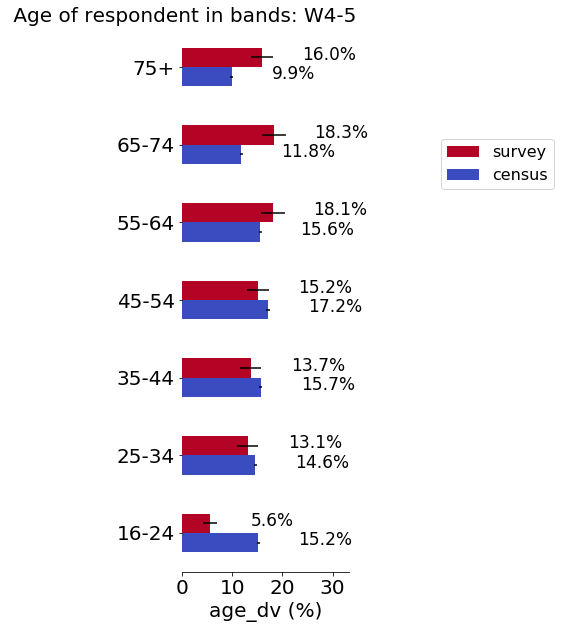

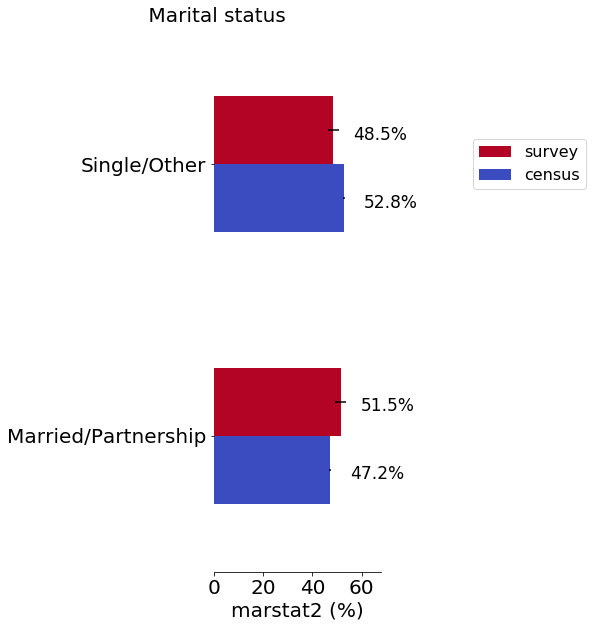

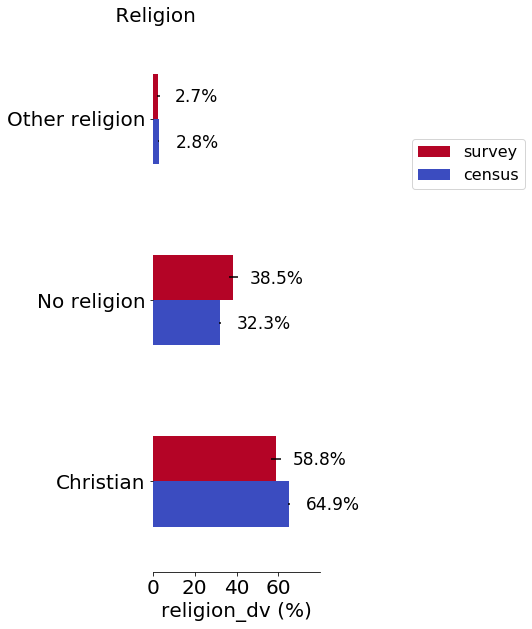

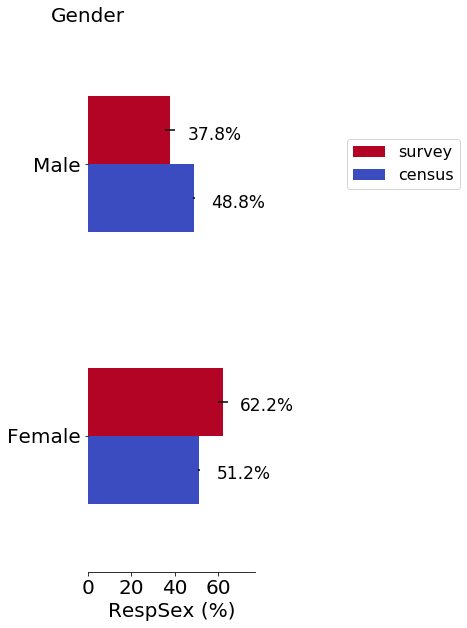

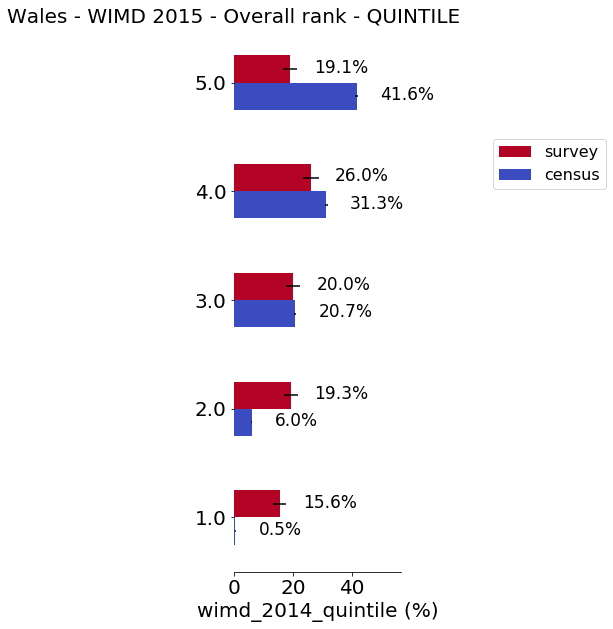

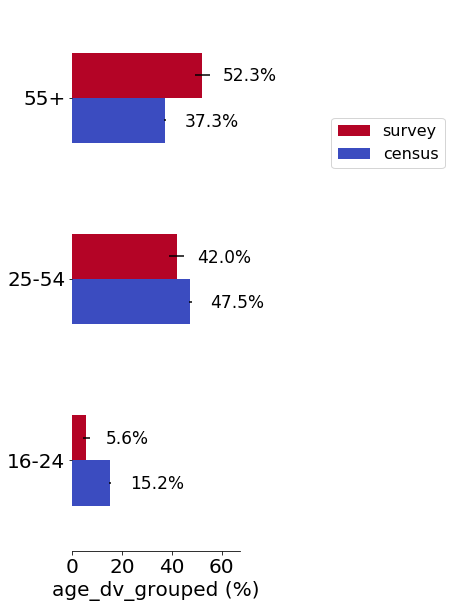

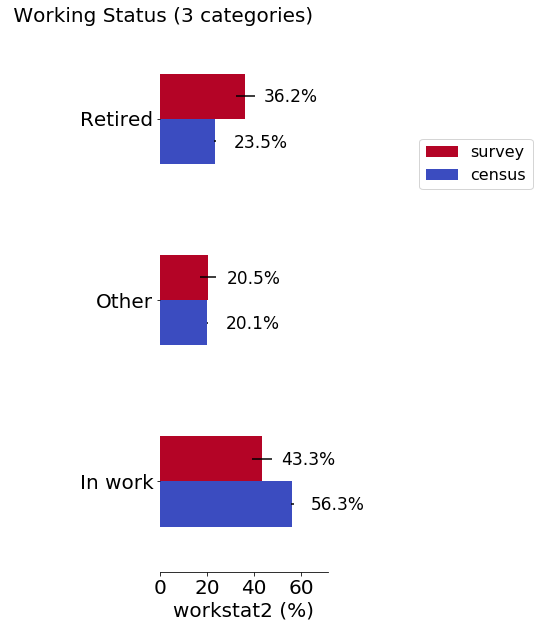

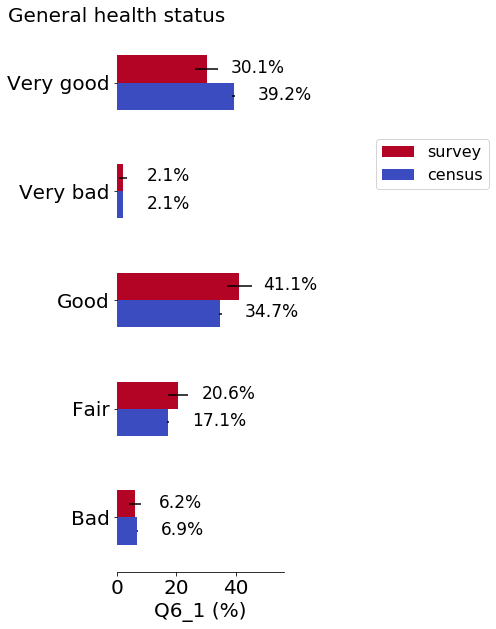

In [11]:
custom_barplots(demographics_survey_and_census,
                'source',
                demographic_variables,
                'survey_vs_census_demographics.pdf')

## Combined demographic variables: F&U vs Census

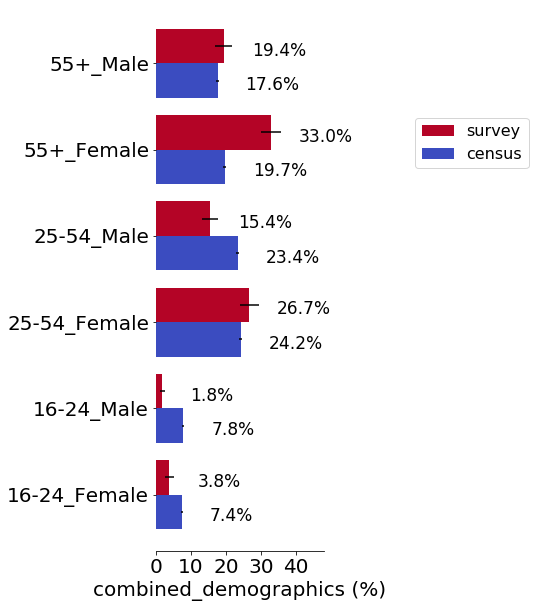

In [12]:
# Output is a single plot. Combination of demographic variables can be defined here

demographics_survey_and_census[demographic_variables] = demographics_survey_and_census[demographic_variables].replace(answers_dict)

demographics_survey_and_census['combined_demographics'] = (demographics_survey_and_census['age_dv_grouped'] + '_' +
                                                           demographics_survey_and_census['RespSex'])

custom_barplots(demographics_survey_and_census,
                'source',
                ['combined_demographics'],
                'survey_vs_census_combined-demographics.pdf',
                barwidth=0.8)

## Demographics by country and year: F&U

In [13]:
# More extensive list of demographic variables, for use with survey data only

demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 'wimd_2014_quintile', 'workstat2',
                         'Q6_1', 'age_dv_grouped', 'UrbanRuralInd', 'bhhsize2', 'hhdinc',
                         'below6', 'below16']

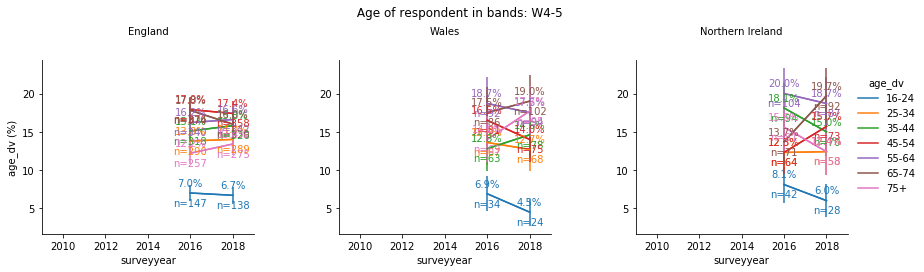

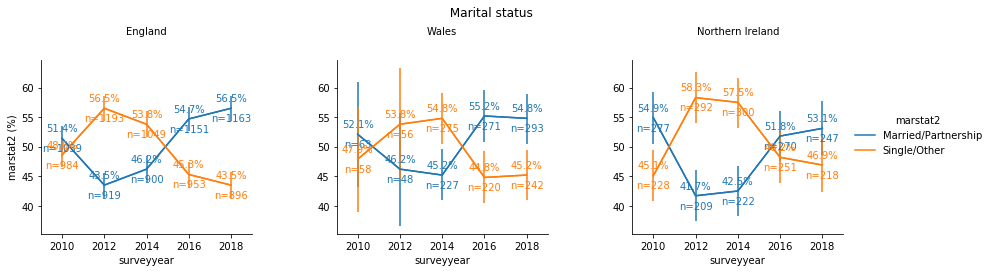

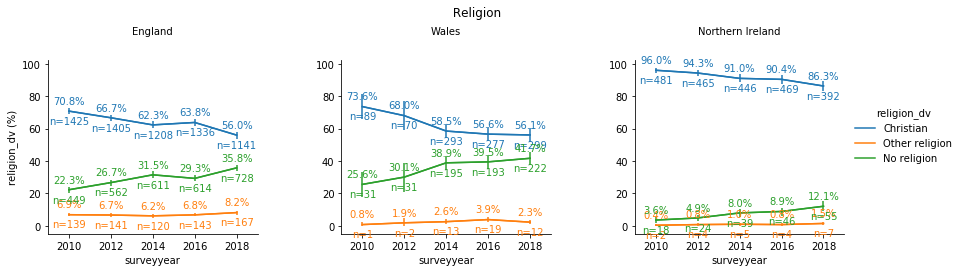

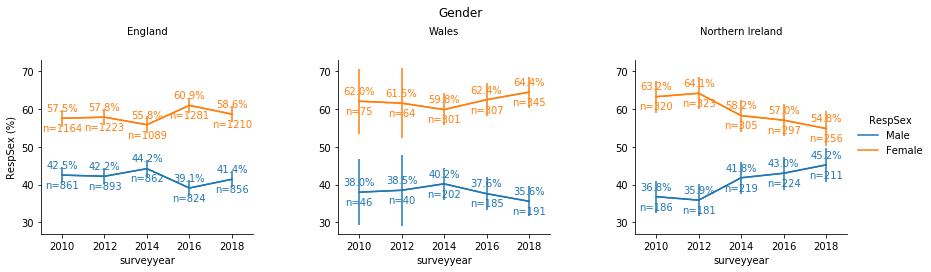

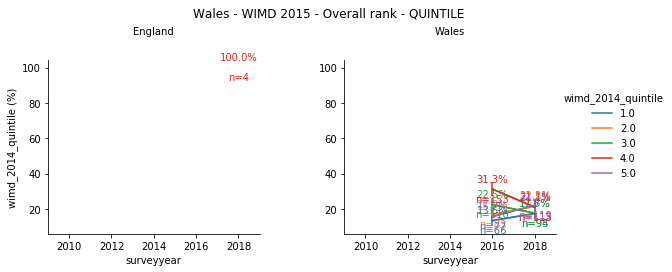

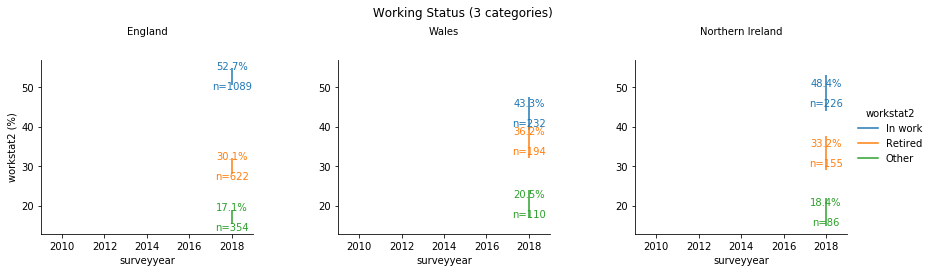

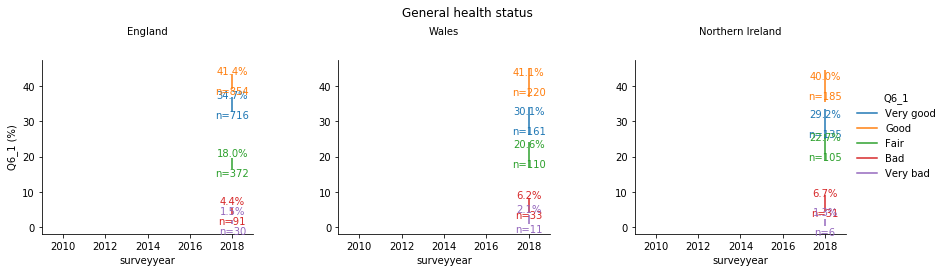

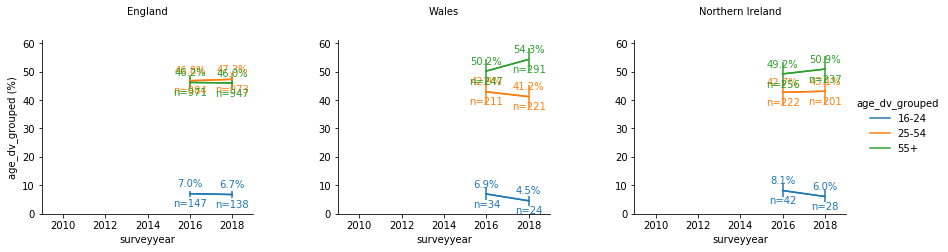

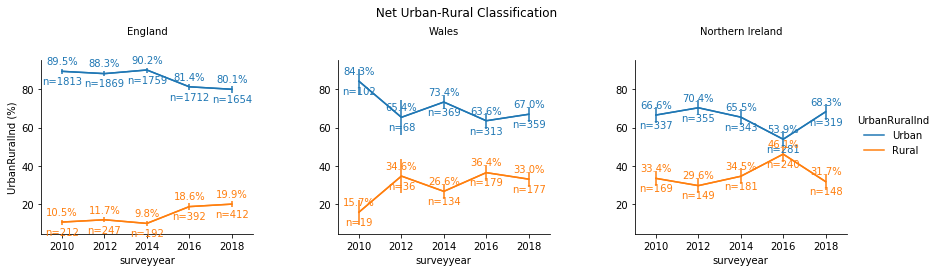

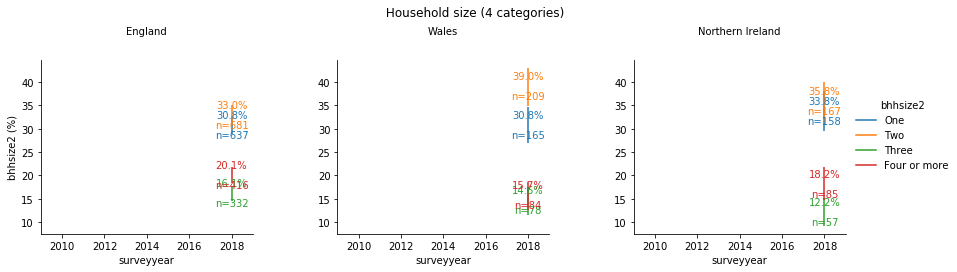

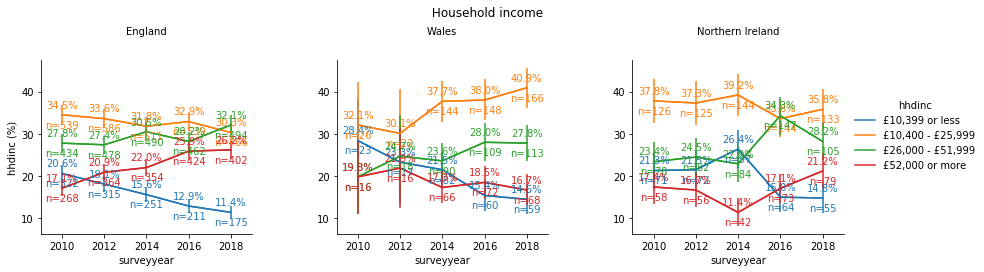

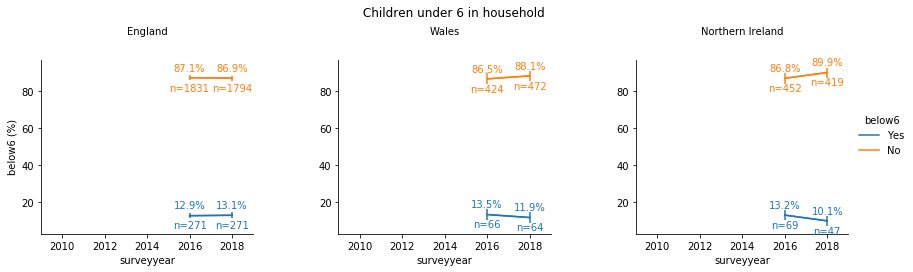

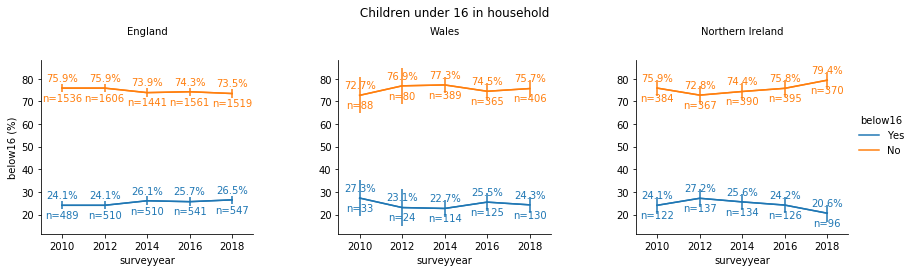

In [14]:
# Visualize temporal dynamic of demographic variables

custom_lineplots_complete(survey_full_dataset,
                          demographic_variables,
                          'survey_demographics_time.pdf')

## Food risk: F&U

Questions of interest were defined in list at the beginning of this notebook

### All answers to a given question

In [20]:
# To consider only the survey answers from wave 4 and 5 only:
waves = [4,5]
survey_subpopulation = survey_full_dataset.loc[survey_full_dataset['surveyyear'].isin(waves)]
survey_subpopulation[demographic_variables] = survey_subpopulation[demographic_variables].replace(answers_dict)

In [21]:
# How demographics are combined can be specified here (in this case, broad age and gender)
survey_subpopulation['combined_demographics'] = (survey_subpopulation['age_dv_grouped'] + '_' +
                                                survey_subpopulation['RespSex'])

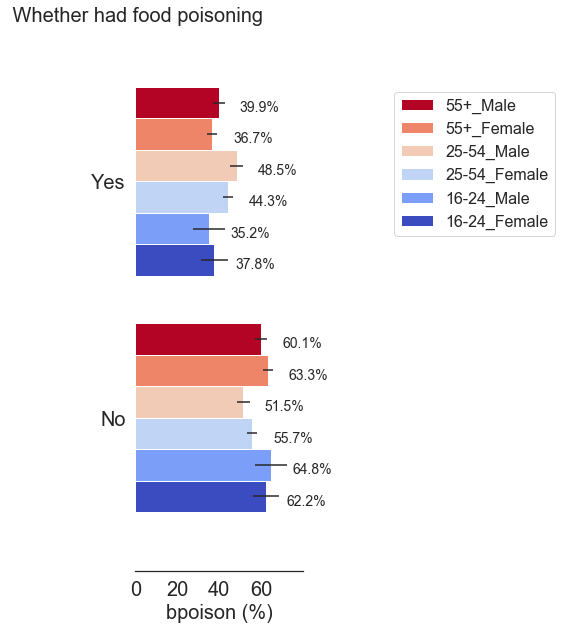

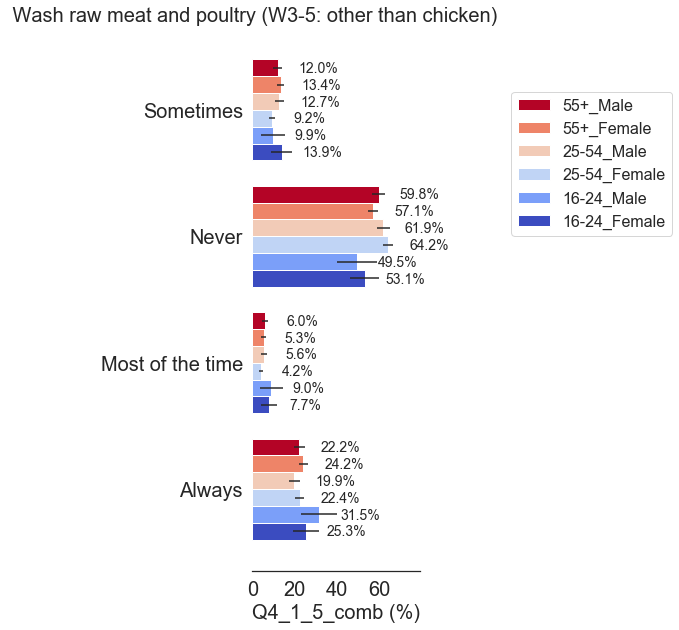

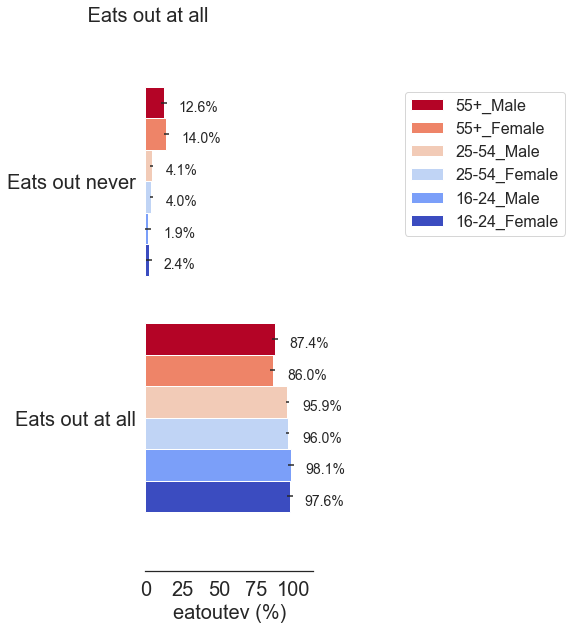

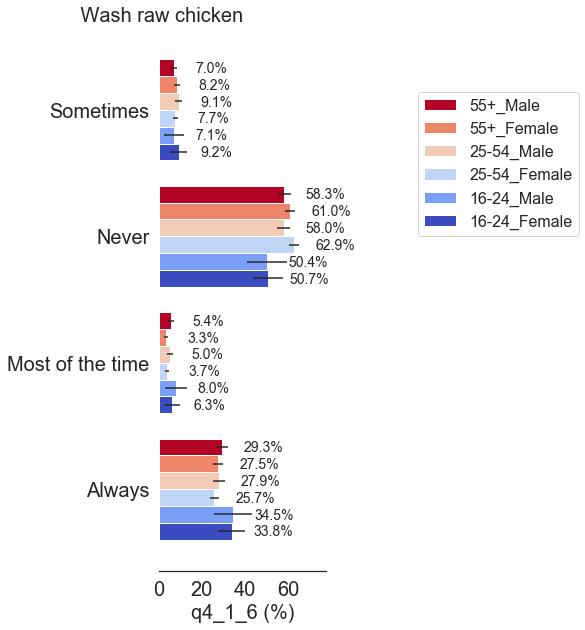

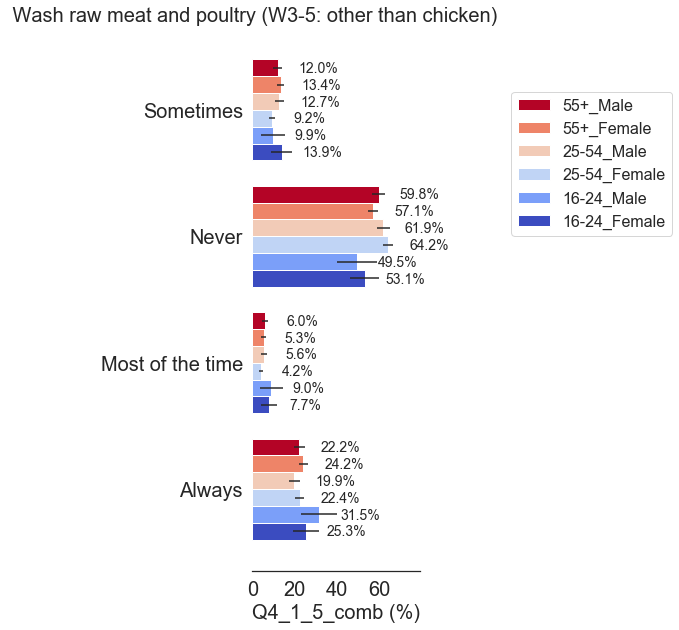

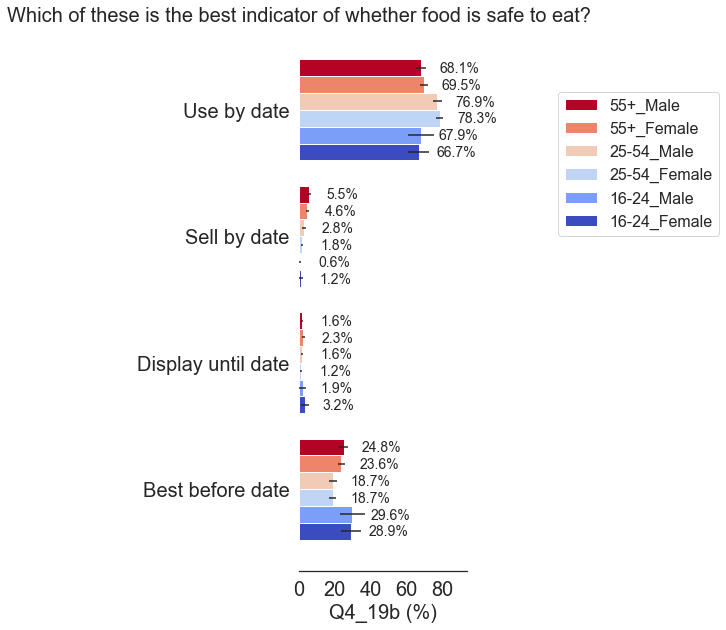

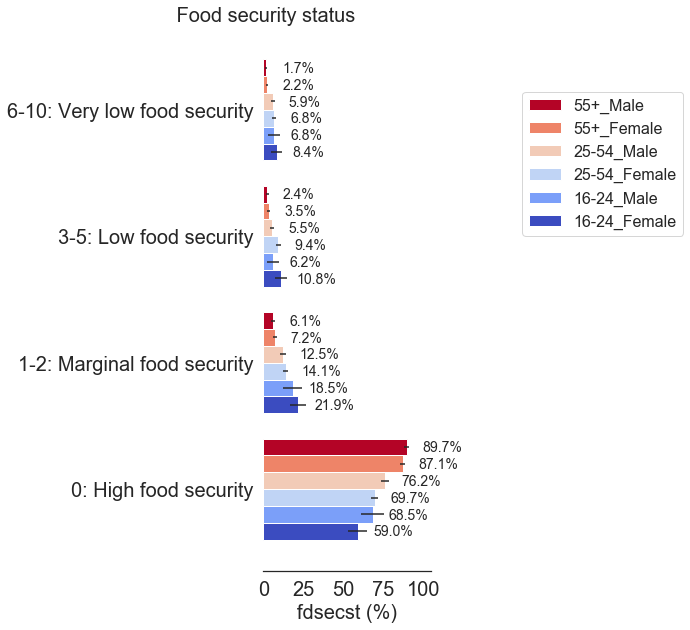

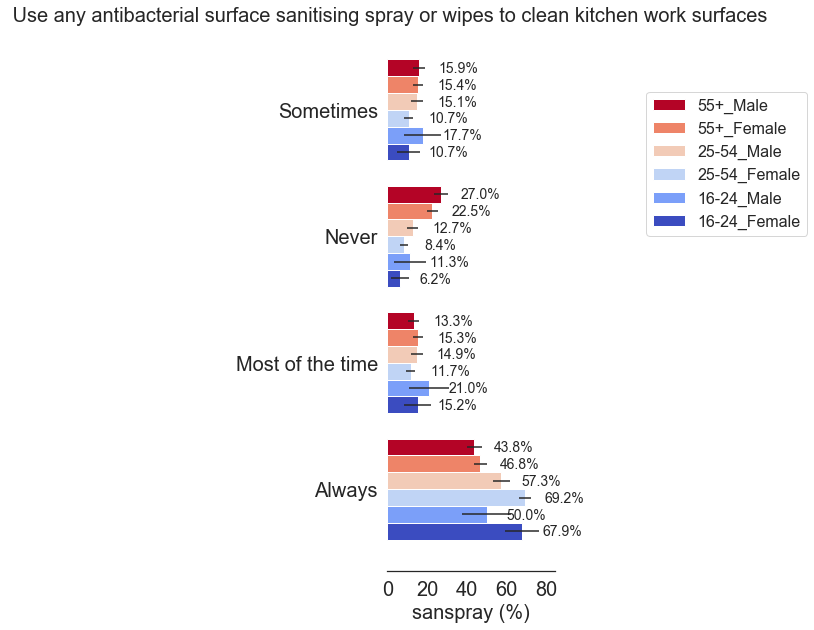

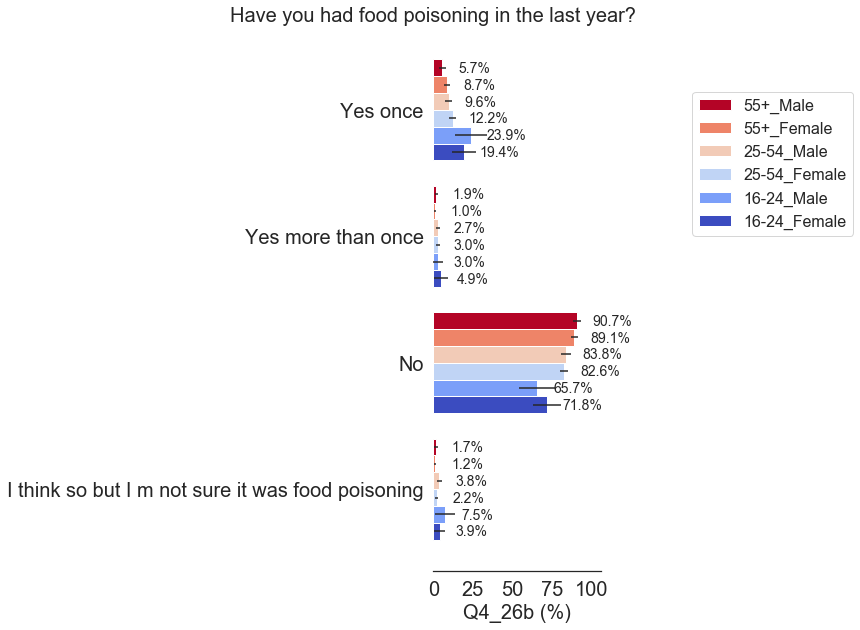

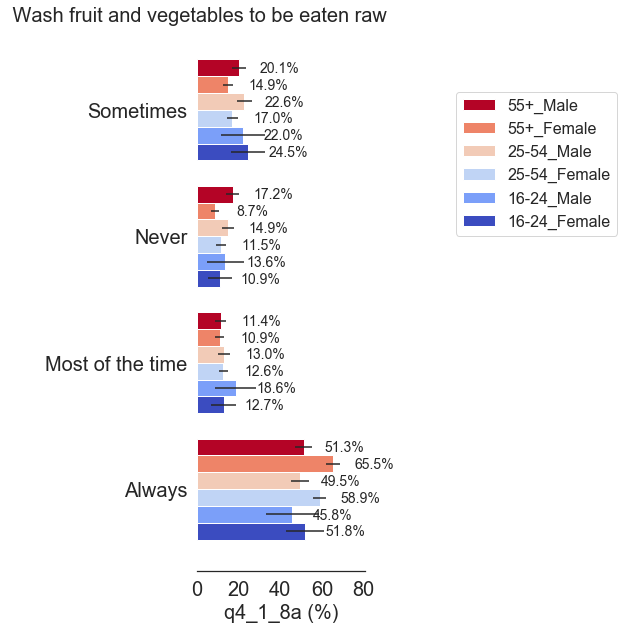

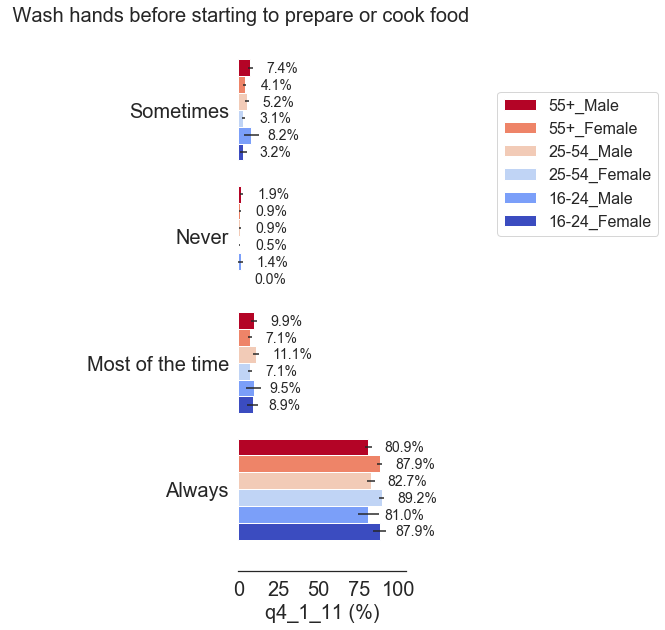

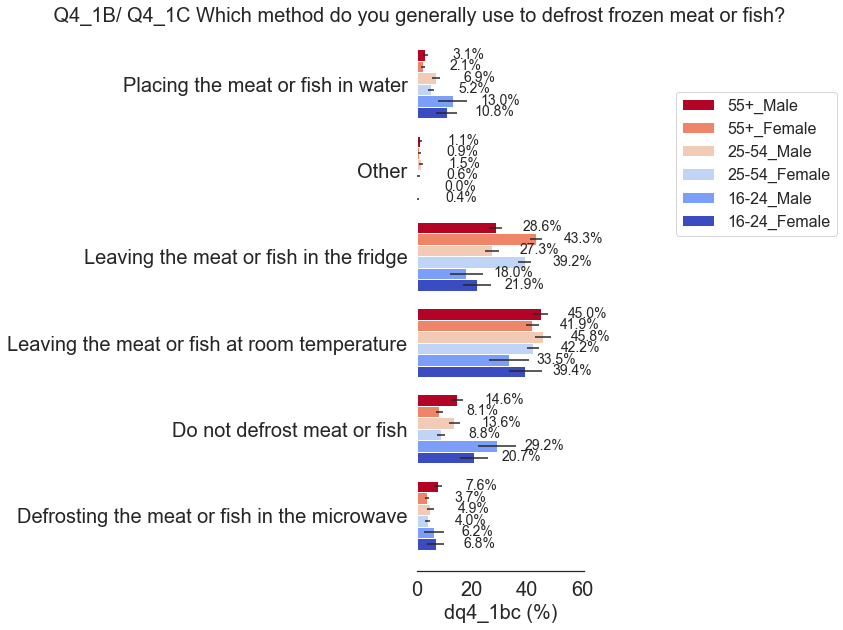

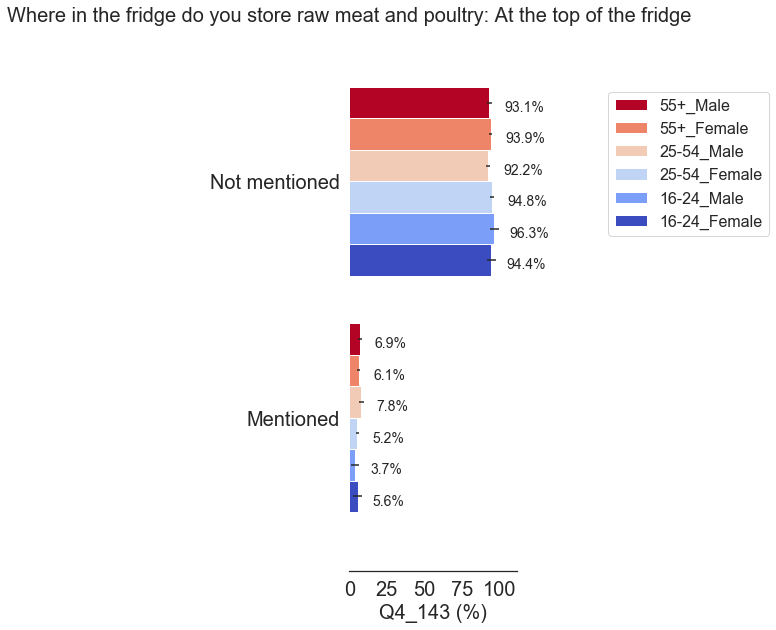

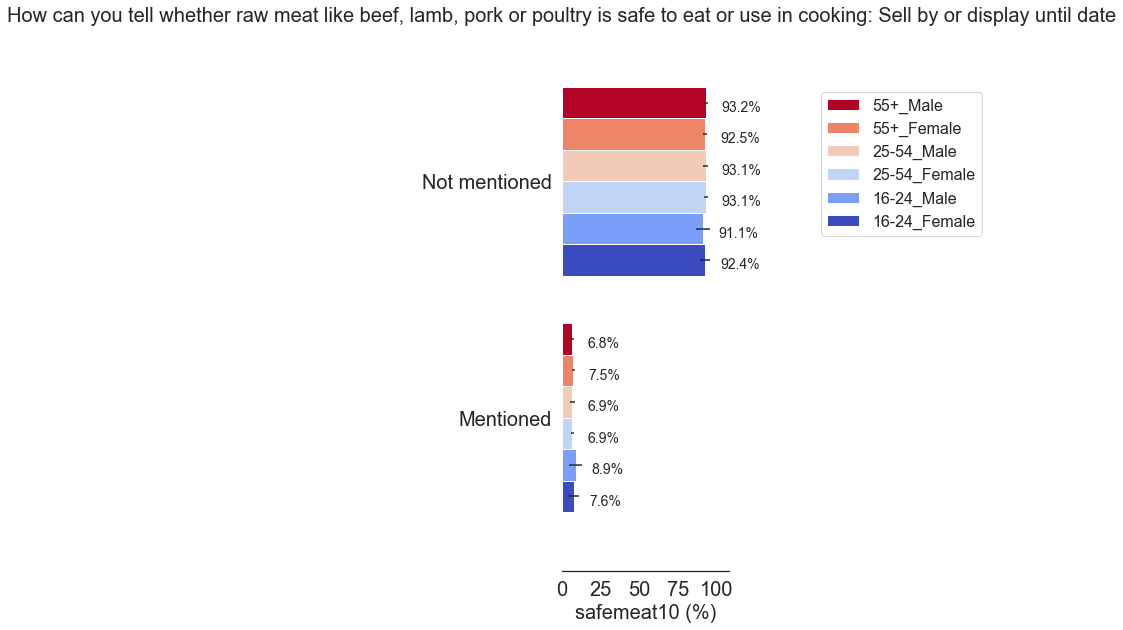

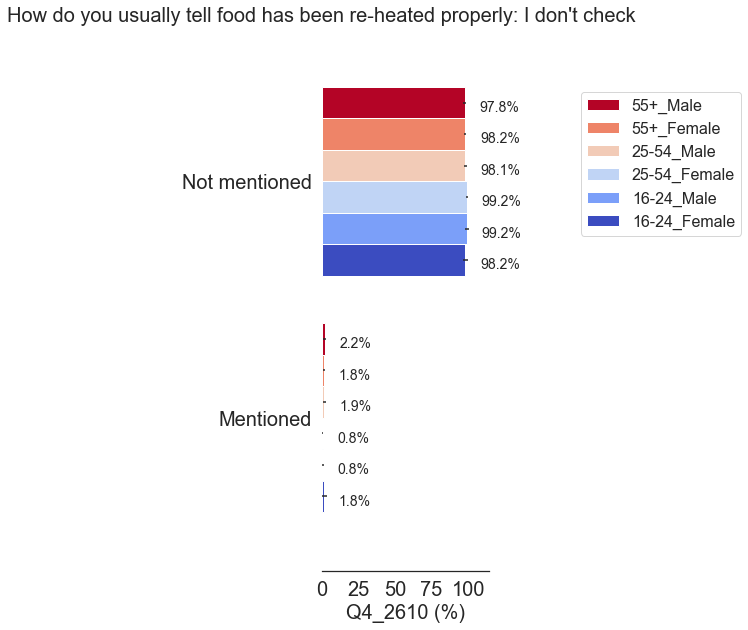

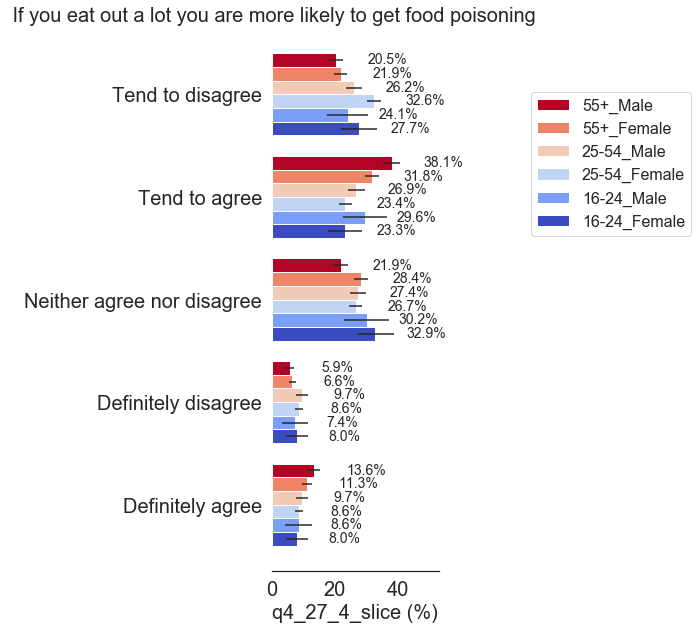

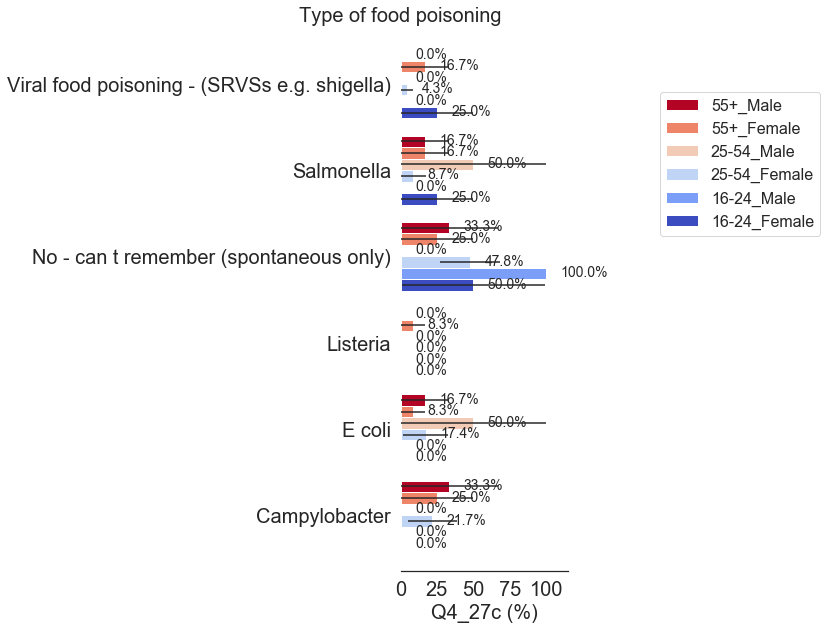

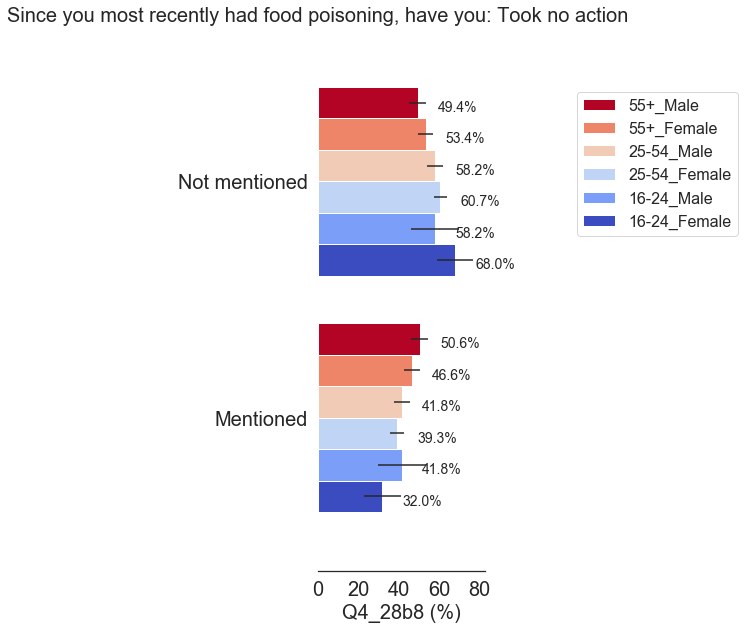

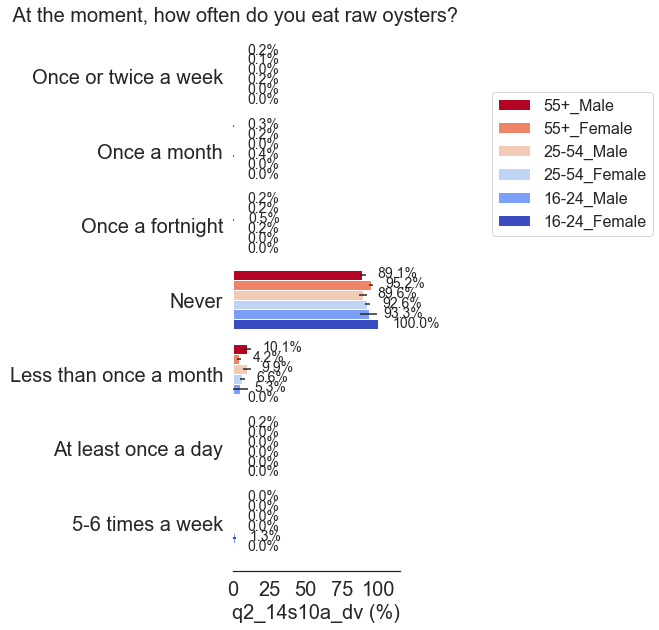

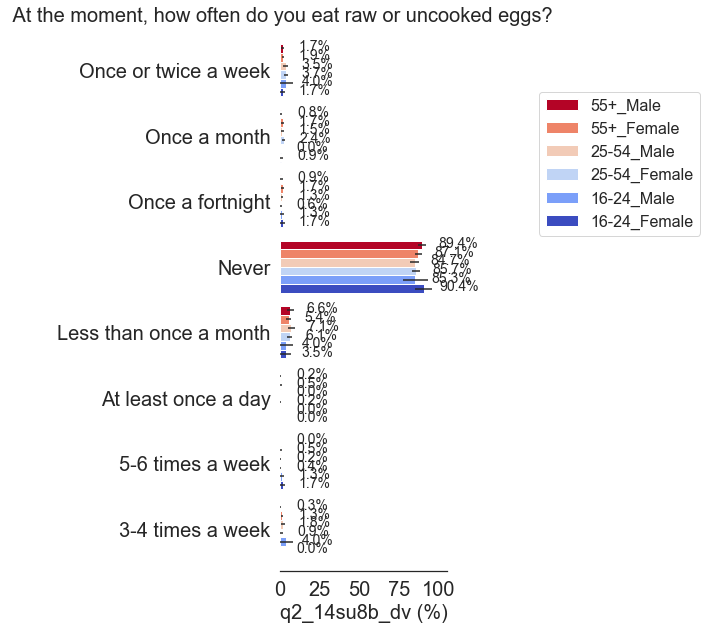

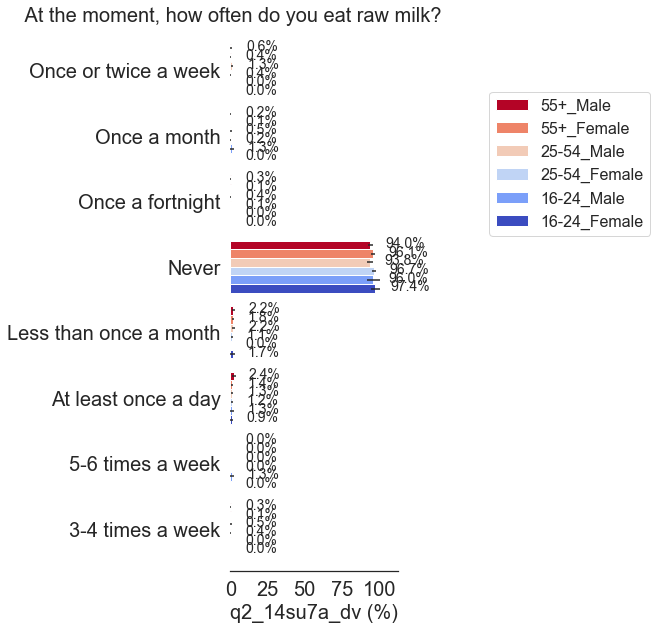

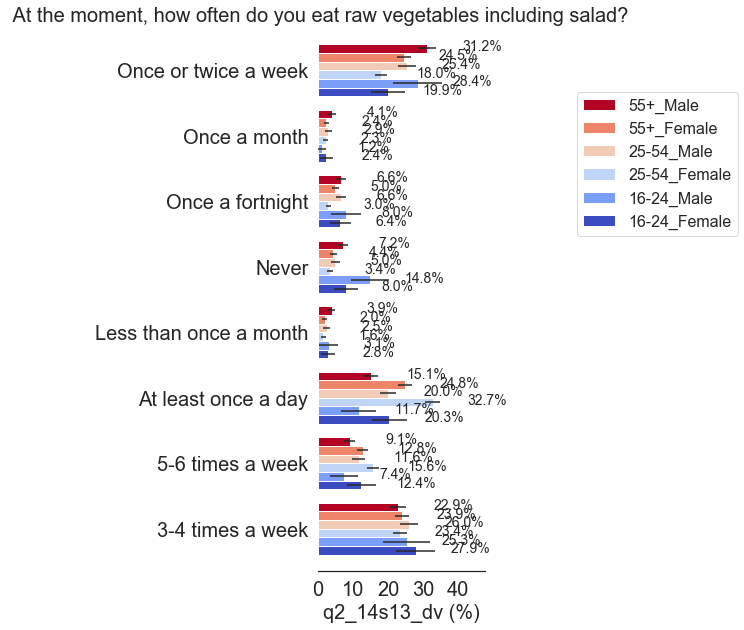

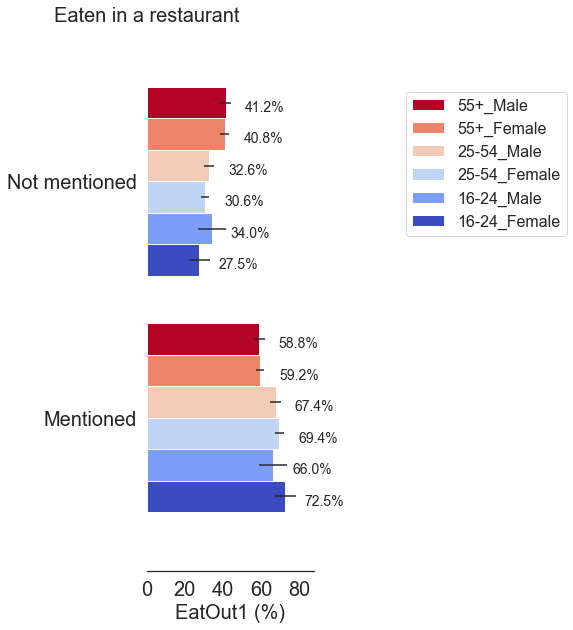

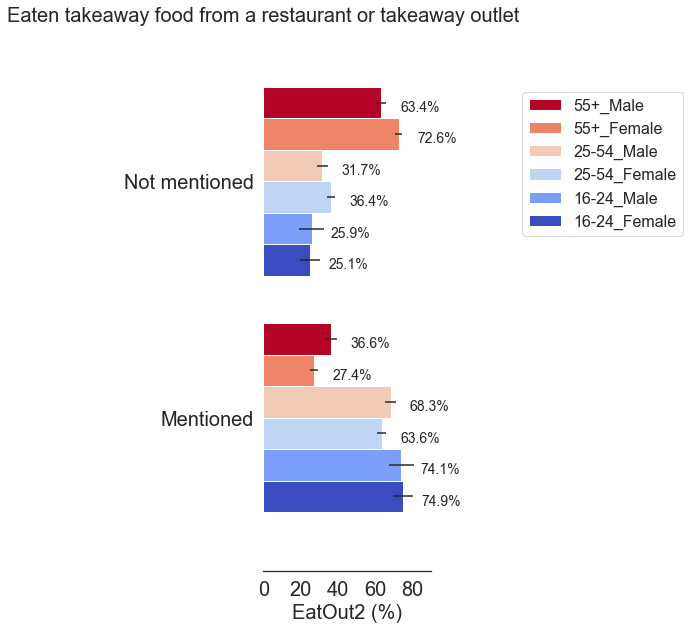

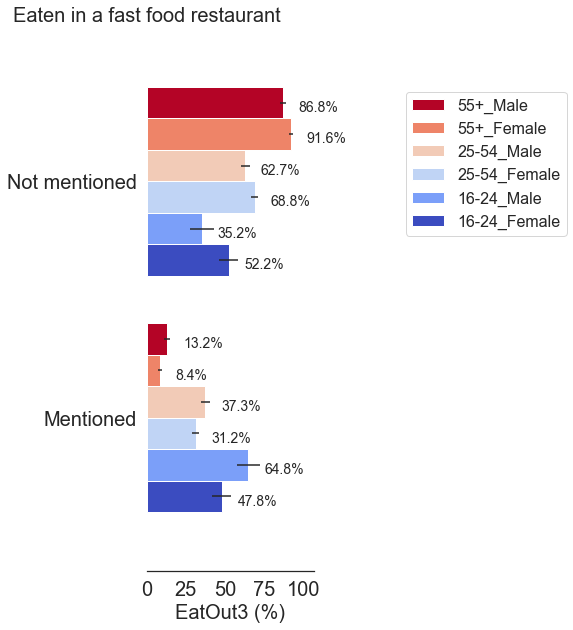

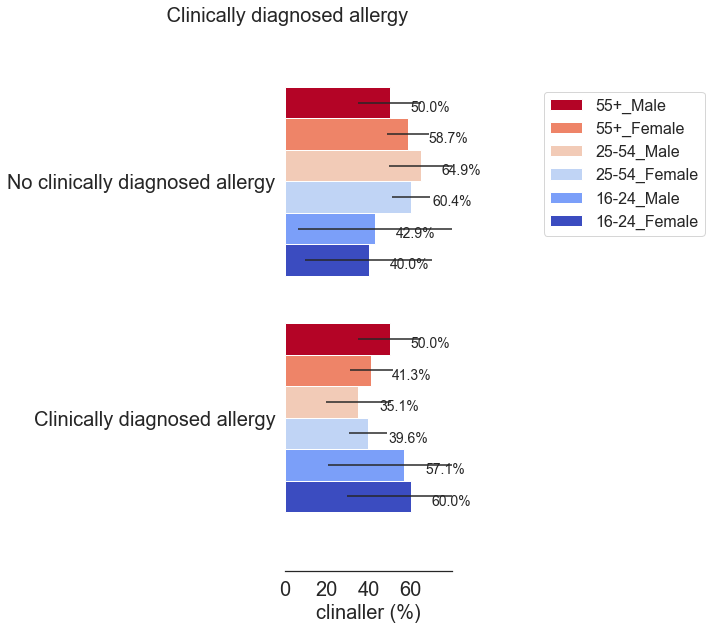

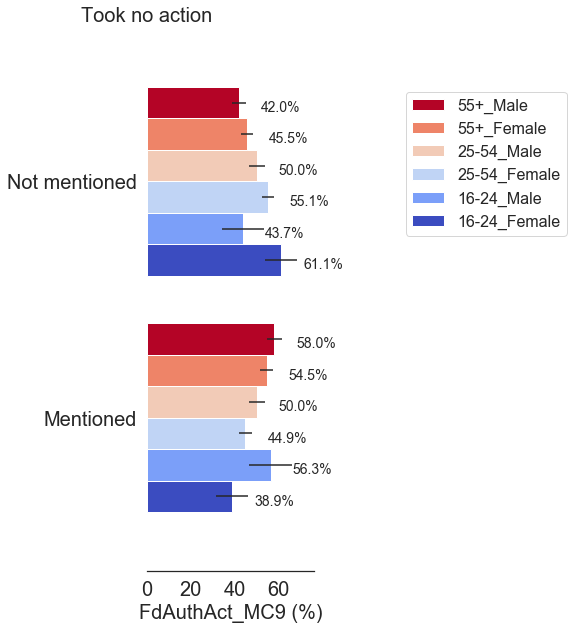

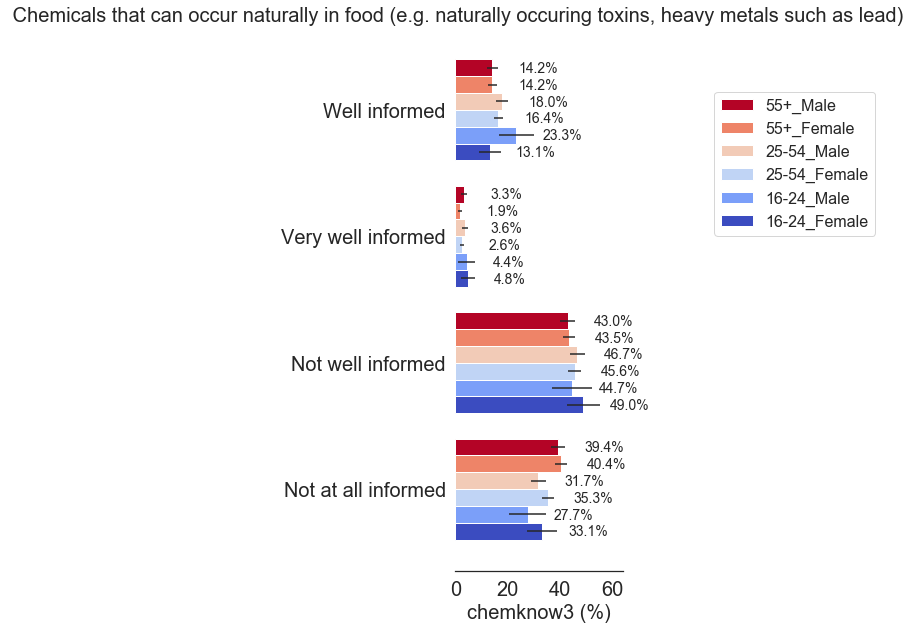

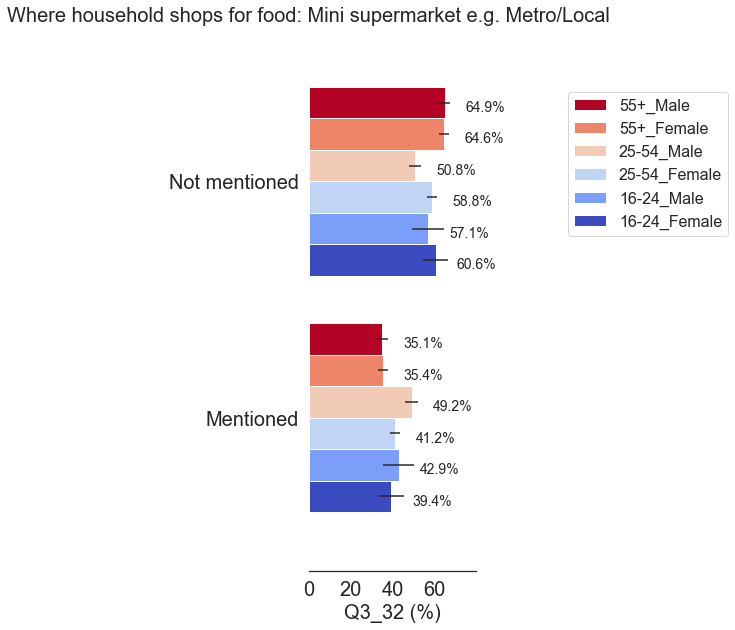

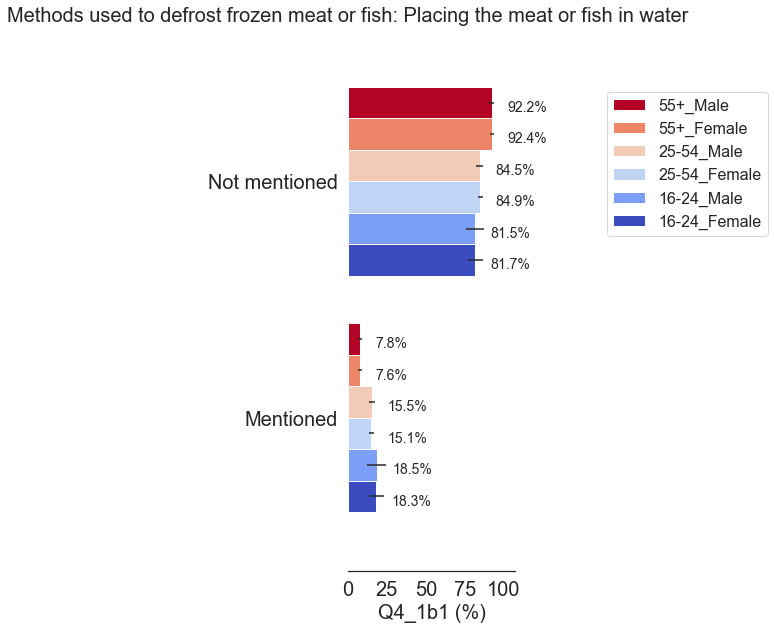

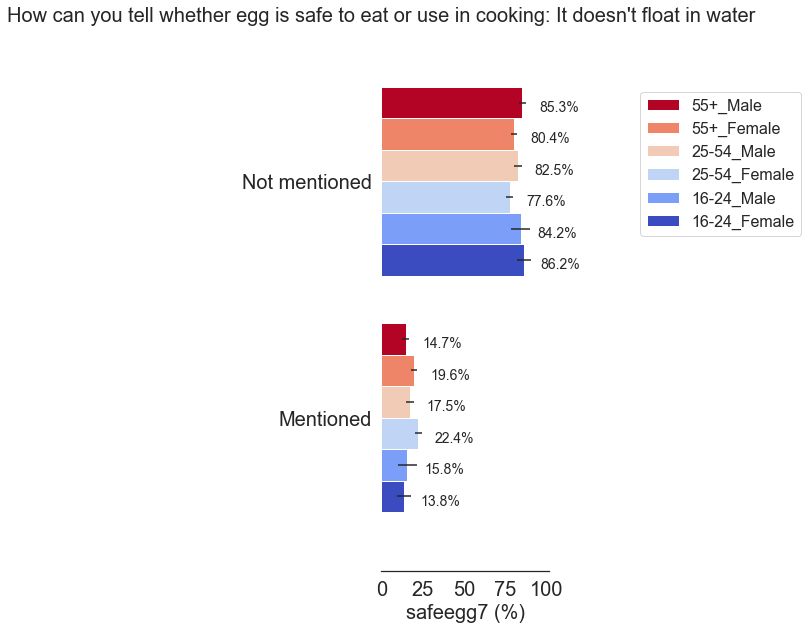

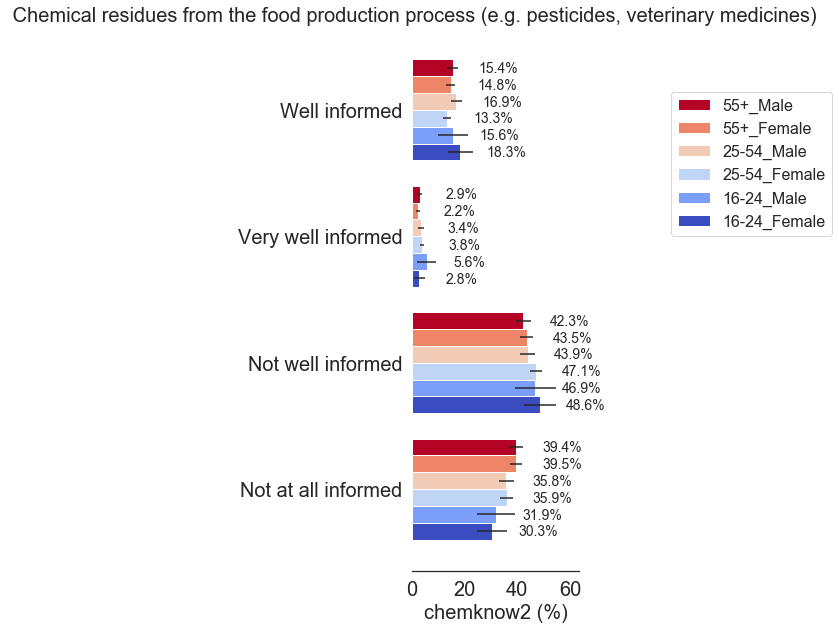

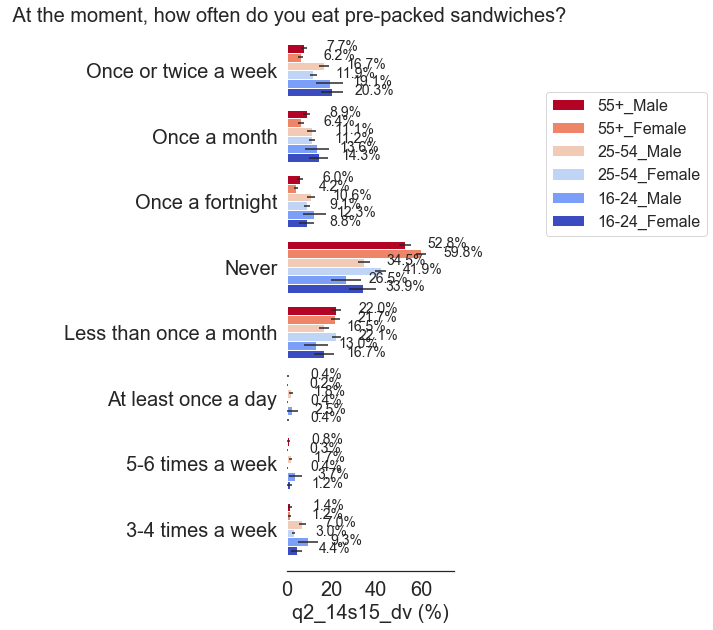

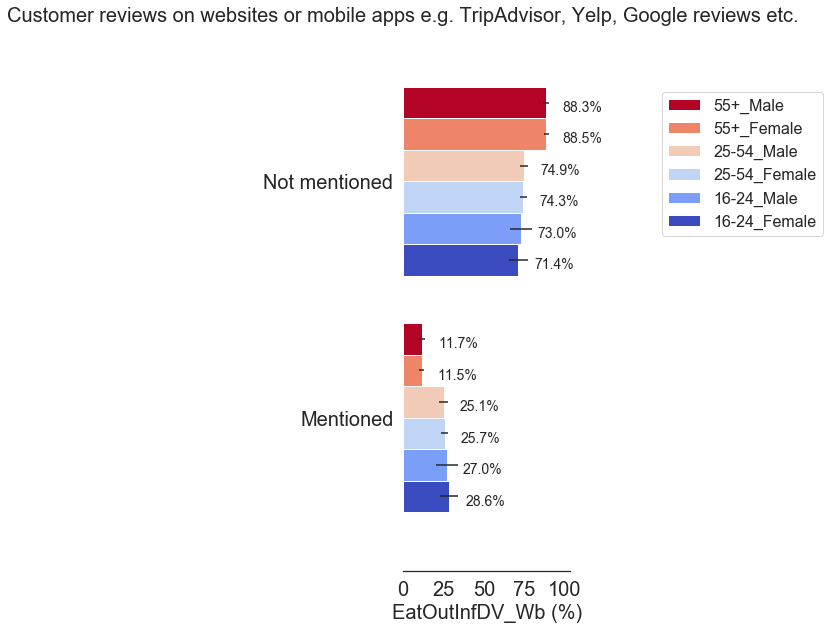

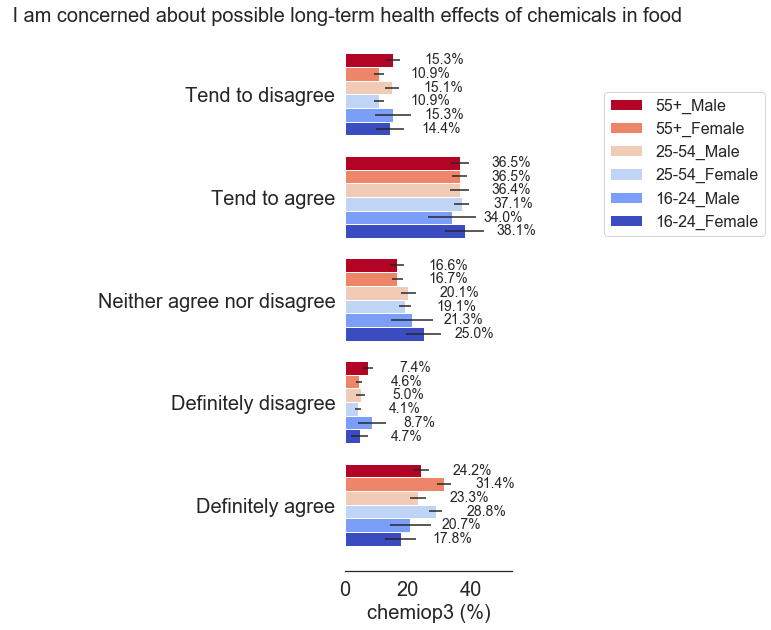

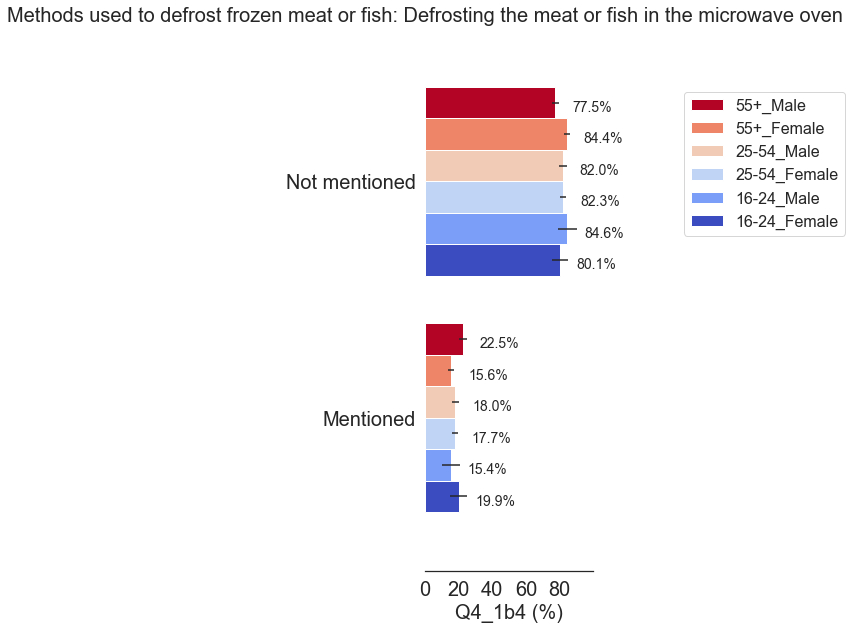

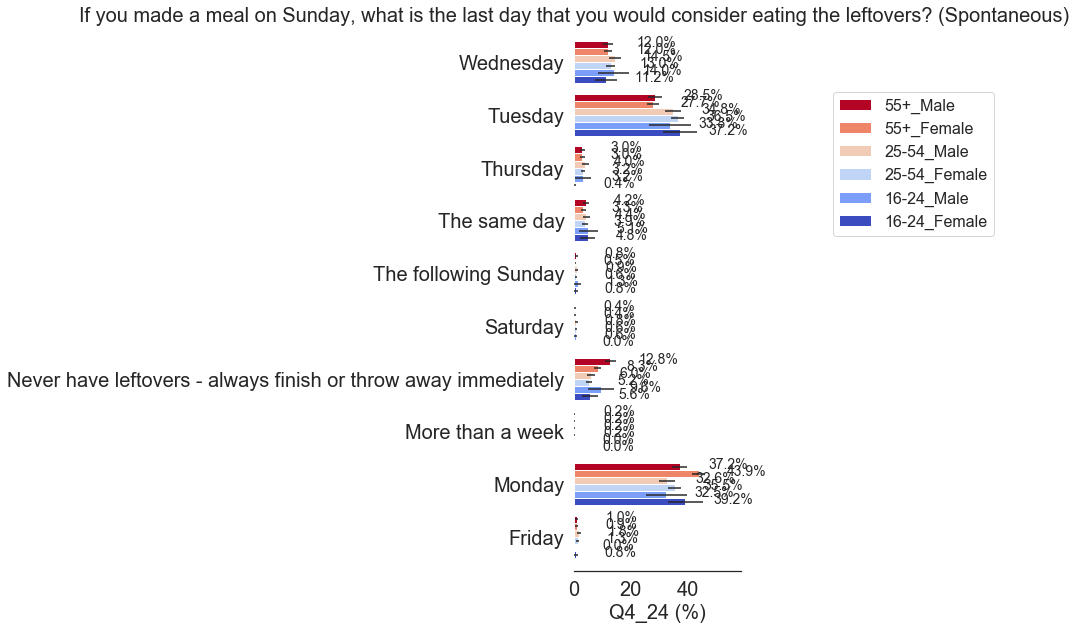

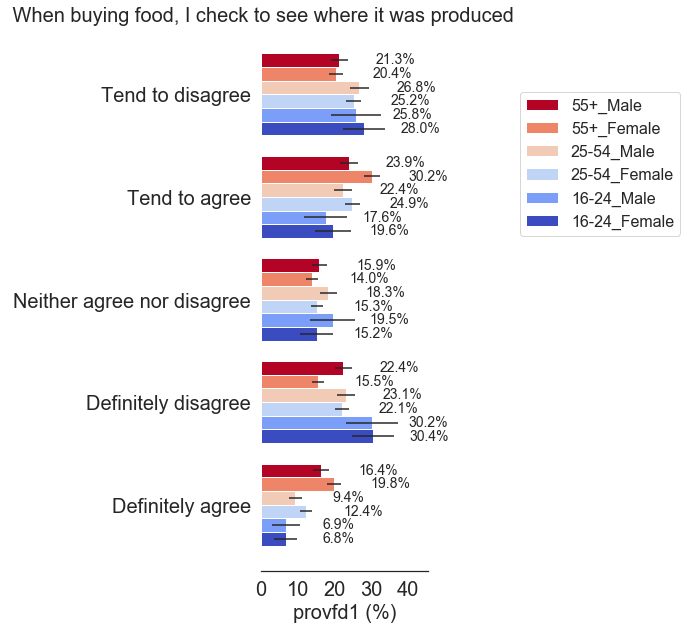

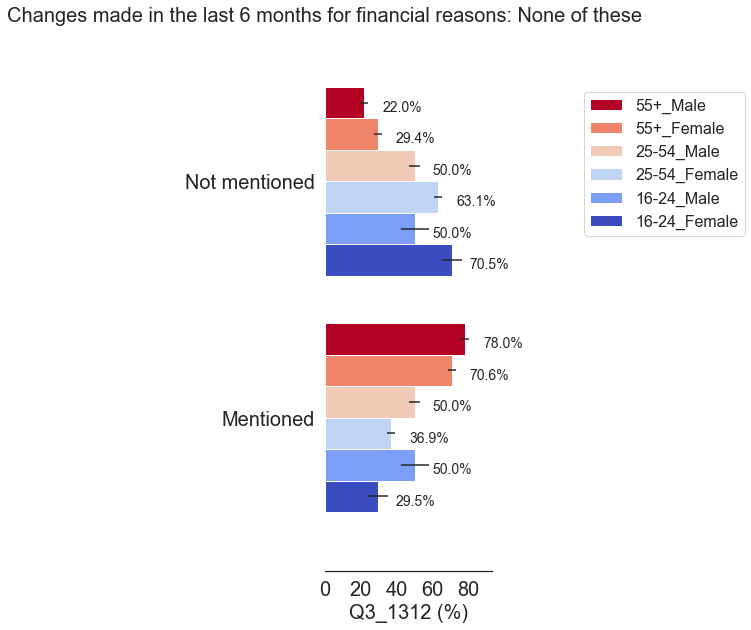

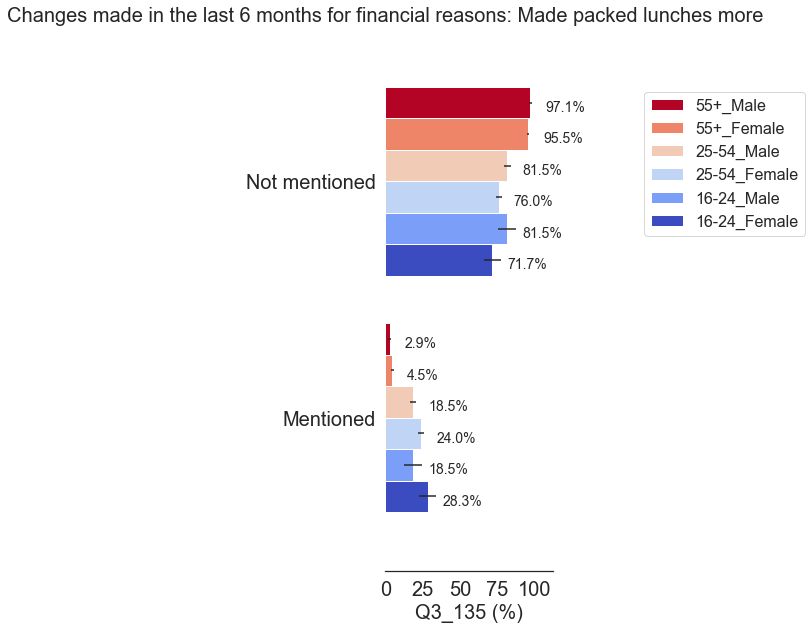

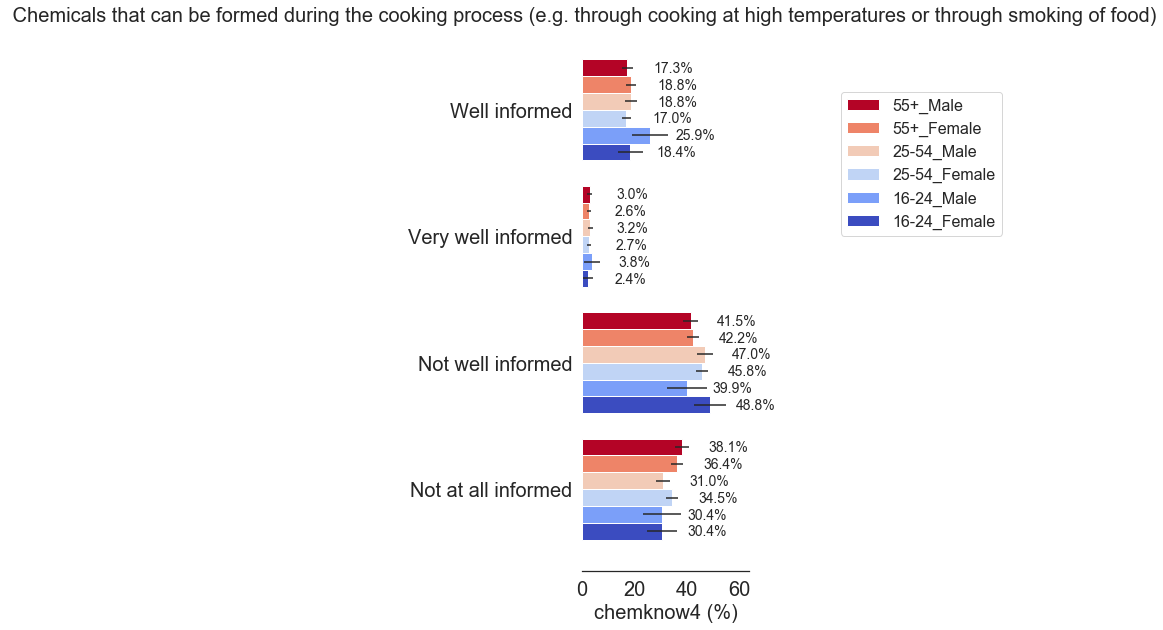

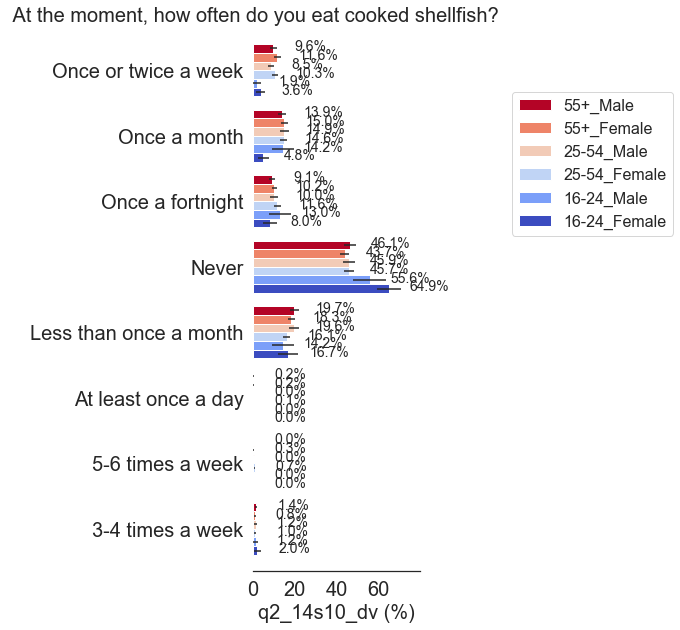

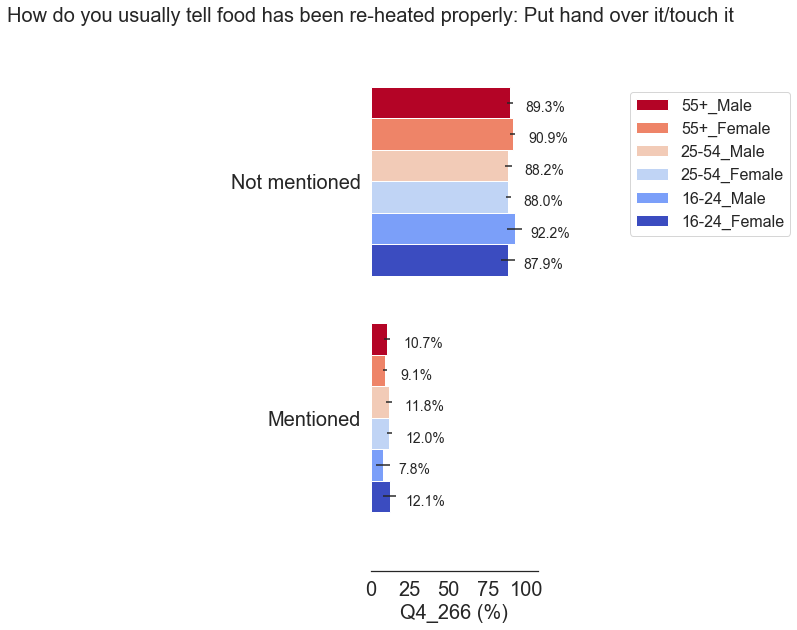

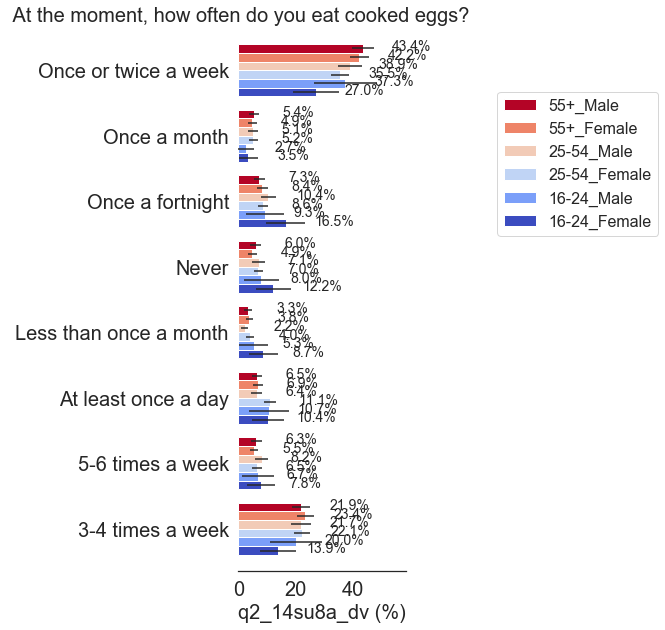

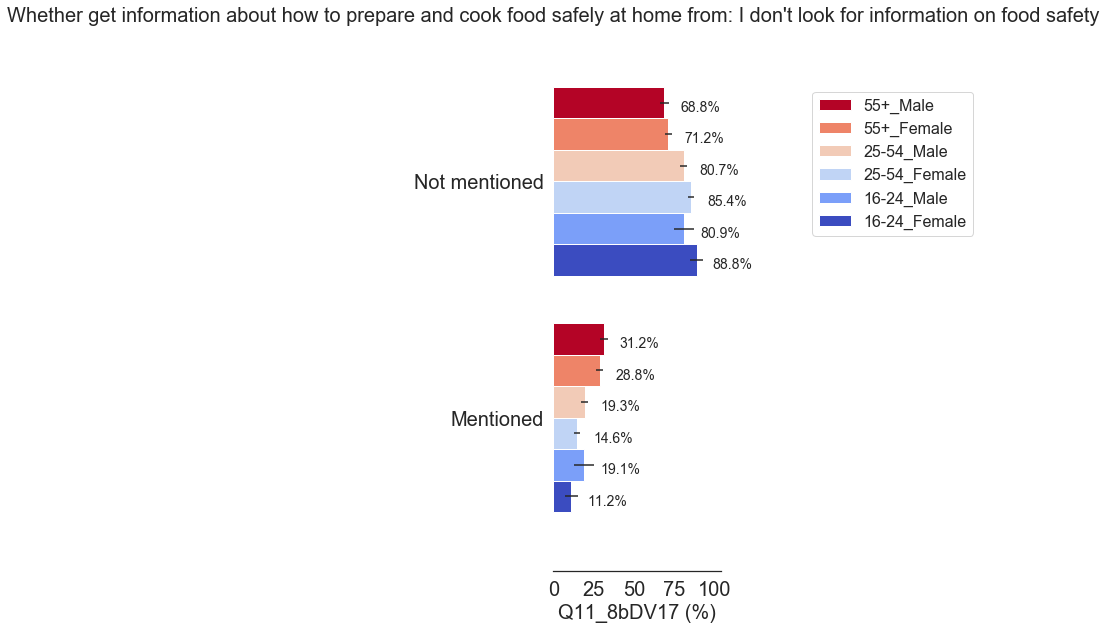

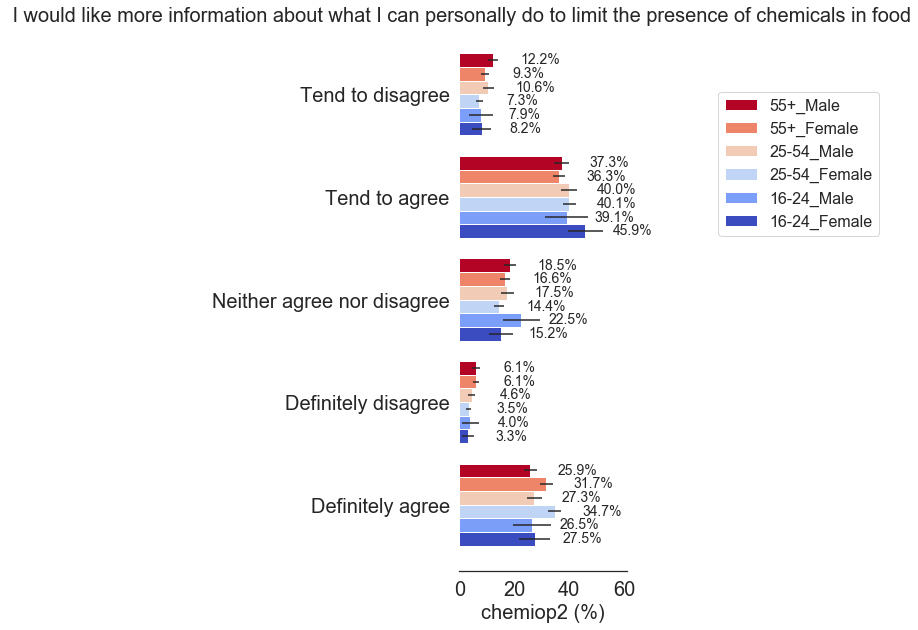

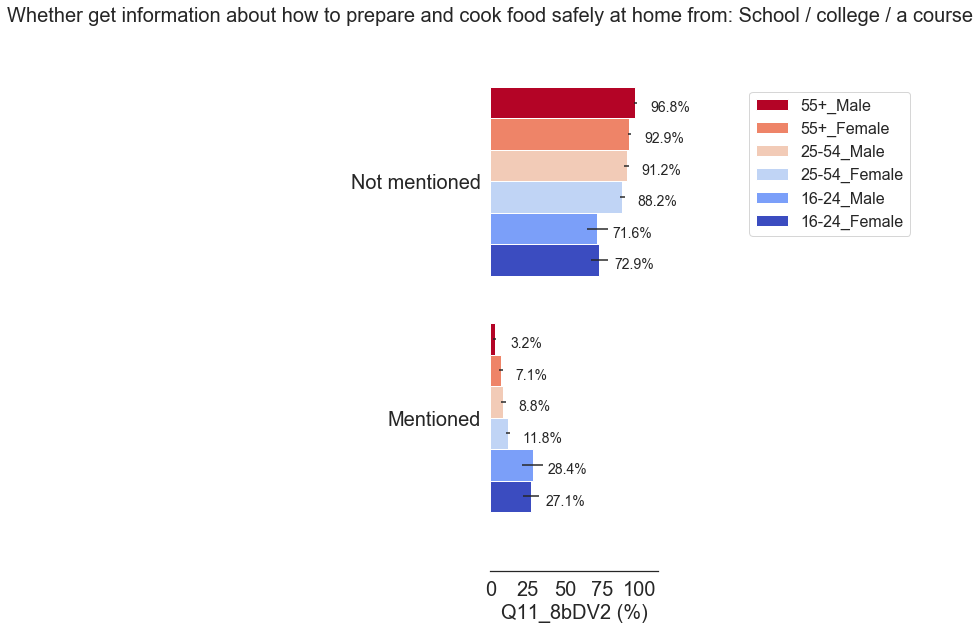

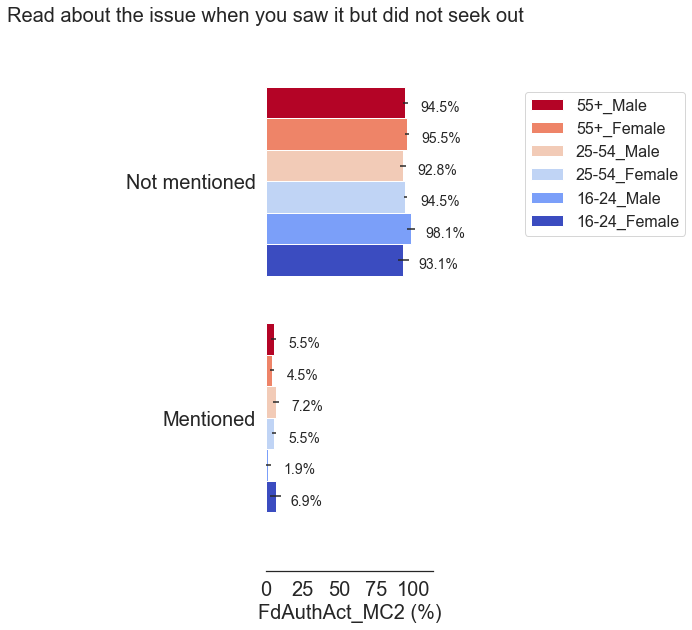

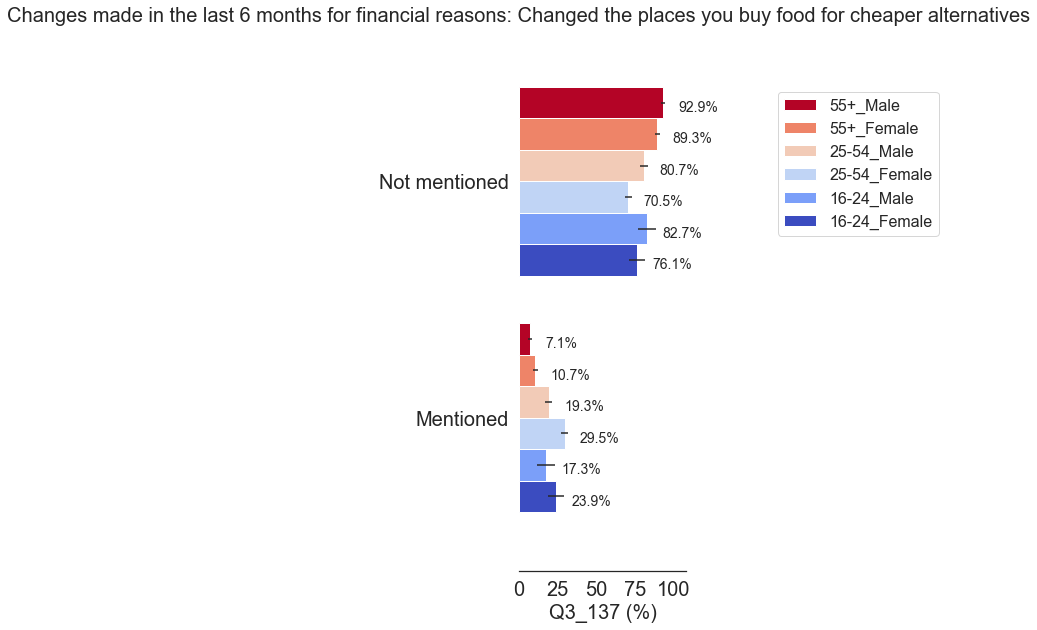

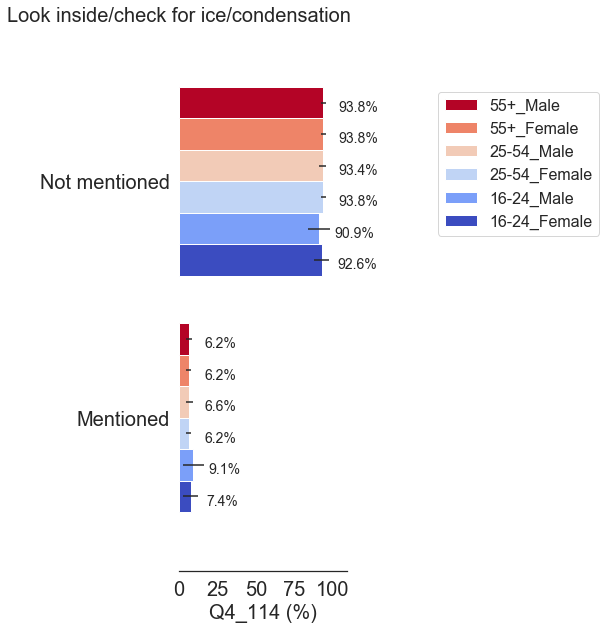

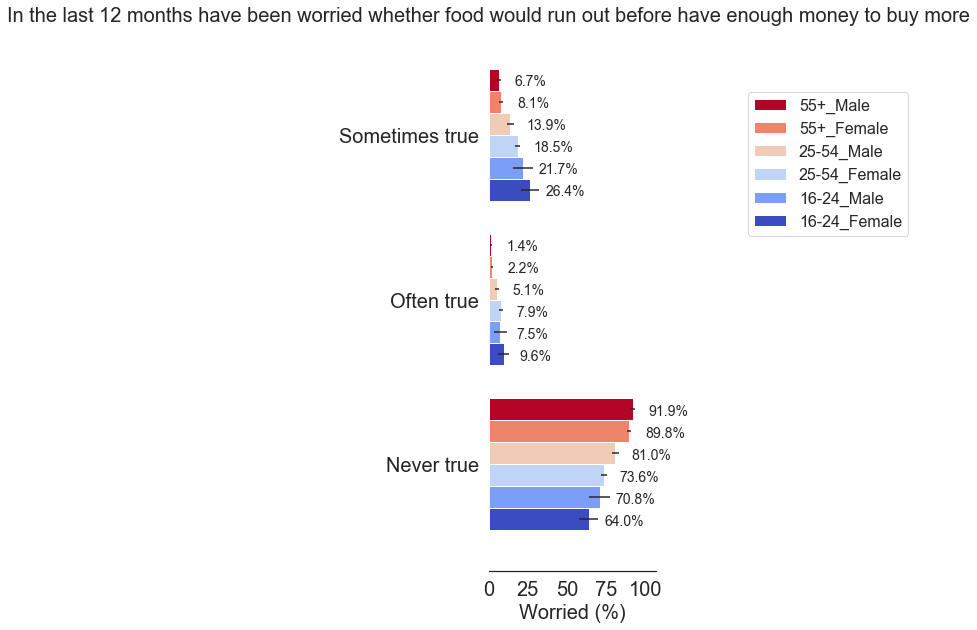

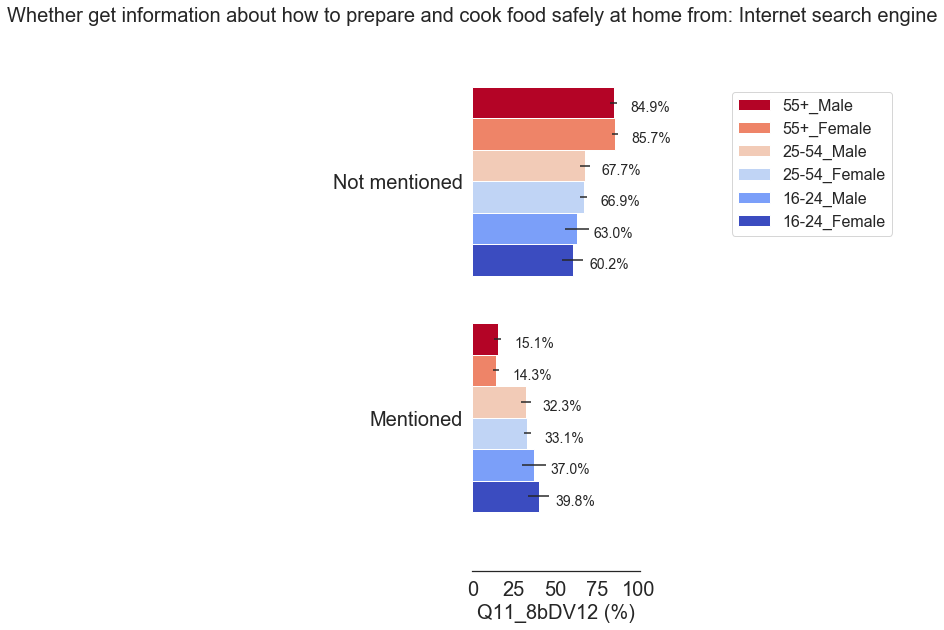

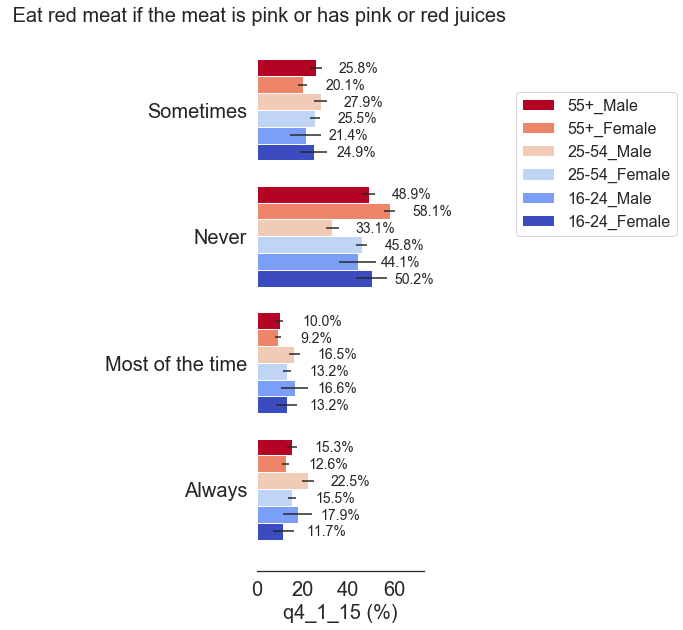

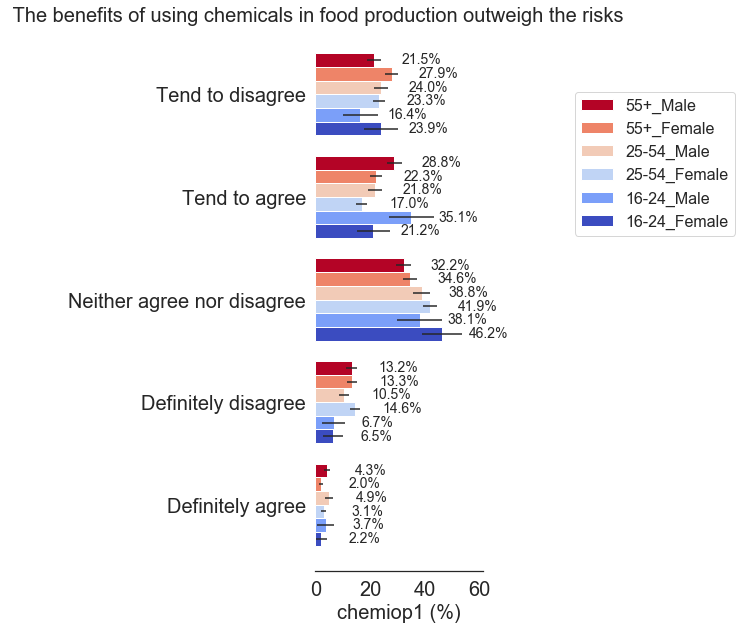

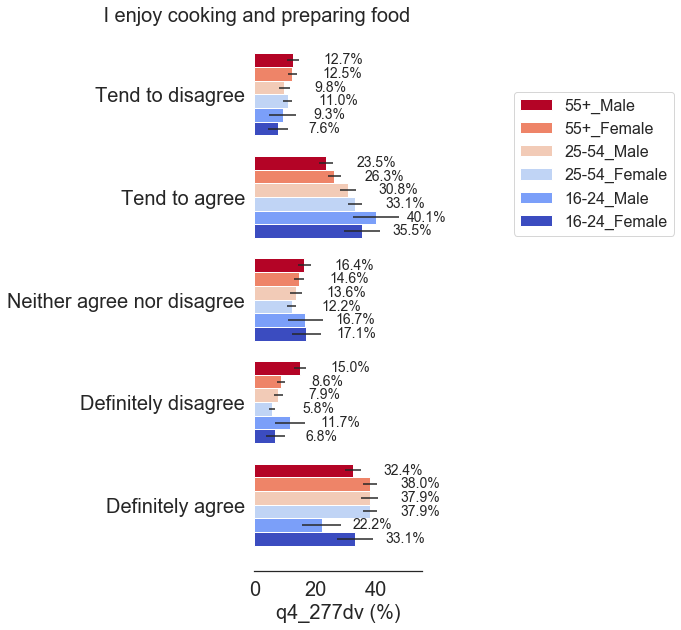

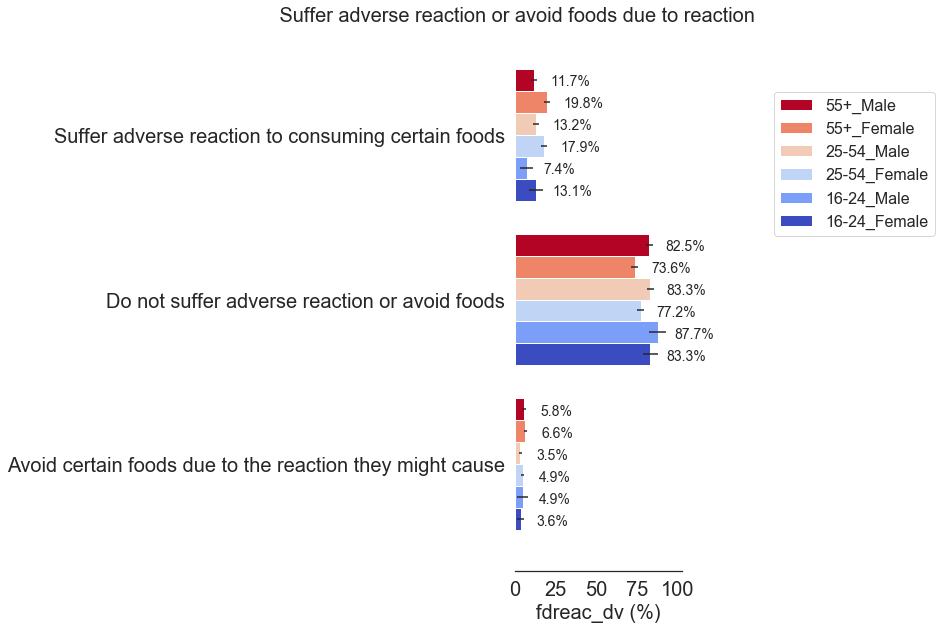

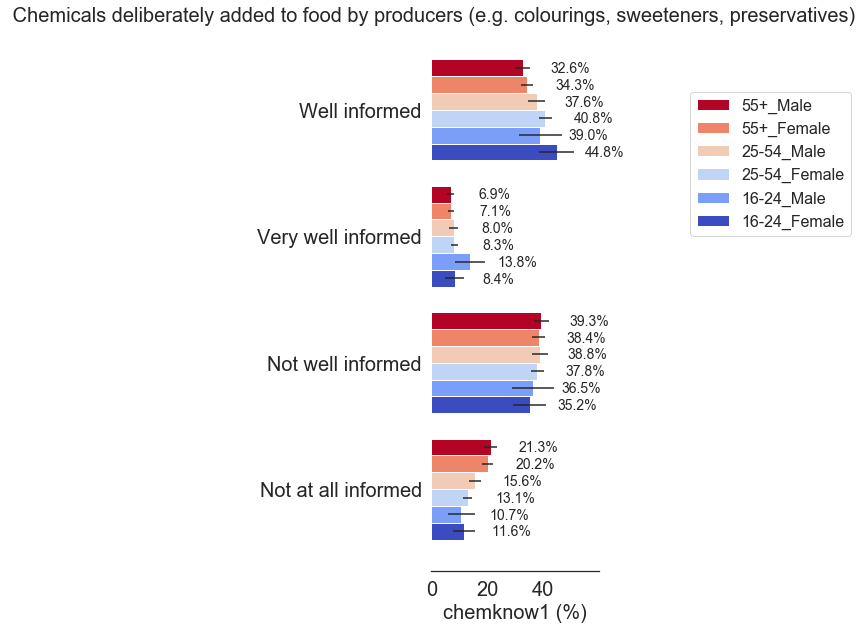

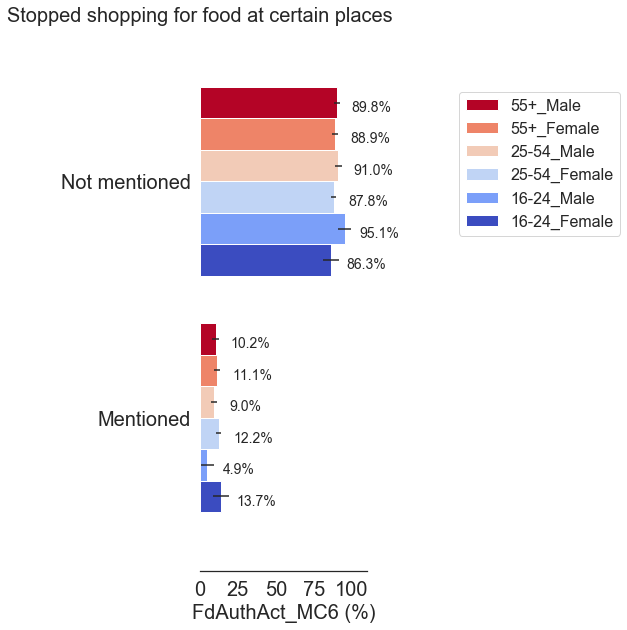

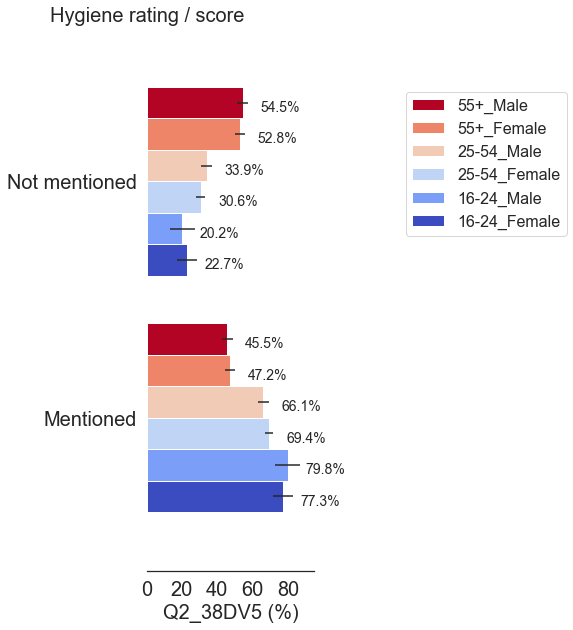

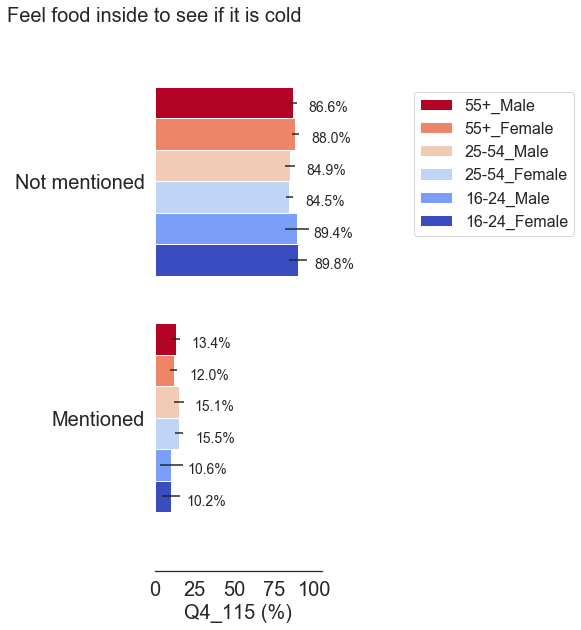

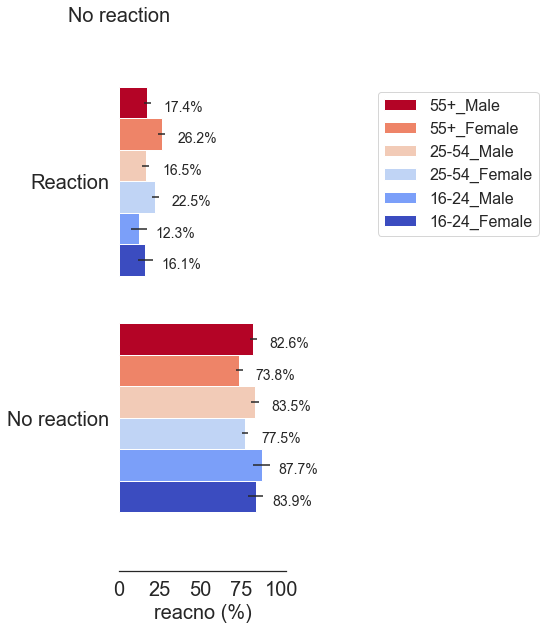

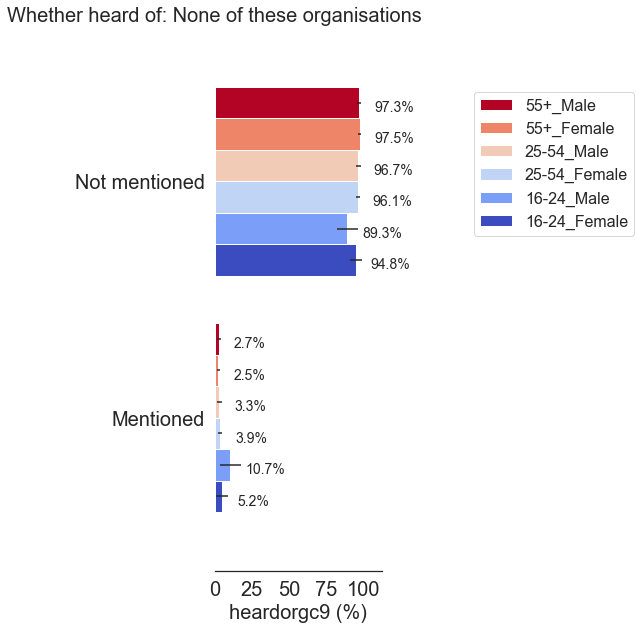

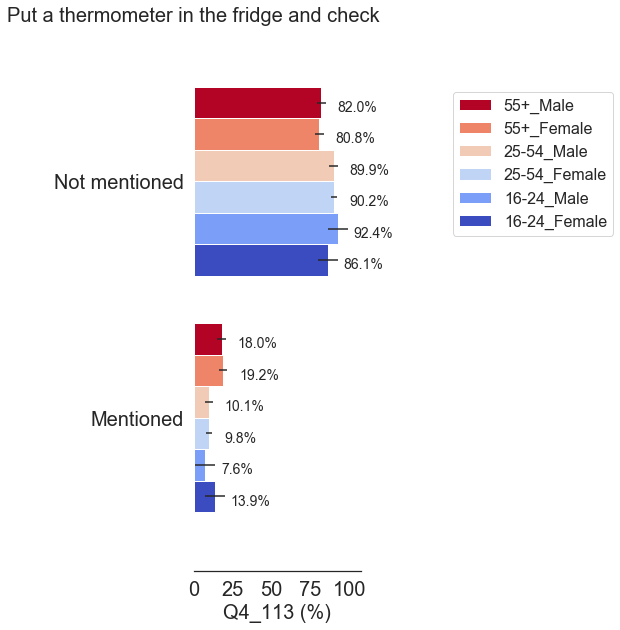

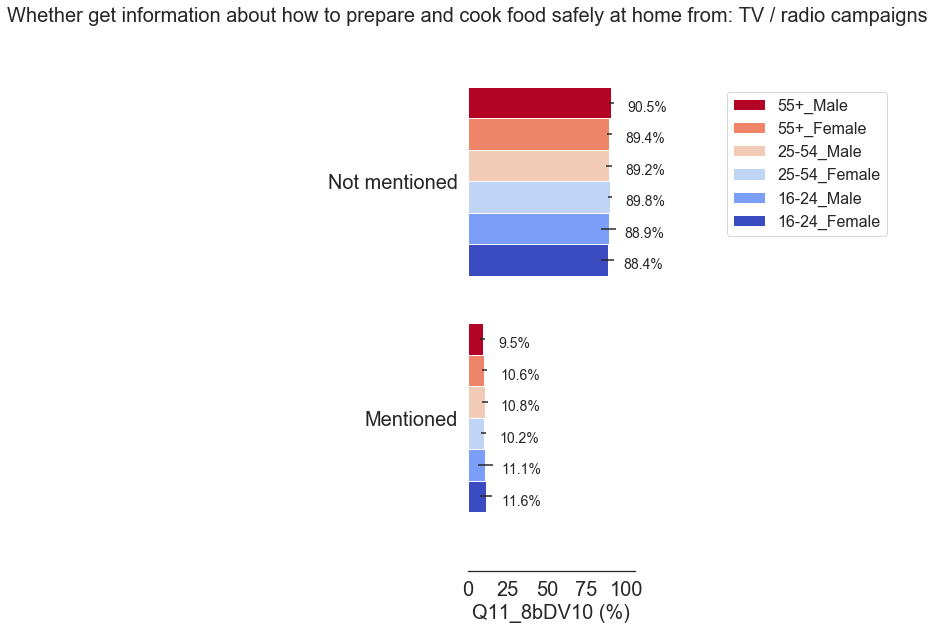

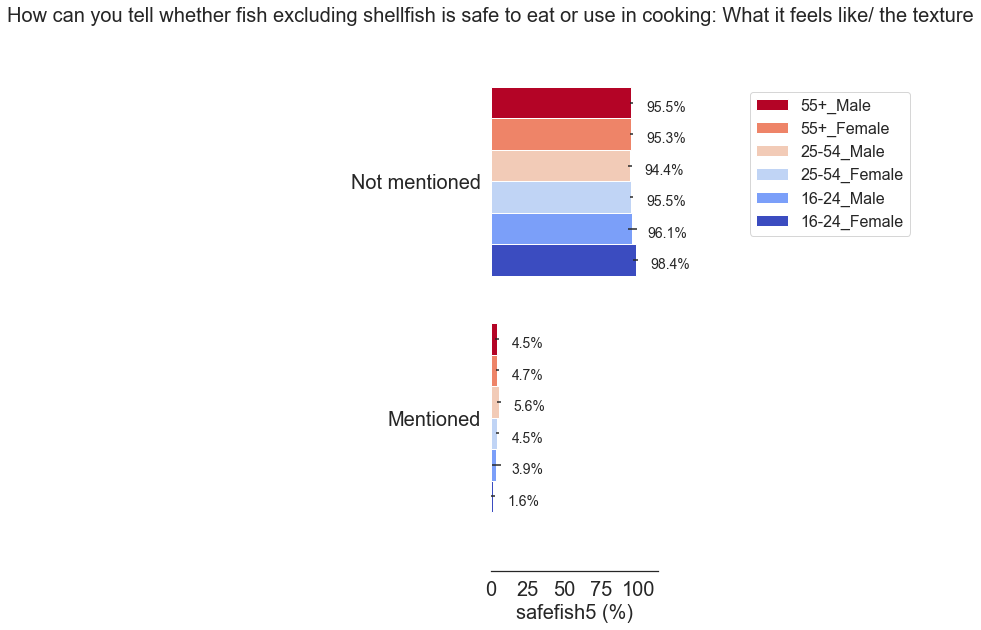

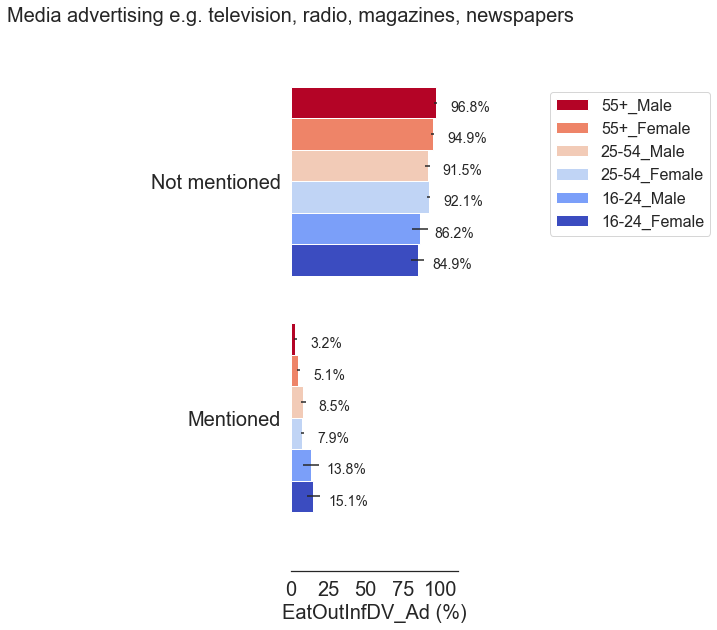

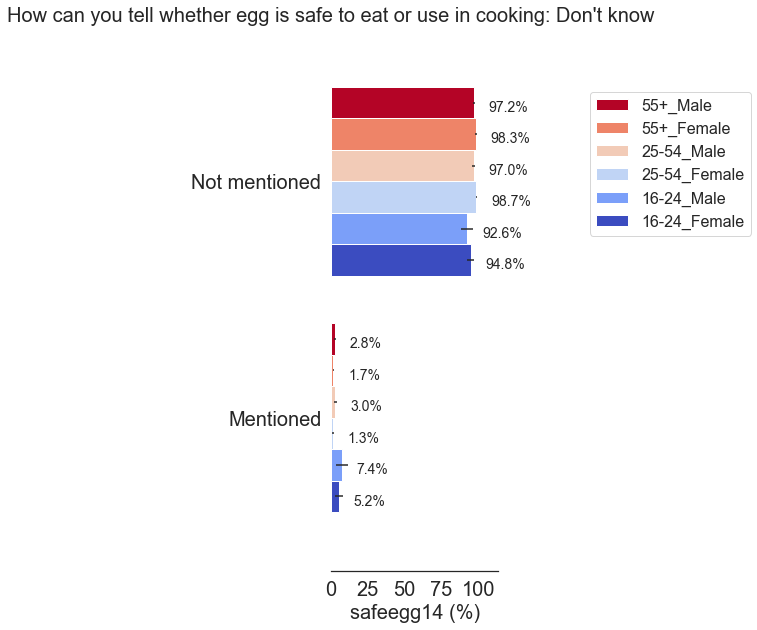

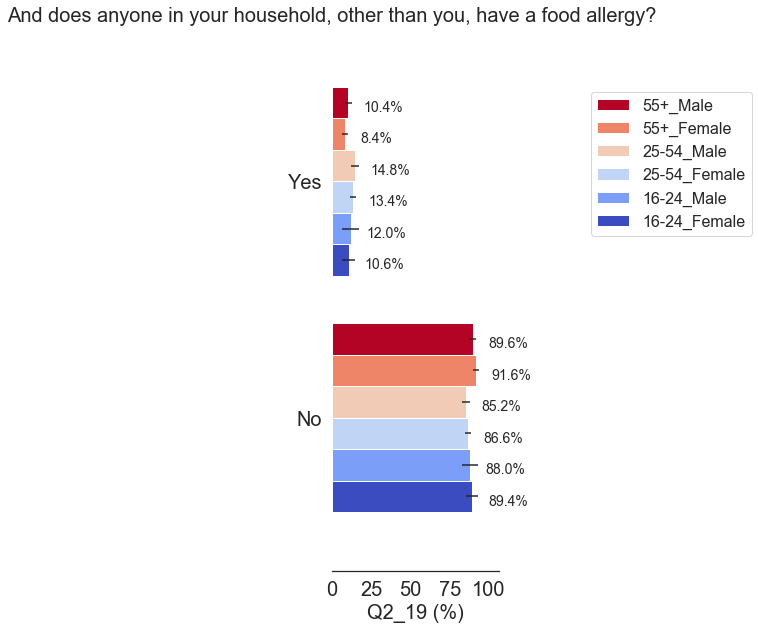

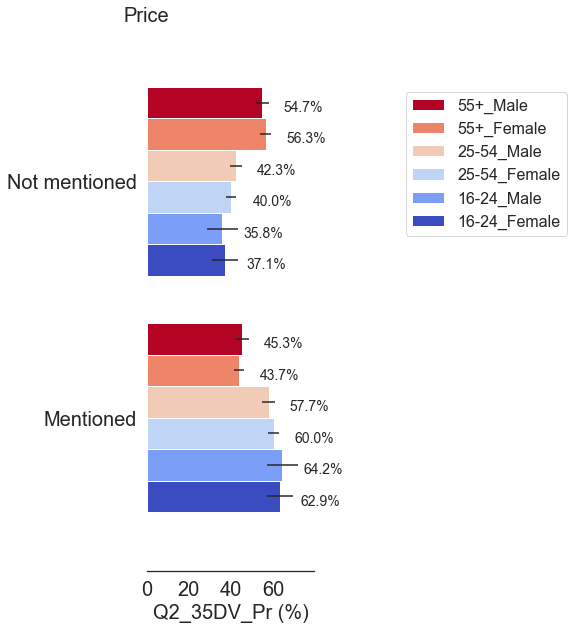

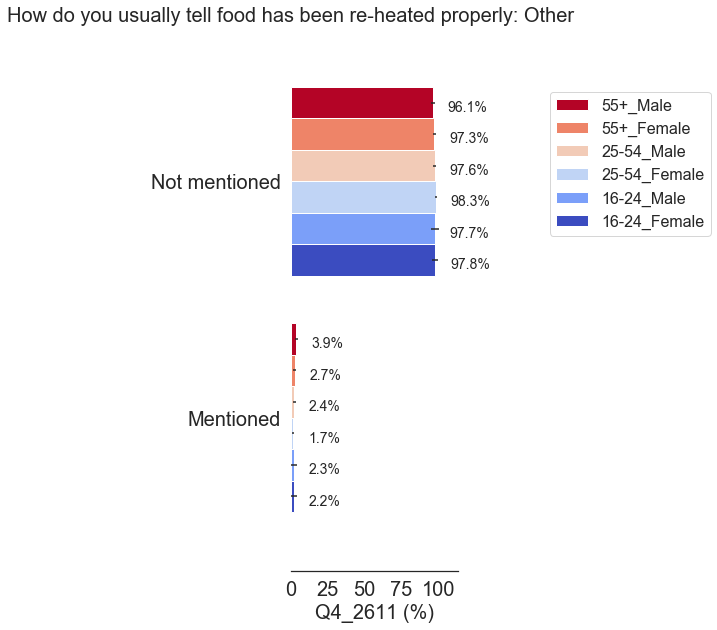

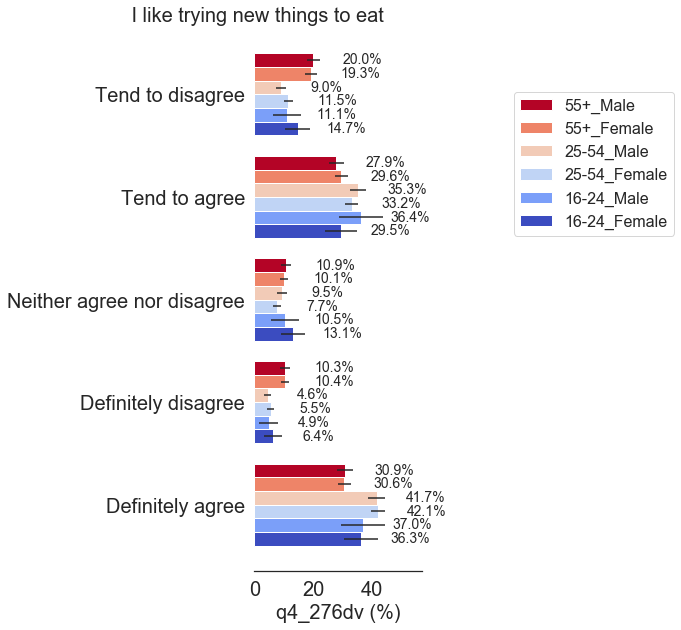

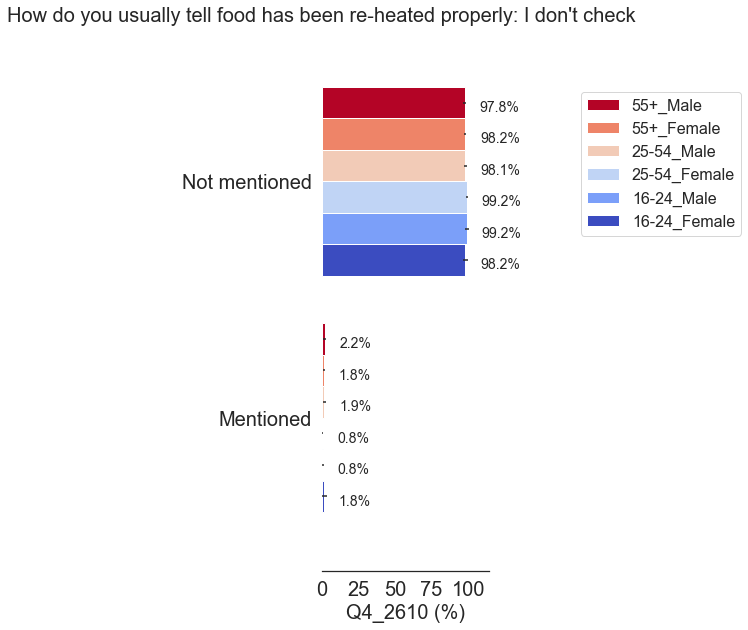

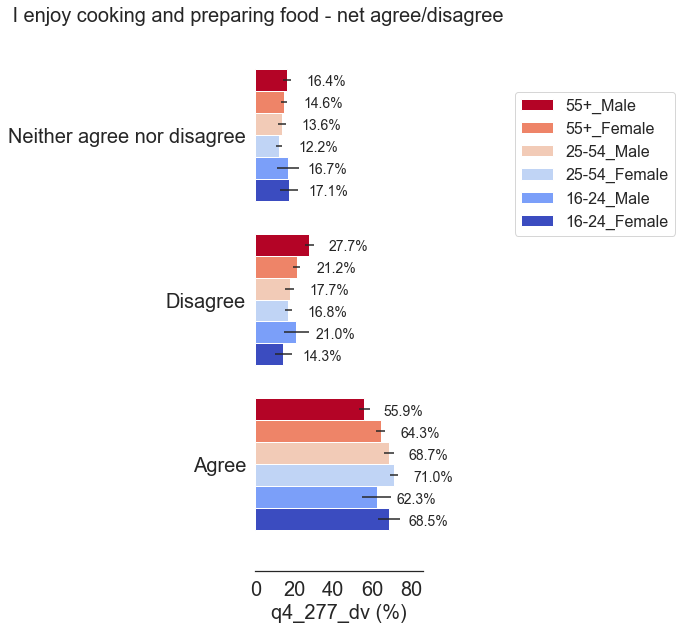

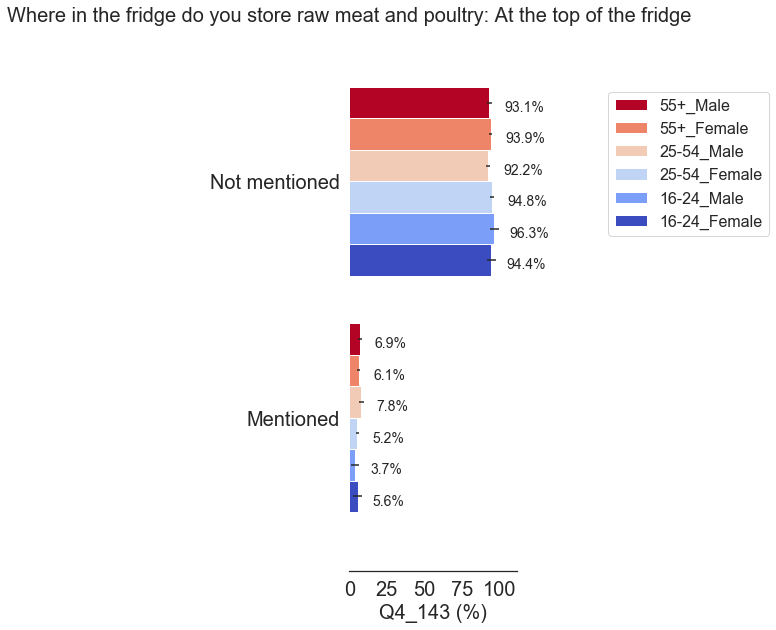

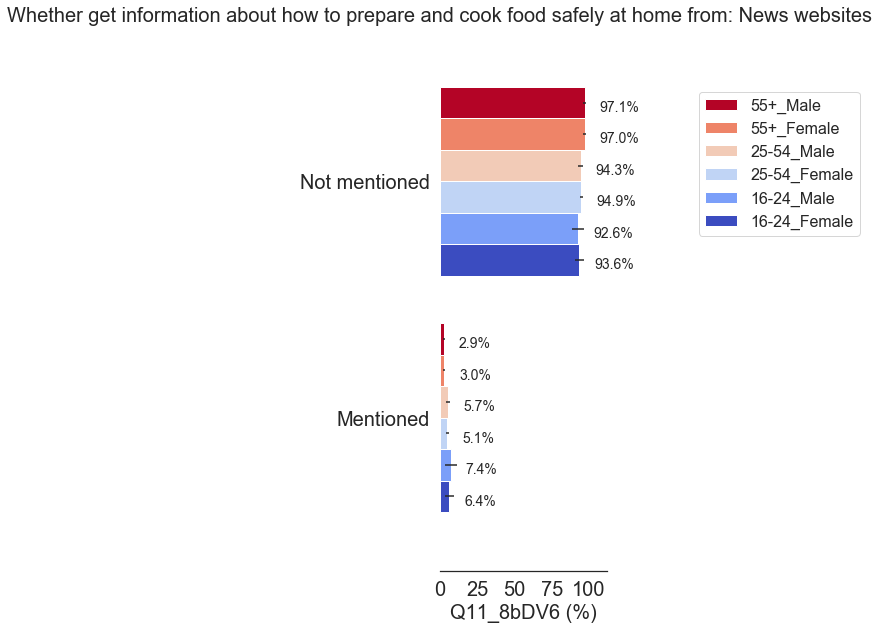

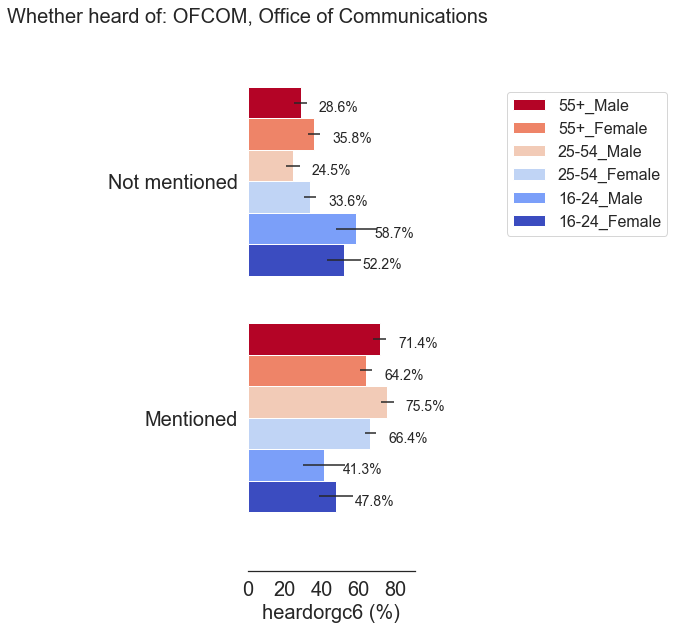

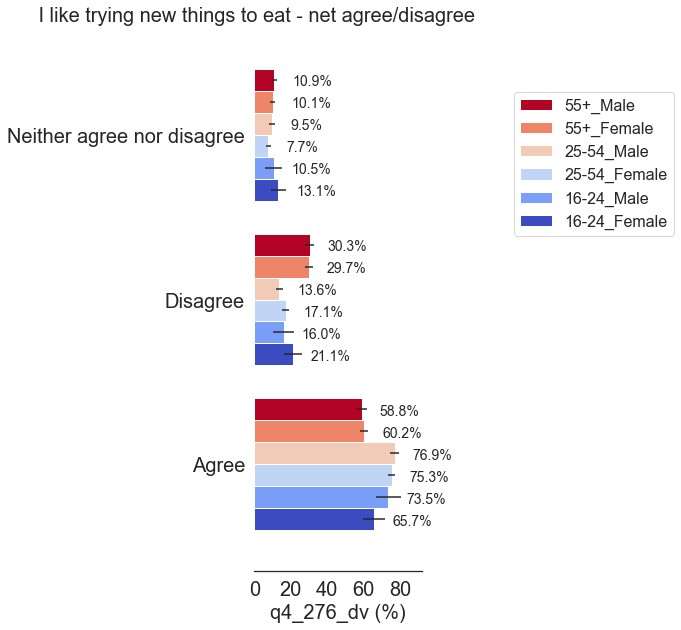

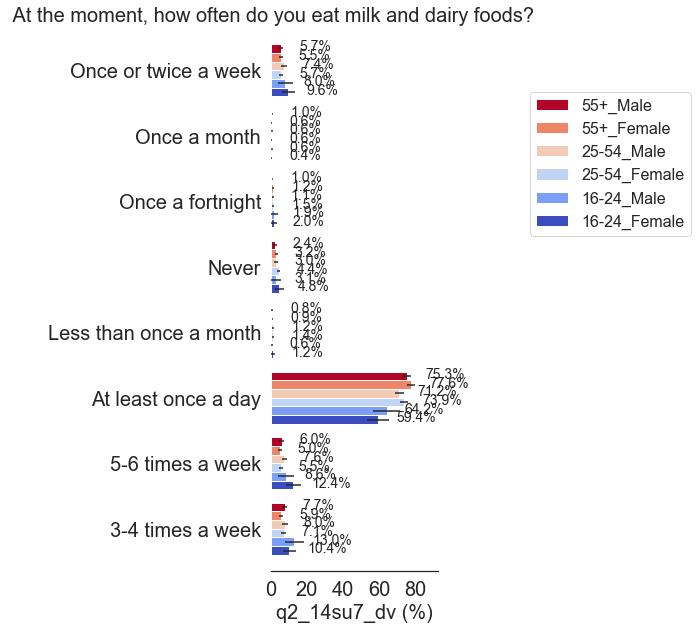

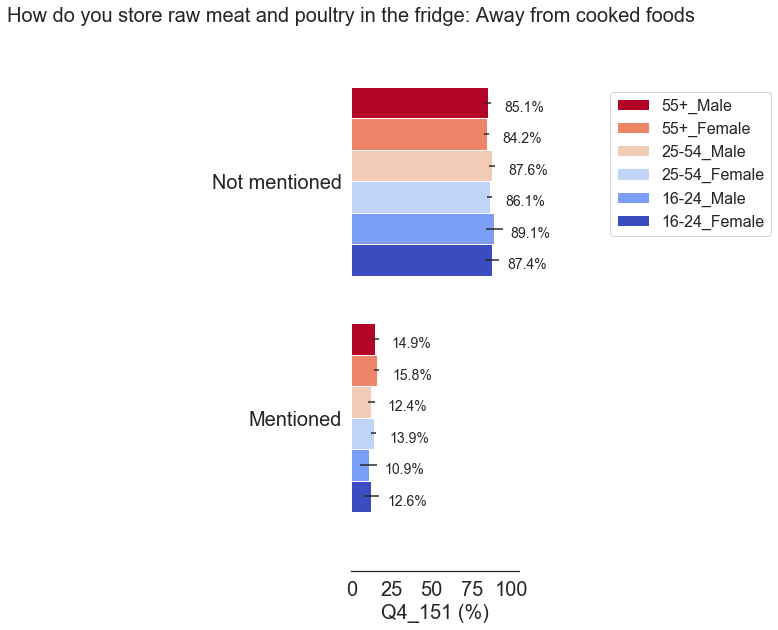

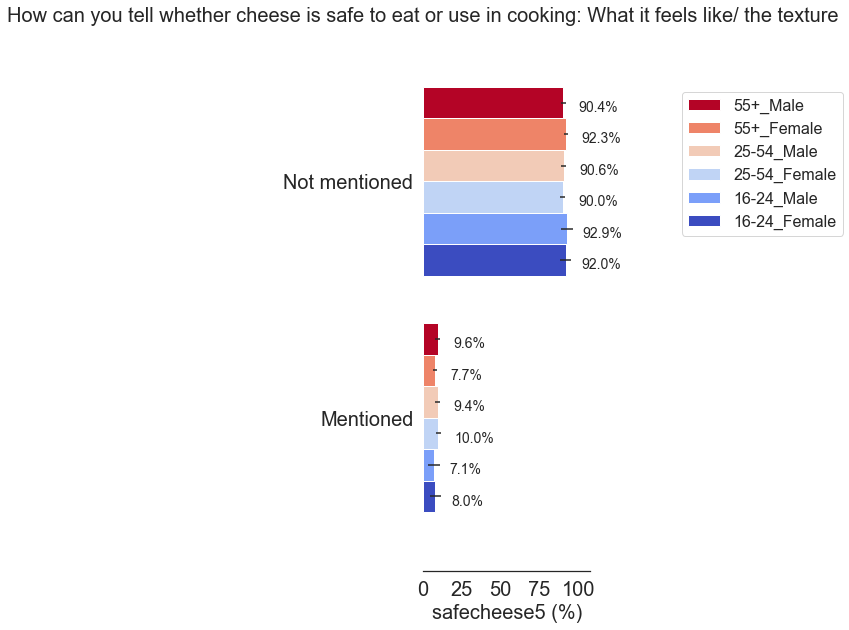

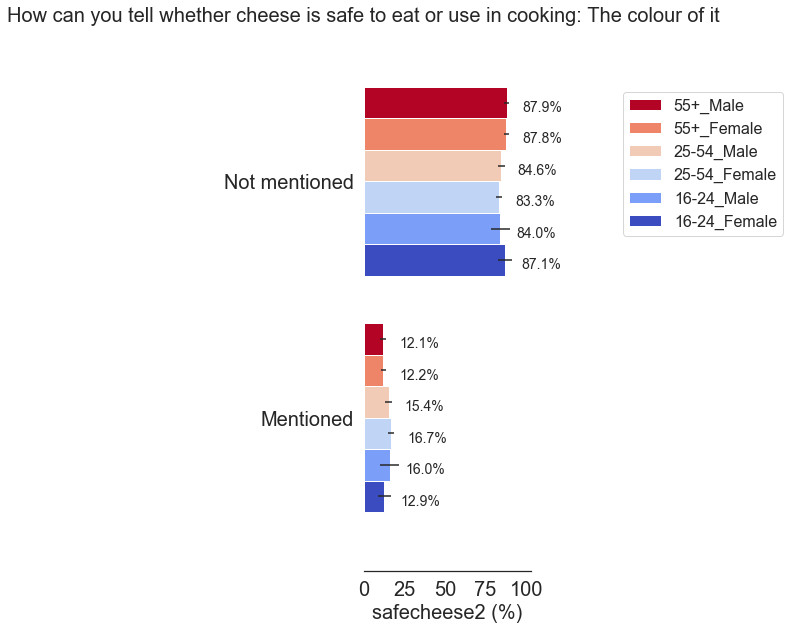

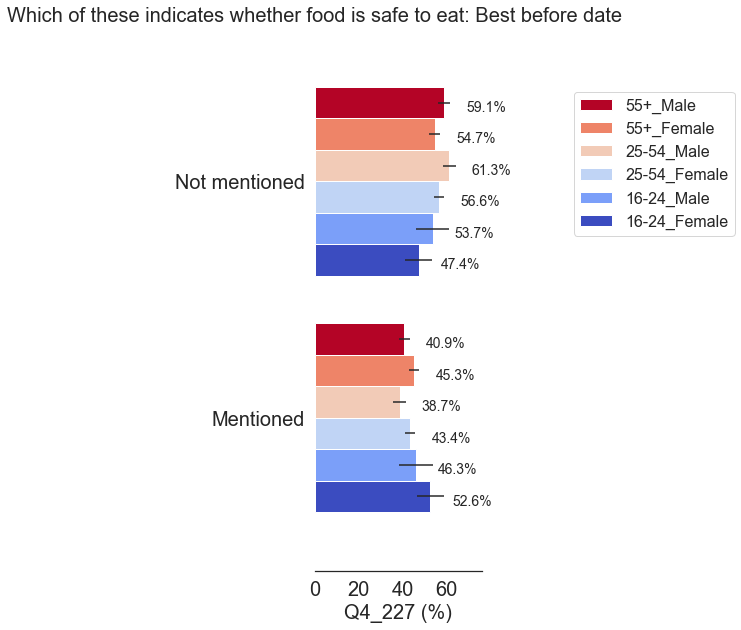

In [22]:
#Plot food risks associated to desired subpopulation groups for specified relevant questions
custom_barplots(survey_subpopulation, # [survey_subpopulation.country_dv.eq(2)] if only Wales data is wanted
                'combined_demographics',
                questions_of_interest,
                'foodBehaviour_byDemographics.pdf',
                myspacingy=0.03, myspacingx=10, myfontsize=14, barwidth=0.8)

### Only high risk answers for questions of interest

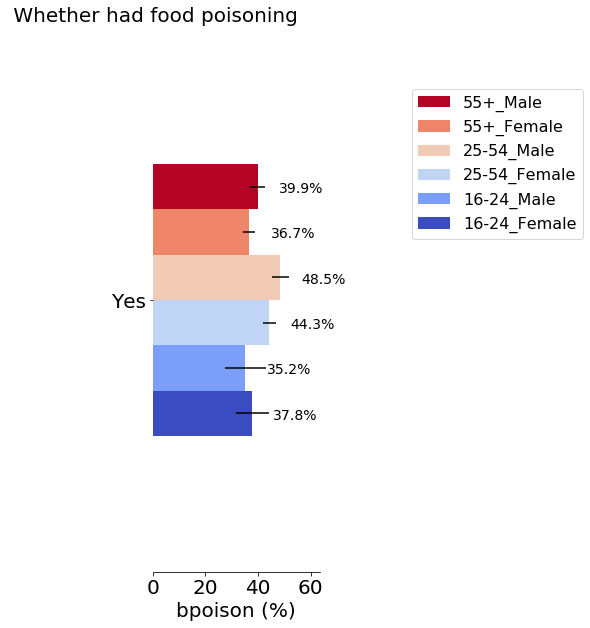

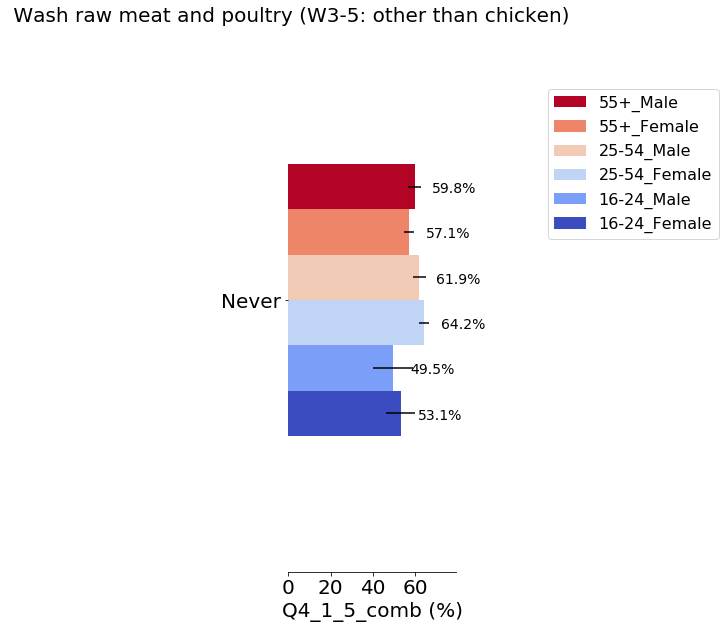

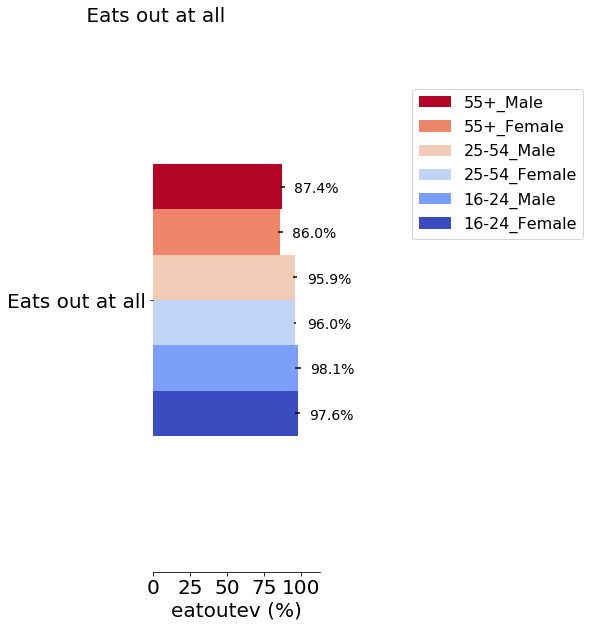

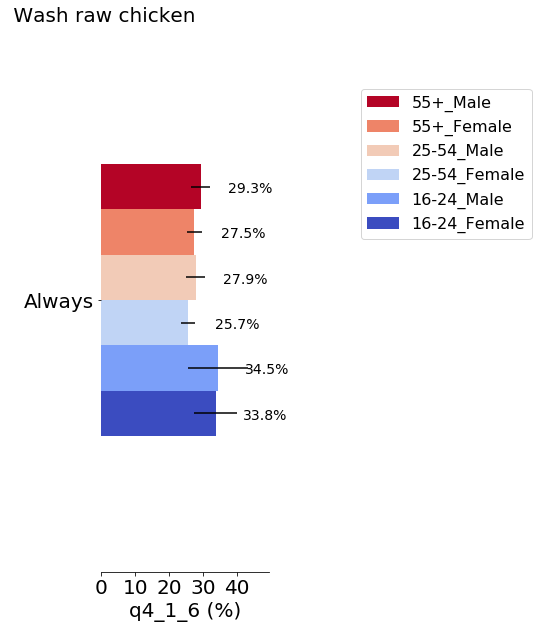

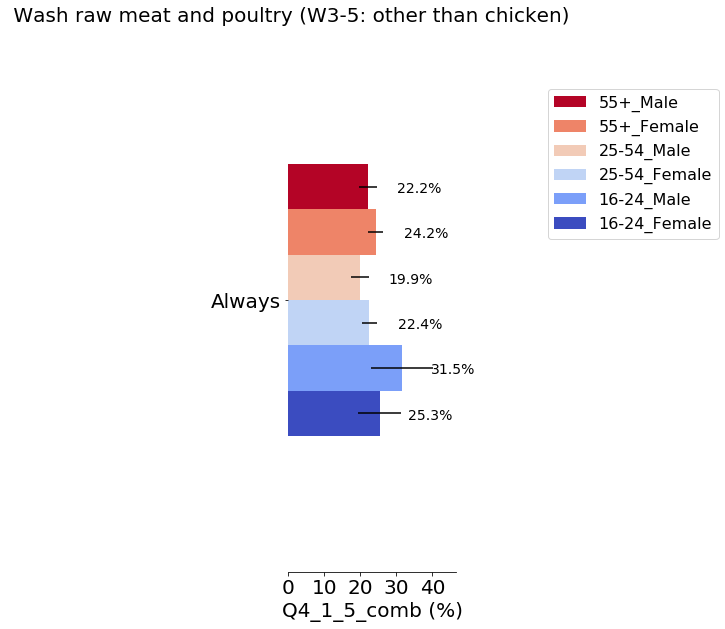

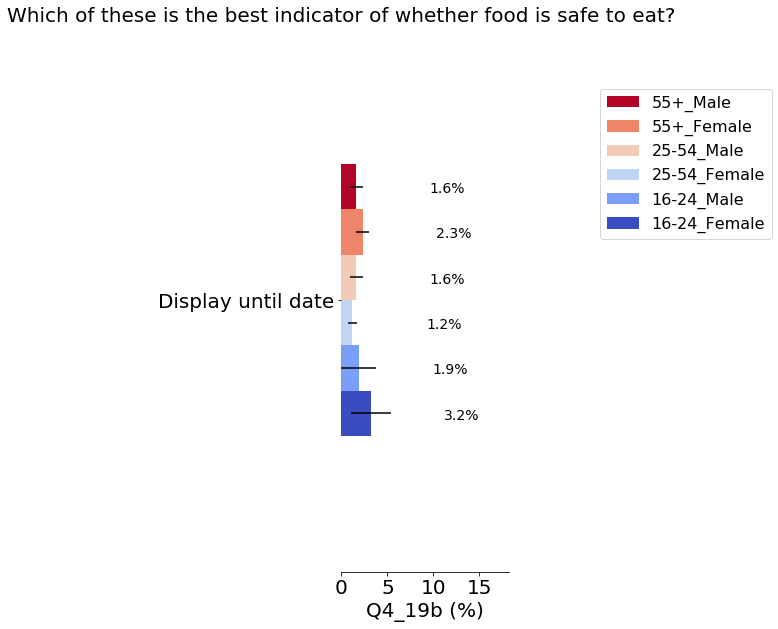

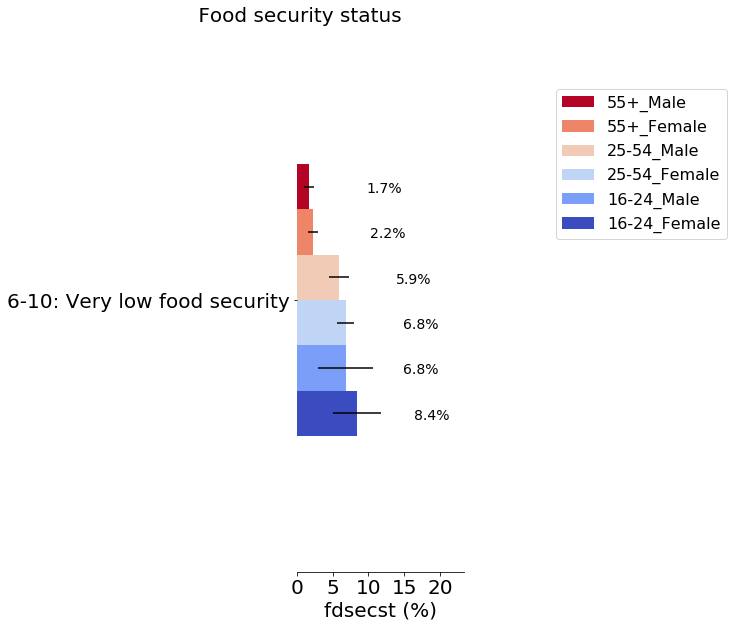

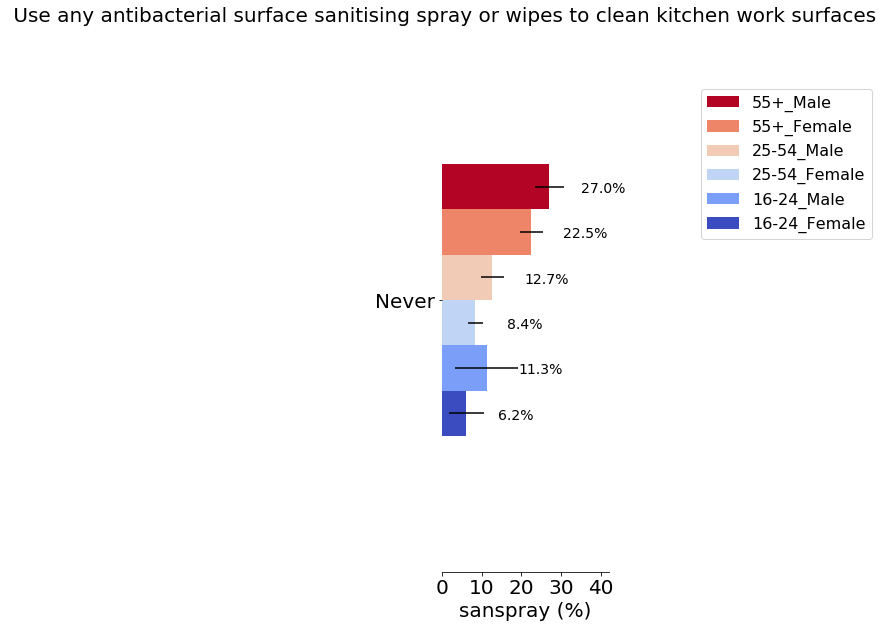

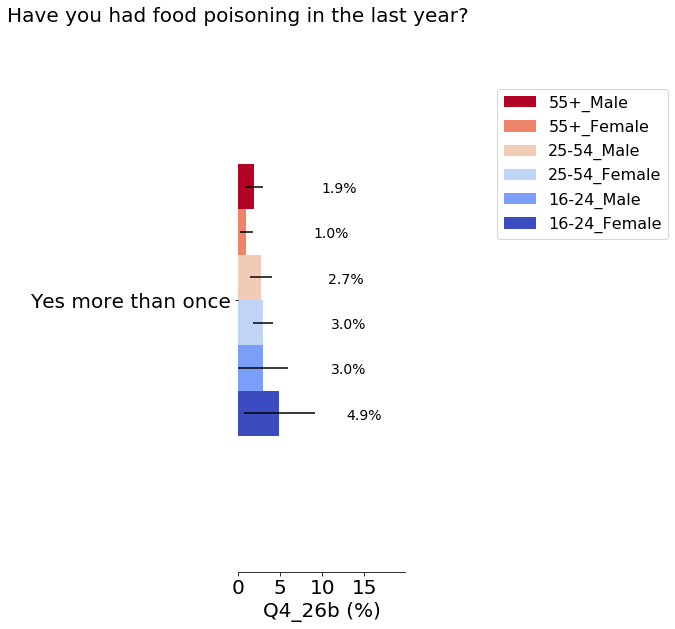

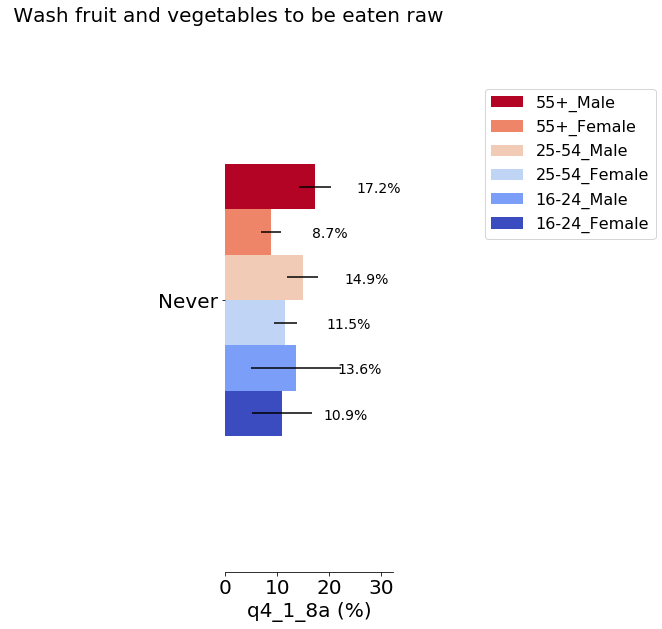

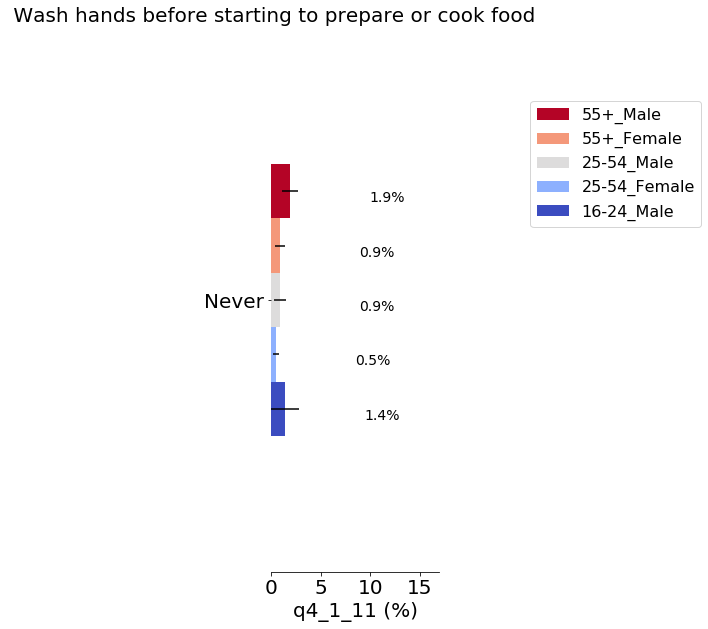

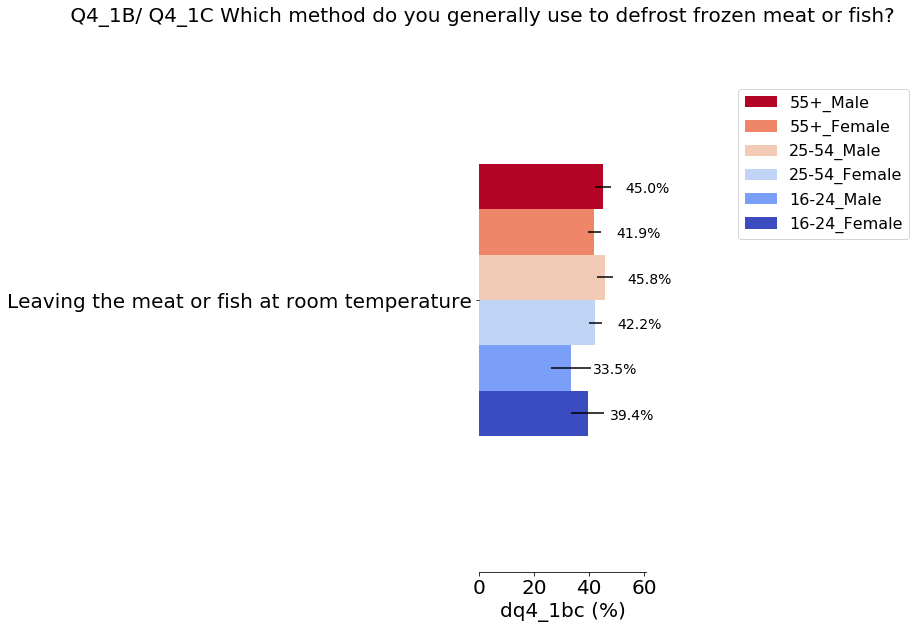

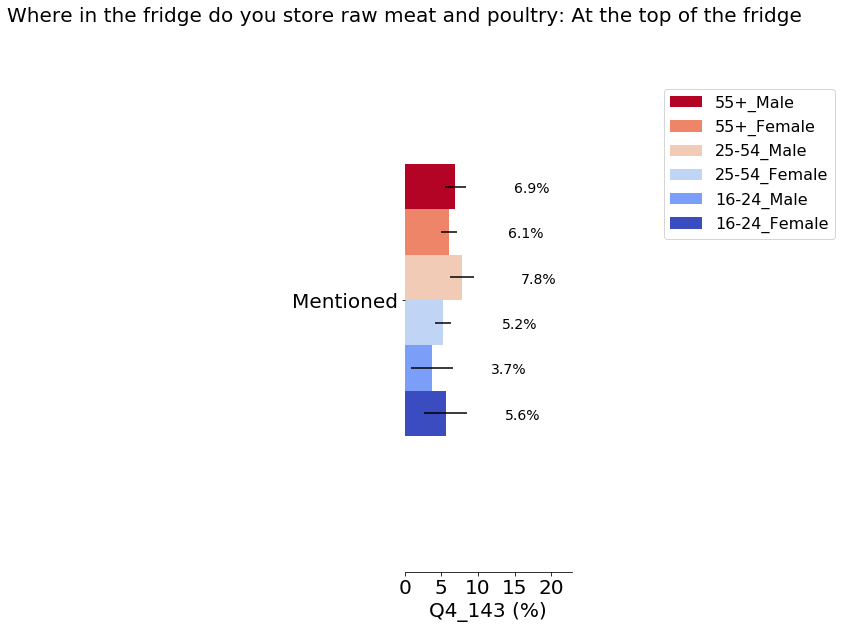

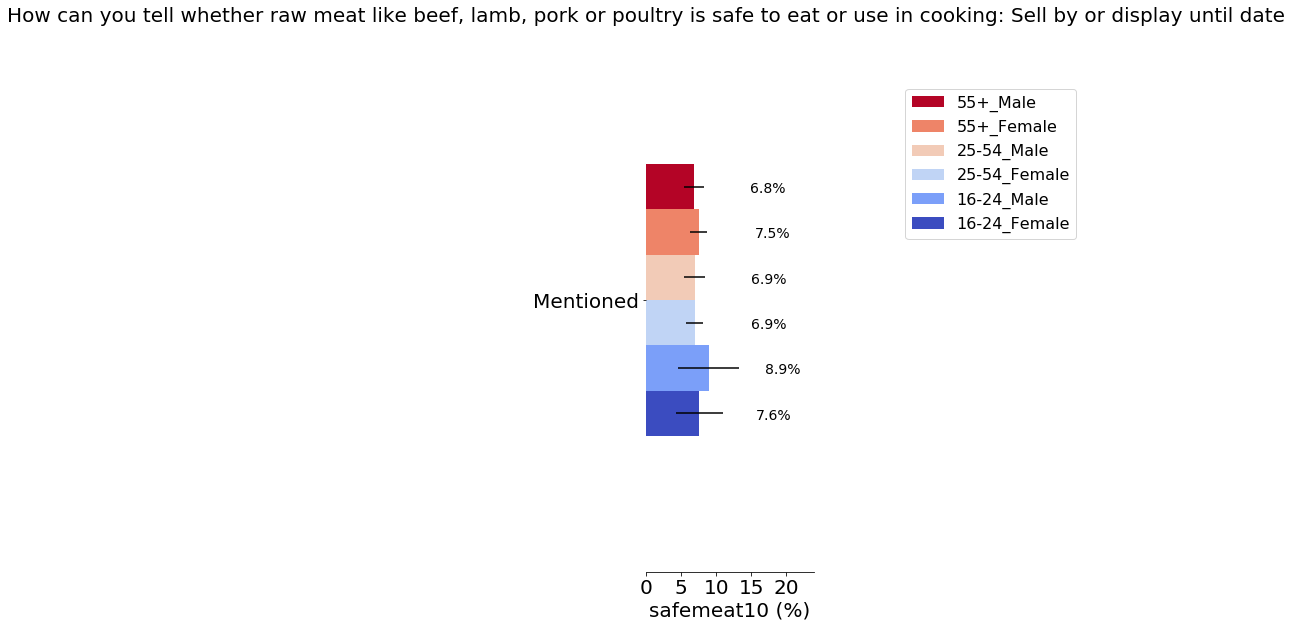

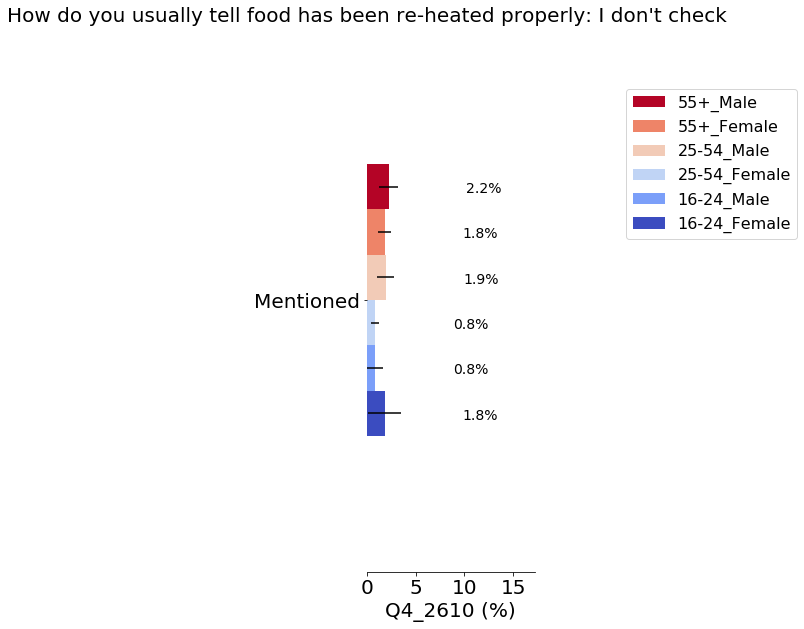

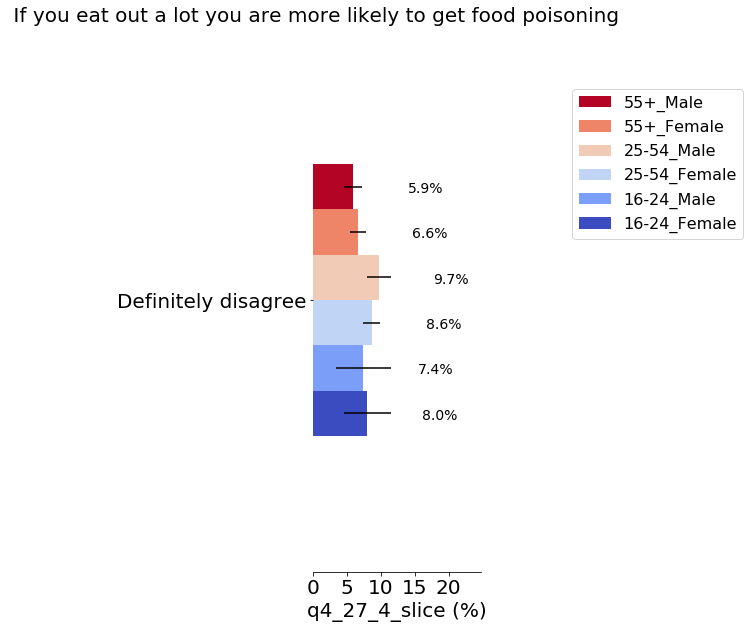

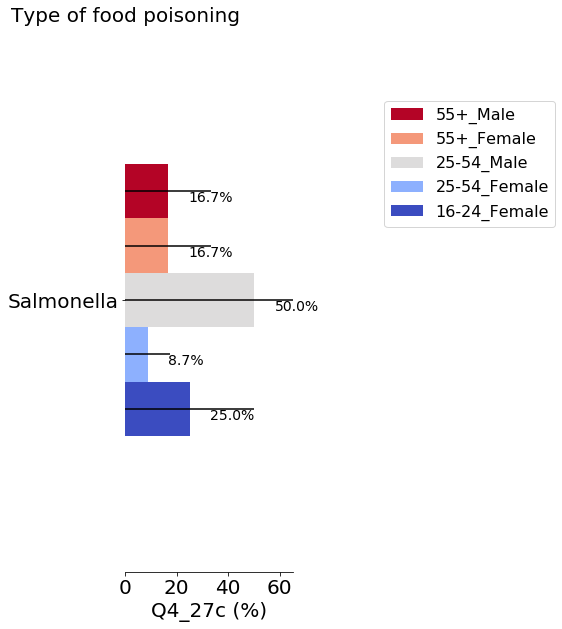

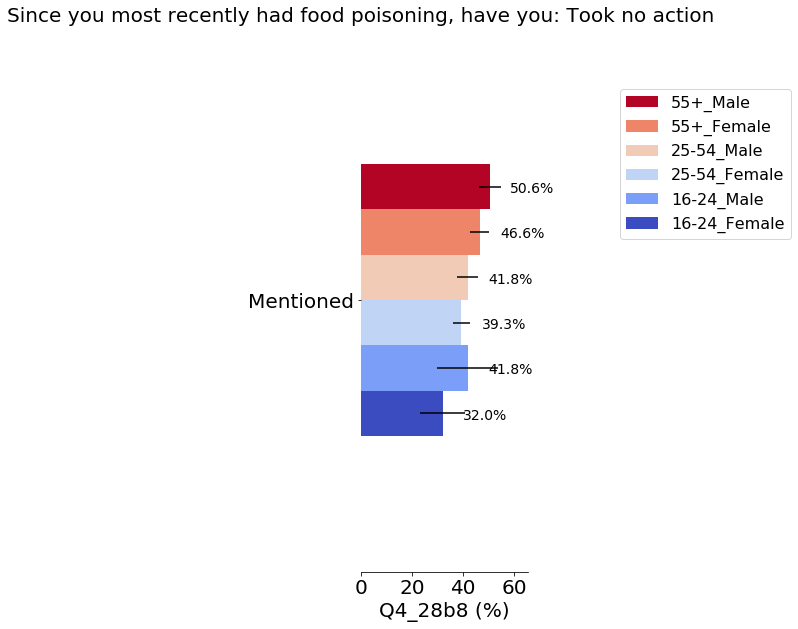

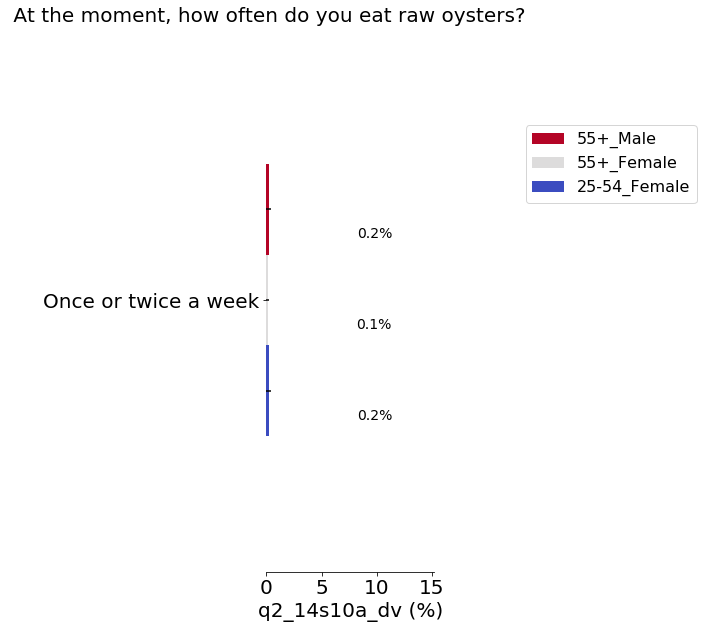

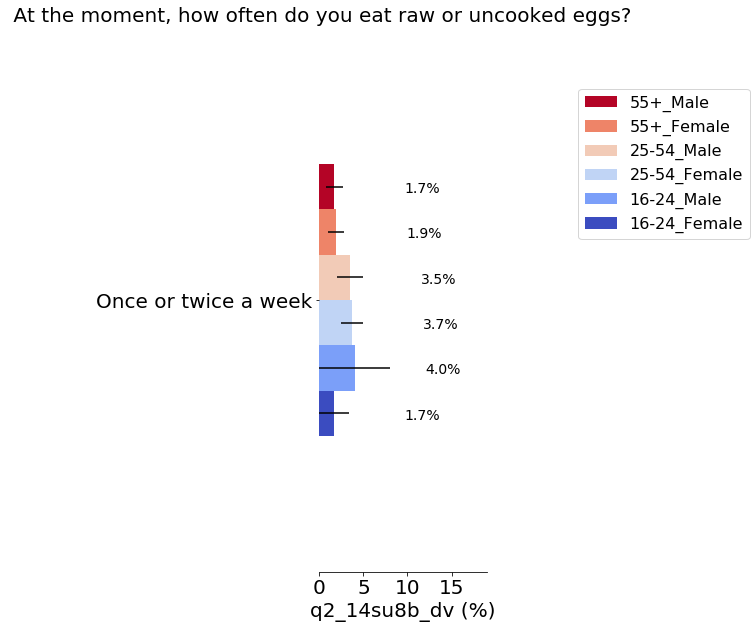

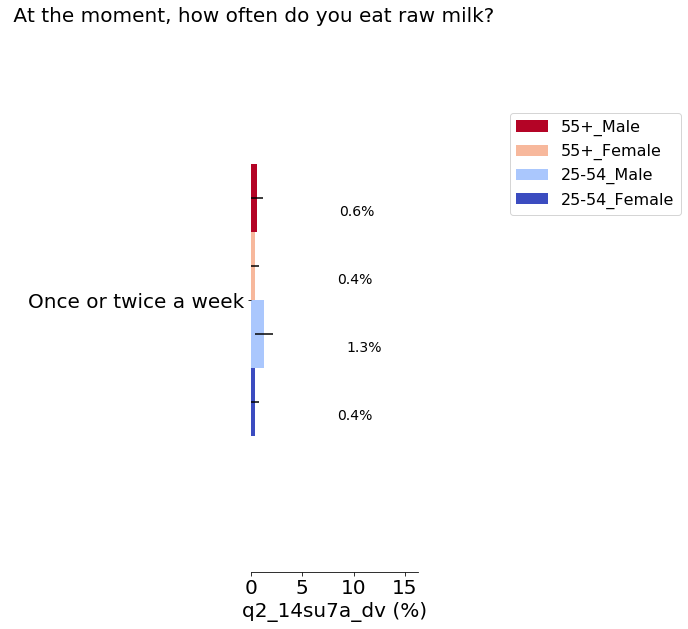

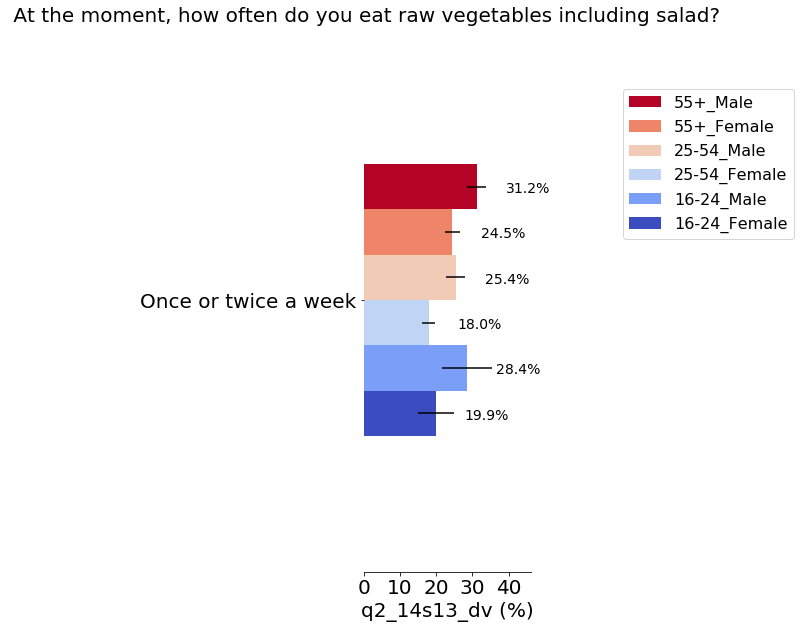

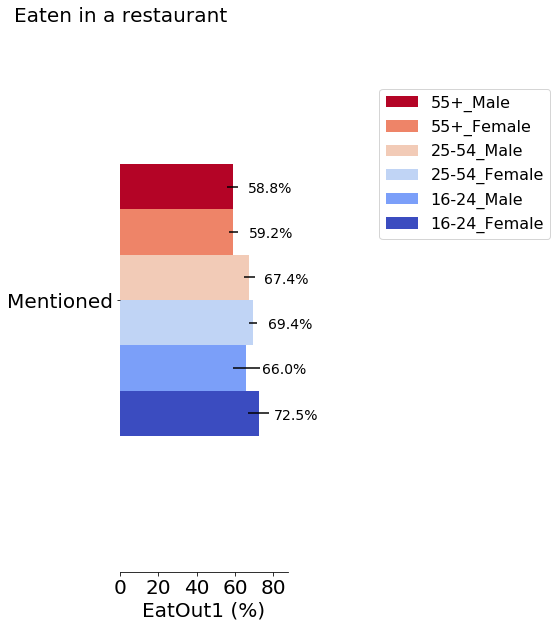

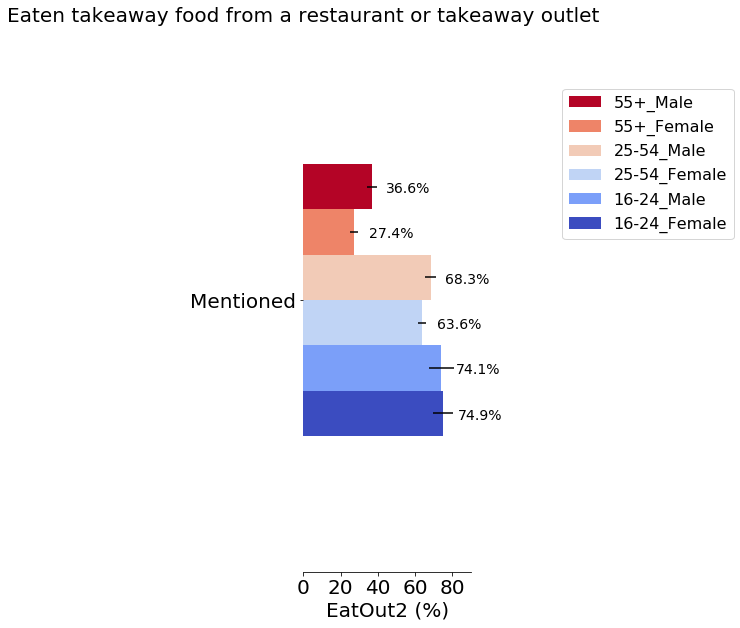

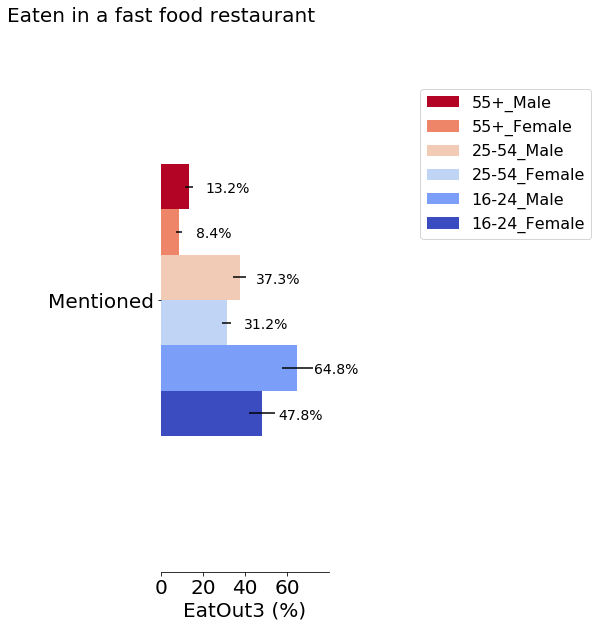

In [18]:
#Plot food risks associated to desired subpopulation groups for specified relevant questions
custom_barplots(survey_subpopulation,
                'combined_demographics',
                questions_of_interest_withRiskRating,
                'foodBehaviour_highRisk_byDemographics.pdf',
                myspacingy=0.03, myspacingx=8, myfontsize=14,
                high_risk_option='yes')

# Interactive dashboard 


## To give access to voila dashboard remotely using github and binder:

- Set up a public github repo with all data files needed (as csv), jupyter notebook with widgets (in which all csv files are read using the raw URLs from github) and a requirements.txt (listing  all the modules needed to run the notebook).
- Use binder (https://mybinder.org) and specify the path of the jupypter notebook (using voila/render), indicate it is a URL path. After this, a long URL adress is generated within the mybinder set up box: copy this and save, as this is the safest way to share the app afterwards.
- The app will open in its own URL adress, which can also be shared, but tends to expired withing a few hours.
- In general, the loading of the app with either of the two URLs above can fail at times. Trying a different browser is recomended. If possible persist, process to generate the app again using https://mybinder.org, as this is a fairly easy and quick set up anyway.

## Dashboard can be executed within the jupyter notebook
- It appears below the cell with the execution code

## To show this as an independent (local) dashboard with Voila 
(https://github.com/voila-dashboards/voila):
Install in terminal by: conda install -c conda-forge voila
Start Voilà locally (cd in directory with this notebook) by running: voila Food-and-You-survey_risks.ipynb


## To give access to voila dashboard remotely using ngrok:

- See https://voila.readthedocs.io/en/stable/deploy.html#sharing-voila-applications-with-ngrok)
- Install ngrok: https://ngrok.com/download, unzip file and, if using macOS, move executable file to /usr/local/bin
- Start Voilà locally (cd in directory with this notebook) by running: voila Food-and-You-survey_risks.ipynb
- In a new terminal window, start ngrok by running: ngrok http 8866 (check local host number actually used by the dashboard of interest, as, if running voila multiple times, this number will change)
- Copy the link from the ngrok terminal window (link looks like https://8bb6fded.ngrok.io) and use or send link.

### Notes

- Website will take some time to load, as the jupyter noteook is running in the background.
- When using the ngrok link, the requests will be forwared to your local instance of Voilà.
- Census data is too heavy and cannot be ploted as a voila dashboard

### Plot food risks associated to desired subpopulation groups for specified relevant questions:


In [24]:
country_dict = answers_dict['country_dv']
country_list = list(survey_subpopulation.country_dv.unique())
country_list[:] = [country_dict.get(e,'') for e in country_list]
country_dict_inv = {v: k for k, v in country_dict.items()}

region_dict = answers_dict['region_dv']
region_list = list(survey_subpopulation.region_dv.unique())
region_list[:] = [region_dict.get(e,'') for e in region_list]
region_dict_inv = {v: k for k, v in region_dict.items()}

questions_of_interest_names = questions_of_interest.copy()
questions_of_interest_names[:] = [questions_dict.get(e,'') for e in questions_of_interest_names]
questions_dict_inv = {v: k for k, v in questions_dict.items()}

demographics_list = ['Not applicable', 'Age (in detail)', 'Age', 'Gender', 'Marital status', 'Working status',
                     'Religion', 'Health', 'Urban-Rural classification', 'Household size',
                     'Household income', 'Children under 6 in household', 'Children under 16 in household']

demographic_dict = {'Not applicable':'dummy', 'Age (in detail)':'age_dv', 'Age':'age_dv_grouped', 'Gender':'RespSex',
                    'Marital status':'marstat2', 'Working status':'workstat2', 'Religion':'religion_dv',
                    'Health':'Q6_1', 'Urban-Rural classification':'UrbanRuralInd',
                    'Household size':'bhhsize2', 'Household income':'hhdinc',
                    'Children under 6 in household':'below6', 'Children under 16 in household':'below16'}

### Visualize data for the whole UK

In [25]:
@interact
def plot(question=questions_of_interest_names,
         demographics1=demographics_list,
         demographics2=demographics_list,
         demographics3=demographics_list):
    
    survey_subpopulation['dummy']=''
    survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                   survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                   survey_subpopulation[demographic_dict.get(demographics3)])        
    custom_barplots(survey_subpopulation,
                    'combined_demographics',
                    [questions_dict_inv.get(question)],
                    myspacingy=0.03, myspacingx=15,
                    interactivity='yes', barwidth=0.9)

interactive(children=(Dropdown(description='question', options=(' Whether had food poisoning', ' Wash raw meat…

### Visualize data for each UK country

In [26]:
@interact
def plot(country=country_list,
         question=questions_of_interest_names,
         demographics1=demographics_list,
         demographics2=demographics_list,
         demographics3=demographics_list):
    
    survey_subpopulation['dummy']=''
    survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                   survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                   survey_subpopulation[demographic_dict.get(demographics3)])        
    custom_barplots(survey_subpopulation[survey_subpopulation.country_dv.eq(country_dict_inv.get(country))],
                    'combined_demographics',
                    [questions_dict_inv.get(question)],
                    myspacingy=0.03, myspacingx=15,
                    interactivity='yes', barwidth=0.9)

interactive(children=(Dropdown(description='country', options=('England', 'Wales', 'Northern Ireland'), value=…

### Visualize data for each UK region

In [27]:
@interact
def plot(region=region_list,
         question=questions_of_interest_names,
         demographics1=demographics_list,
         demographics2=demographics_list,
         demographics3=demographics_list):
    
    survey_subpopulation['dummy']=''
    survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                   survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                   survey_subpopulation[demographic_dict.get(demographics3)])        
    custom_barplots(survey_subpopulation[survey_subpopulation.region_dv.eq(region_dict_inv.get(region))],
                    'combined_demographics',
                    [questions_dict_inv.get(question)],
                    myspacingy=0.03, myspacingx=15,
                    interactivity='yes', barwidth=0.9)

interactive(children=(Dropdown(description='region', options=('South West', 'South East', 'Wales', 'Yorkshire …

# Principal Component Analysis 

This script is adapted from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

Code performs PCA on the data from the FSA Food and You survey after some label columns (variables) are dropped that are not appropriate (e.g. serial number)
Then it plots PC1 against PC2 with a number demographic labels e.g gender. 

To note that missing values are included!

[0.33464034 0.12367991]


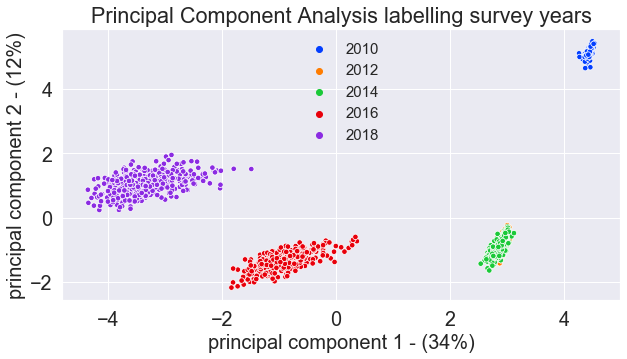

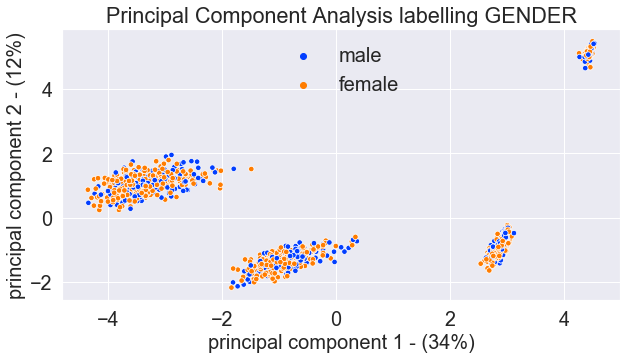

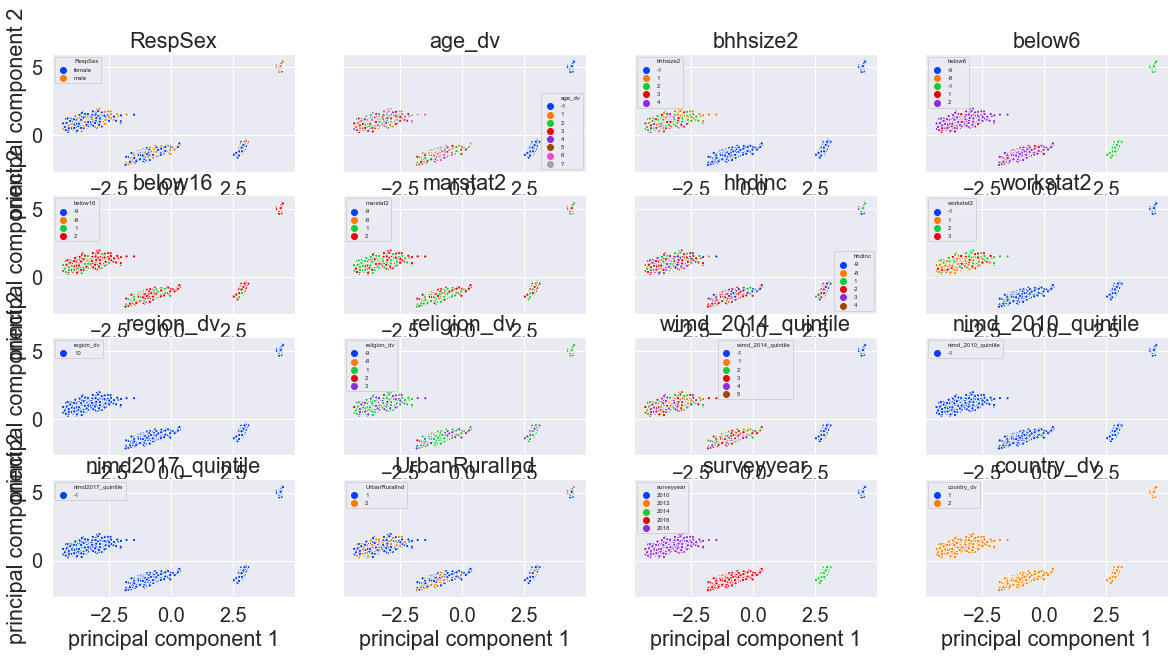

In [15]:
sns.set(style="ticks")
sns.set(font_scale=1.8)
from matplotlib import colors as mcolors


# import data to include all raw values (including missing values)

survey_full_dataset_pca = pd.read_csv(survey_path)
survey_full_dataset_pca = pd.DataFrame(survey_full_dataset_pca)

#survey_full_dataset = pd.DataFrame(survey_full_dataset)
df = survey_full_dataset_pca
# select wales only entries
df_wales = df.loc[df['region_dv'] == 10]
# get rid of all columns that are labels and so their values should not be included in the PCA transformation 
df_wales_drop = df_wales.drop([  'SerialNo'
                                ,'RespSex'
                                ,'age_dv'
                                ,'bhhsize2'
                                ,'below6'
                                ,'below16'
                                ,'marstat2'
                                ,'hhdinc'
                                ,'workstat2'
                                ,'region_dv'
                                ,'religion_dv'
                                ,'wimd_2014_quintile'
                                ,'nimd_2010_quintile'
                                ,'nimd2017_quintile'
                                ,'UrbanRuralInd'
                                ,'surveyyear'
                                ,'country_dv'
                                ,'psu_dv'
                                ,'stratum_all_dv'
                                ,'combinedW1_5weight'
                                ,'countryW1_5weight'],1)

# normalise the features    
df_wales_drop_norm = MinMaxScaler().fit_transform(df_wales_drop) 

# running the PCA 
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_wales_drop_norm)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2']) 

# list which is the explained variance in the PCs
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
# create a labels columns (i.e. gender) for new PCA dataframe 
label_columns = [
                    'RespSex'
                    ,'age_dv'
                    ,'bhhsize2'
                    ,'below6'
                    ,'below16'
                    ,'marstat2'
                    ,'hhdinc'
                    ,'workstat2'
                    ,'region_dv'
                    ,'religion_dv'
                    ,'wimd_2014_quintile'
                    ,'nimd_2010_quintile'
                    ,'nimd2017_quintile'
                    ,'UrbanRuralInd'
                    ,'surveyyear'
                    ,'country_dv'
                    ,'psu_dv']

# create a dataframe from the labels to concatenate to the PC dataframe 
to_concate =  df_wales[label_columns]
#  . . and then concatenate the labels column (i.e. gender) to the transformed data
finalDf = pd.concat([principalDf.reset_index(drop=True), to_concate.reset_index(drop=True)], axis = 1)

# this is the plot labeling SURVEY YEAR
finalDf = finalDf.replace({'surveyyear': {1: '2010', 2: '2012', 3: '2014', 4: '2016', 5: '2018'}})
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='principal component 1', y='principal component 2', 
                data=finalDf, hue='surveyyear'
                                  , palette='bright', s=30)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', frameon=False,  fontsize=15)
# plt.legend(loc='best', frameon=False,  fontsize=15)
plt.xlabel('principal component 1 - (34%)', fontsize=20)
plt.ylabel('principal component 2 - (12%)', fontsize=20)
plt.title('Principal Component Analysis labelling survey years')
fig.savefig('PCA_survey-year.pdf', format = 'pdf')

# this is the plot labeling GENDER
finalDf = finalDf.replace({'RespSex': {1: 'male', 2: 'female'}})
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x='principal component 1', y='principal component 2', 
                data=finalDf, hue='RespSex' , hue_order = ['male', 'female']
                                  , palette='bright', s=30)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', frameon=False,  fontsize=20)
plt.xlabel('principal component 1 - (34%)', fontsize=20)
plt.ylabel('principal component 2 - (12%)', fontsize=20)
plt.title('Principal Component Analysis labelling GENDER')
fig.savefig('PCA_gender.pdf', format = 'pdf')

# Plot ALL labels in a subplot grid plot  
row,col = 1,2
fig, ax = plt.subplots(4,4, figsize=(20,10), sharey=True)
plt.rc('legend', fontsize=6)
ax = ax.flatten()
for i, l in enumerate(label_columns[:-1]):
    sns.scatterplot(x='principal component 1', y='principal component 2', data=finalDf, hue=l
                              , palette='bright', s=10, ax=ax[i])
    ax[i].title.set_text(l)

# Statistical analysis

Chi-square testing for non-parametric data

## Computing statistical significance tests
chi2 and post hoc tests comparing census with F&Y data \
Gives a chi2 value for every combination of answer category for a question \
Functions from: https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/

In [24]:
#Read in relevant data from F&Y and census
data = demographics_survey_and_census

#define Chi2 with post hoc tests functions
def get_asterisks_for_pval(p_val):
    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    return p_text

def chisq_and_posthoc_corrected(df):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction)"""
    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi2_contingency(df, correction=True)
    print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")
    # post-hoc
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    p_vals = []
    print("Significance results:")
    for comb in all_combinations:
        new_df = df[(df.index == comb[0]) | (df.index == comb[1])]
        chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
        p_vals.append(p)
        # print(f"For {comb}: {p}")  # uncorrected
    # checking significance
    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
        print(f"{comb}: p_value: {p_val:5f}; corrected: {corr_p_val:5f} ({get_asterisks_for_pval(p_val)}) reject: {reject}")
# menu of demographic variables 
# demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 'wimd_2014_quintile', 'workstat2', 'Q6_1']
#construct table: choose feature of interest here
df = pd.crosstab(data.age_dv, data.source)
chisq_and_posthoc_corrected(df)

Chi2 result of the contingency table: 143.90145060241585, p-value: 1.5042078967416738e-28
Significance results:
('16-24', '25-34'): p_value: 0.000000; corrected: 0.000000 (****) reject: True
('16-24', '35-44'): p_value: 0.000000; corrected: 0.000000 (****) reject: True
('16-24', '45-54'): p_value: 0.000000; corrected: 0.000000 (****) reject: True
('16-24', '55-64'): p_value: 0.000000; corrected: 0.000000 (****) reject: True
('16-24', '65-74'): p_value: 0.000000; corrected: 0.000000 (****) reject: True
('16-24', '75+'): p_value: 0.000000; corrected: 0.000000 (****) reject: True
('25-34', '35-44'): p_value: 0.872185; corrected: 0.963994 (ns) reject: False
('25-34', '45-54'): p_value: 0.920693; corrected: 0.966728 (ns) reject: False
('25-34', '55-64'): p_value: 0.029889; corrected: 0.036922 (*) reject: True
('25-34', '65-74'): p_value: 0.000002; corrected: 0.000003 (****) reject: True
('25-34', '75+'): p_value: 0.000001; corrected: 0.000001 (****) reject: True
('35-44', '45-54'): p_value:

## Optional: calculate bootstrapped confidence intervals

In [25]:
# on specific F&Y wave, region and variable
import statsmodels.stats.api as sms
import scipy.stats as st
from scipy.stats import sem, t


#Read in data from F&Y and deal with null values
data = pd.read_csv(survey_path)
data = pd.DataFrame(data)

# remove missing data
data = data.replace([-9, -8, -1, 98], np.nan)
cols = ['q4_1_4', 'q4_1_5a', 'Q4_1_5_comb', 'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_8b', 'sanspray', 'q4_1_11',
        'q4_1_12', 'q4_1_13', 'q4_1_14', 'q4_1_15', 'q4_1_16', 'q4_1_17', 'q4_1_18', 'q4_1_19']
data[cols] = data[cols].replace([5], np.nan)

# Select region (Wales = 10)
data = data[data.region_dv.eq(10)]
# Select Wave 1-5
data = data[data.surveyyear.eq(5)]
# Main feture to be plotted
main_feature = 'religion_dv'
# Select data of interest for a particular plot
temp = data[[main_feature] + ['country_dv','surveyyear']]     
#Drop rows with nans
temp_nonan = temp.dropna(subset = [main_feature])
ans = temp_nonan[main_feature]

#calculate confidence intervals by several methods
#1
confidence = 0.95
n = len(temp_nonan[main_feature])
m = np.mean(temp_nonan[main_feature])
std_err = sem(temp_nonan[main_feature])
h = std_err * t.ppf((1 + confidence) / 2, n - 1)
start = m - h
end = m + h
#2
CI2 = sms.DescrStatsW(temp_nonan[main_feature]).tconfint_mean(alpha=0.05)
#3
CI3 = st.t.interval(0.95, len(temp_nonan[main_feature])-1, loc=np.mean(temp_nonan[main_feature]), scale=st.sem(temp_nonan[main_feature]))
print("CI1 =", start, end)
print("CI2 =", CI2)
print("CI3 =", CI3)

#bootstrap
R = 10000 #no. of bootstrapped samples
mean_all = []
for i in range(R):
    bs_sample = resample(temp_nonan[main_feature], replace=True, n_samples=len(temp_nonan), random_state=None)
    mean = np.mean(bs_sample)
    mean_all.append(mean)
#calculate sigma error from bootstrap
sig_err = np.std(mean_all)
two_sig_err = 2 * sig_err
print("1 sigma error = ", sig_err)
print("2 sigma error = ", two_sig_err)
print("Bootstrapped CI = ", np.mean(mean_all) - two_sig_err, np.mean(mean_all) + two_sig_err)

#Plot distributions
#plot example bootstrap sample
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
plt.hist(bs_sample, bins=40, edgecolor='w', linewidth=0.3, color='cornflowerblue', label='M1')
plt.xlabel('example sample', fontsize=20)
fig.tight_layout()
#plot mean distribution
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(1,1,1)
plt.hist(mean_all, bins=40, edgecolor='w', linewidth=0.3, color='cornflowerblue', label='M1')
plt.xlabel('mean', fontsize=20)
fig.tight_layout()
plt.show()

CI1 = 1.7772806087038113 1.9433897823576414
CI2 = (1.7772806087038113, 1.9433897823576414)
CI3 = (1.7772806087038113, 1.9433897823576414)


NameError: name 'resample' is not defined

## Ranking correlations


Create a correlation matrix for all F&Y variables.
Rank correlations in descending order.
View only correlations with a specific variable.

### Without data imputation

In [26]:
# Read in data from F&U
df = pd.read_csv(survey_path)
df = pd.DataFrame(df)

# #impute missing values if desired
# df = df.replace([-9, -8, -1, 98], np.nan)
# cols = ['q4_1_4', 'q4_1_5a', 'Q4_1_5_comb', 'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_8b', 'sanspray', 'q4_1_11',
#        'q4_1_12', 'q4_1_13', 'q4_1_14', 'q4_1_15', 'q4_1_16', 'q4_1_17', 'q4_1_18', 'q4_1_19']
# df[cols] = df[cols].replace([5], np.nan)

# Select Wales
df = df[df.region_dv.eq(10)]

# Select Wave 5
df = df[df.surveyyear.eq(5)]
print(df.shape)

#generate correlation matrix: choose Pearson, Spearman or Kendall tau
cor_mat = df.corr(method='spearman', min_periods=1).abs()

#sort correlations in descending order
s = cor_mat.unstack()
so = s.sort_values(ascending=False, kind="quicksort")

#Print all correlation with food poisoning question
print(so['bpoison'])

(540, 502)
bpoison       1.000000
Q4_28b3       0.980518
Q4_28b4       0.979129
Q4_28b2       0.975687
Q4_28b1       0.971965
                ...   
H2_406             NaN
H2_407             NaN
H2_408             NaN
H2_409             NaN
heardorgc8         NaN
Length: 502, dtype: float64


### With data imputation

In [17]:
waves = [5]
survey_subpopulation = survey_full_dataset.loc[survey_full_dataset['surveyyear'].isin(waves)] # only wave 5
survey_subpopulation = survey_subpopulation.drop(['age_dv_grouped'], axis=1) # Not numeric
survey_subpopulation = survey_subpopulation.dropna(axis=1, how='all') # Cannot be columns with all NaNs for imputation

imp = KNNImputer(n_neighbors=2, weights="uniform")
imputed = imp.fit_transform(survey_subpopulation)
imputed = pd.DataFrame(imputed)
imputed.columns = survey_subpopulation.columns

# Select features highly correlated with output variable

# Correlation  matrix between all variables
cor = imputed.corr(method='spearman')

# Correlation with chosen output variable specifically
cor_target = cor['bpoison']

# Select features highly correlated (absolute correlation greater than 0.1)
relevant_features = cor_target[abs(cor_target)>0.1]

relevant_features = relevant_features.sort_values(ascending=False) # This ouput could be saved as a separate file

relevant_features = pd.DataFrame(relevant_features)
relevant_features['features_names'] = relevant_features.index
relevant_features['features_names']  = relevant_features['features_names'].replace(questions_dict)
pd.set_option('max_colwidth', 1)
relevant_features

bpoison  \
bpoison         1.000000   
q4_276dv        0.152421   
q4_276_dv       0.143270   
fdreac_dv       0.138698   
reacno          0.135633   
q2_14s10_dv     0.129707   
FdAuthAct_MC9   0.116356   
Q4_28b5         0.106269   
q4_277dv        0.105957   
q2_14su5_dv     0.105662   
Q11_8bDV12     -0.103870   
Q2_35DV_Rv     -0.103882   
heardorgc1     -0.107029   
heardorgc3     -0.108013   
Q4_1b3         -0.110669   
heardorgc5     -0.111266   
EatOutInfDV_Wb -0.112271   
hhdinc         -0.112596   
EatOut1        -0.113612   
heardorgc4     -0.113779   
q4_278dv       -0.117352   
q4_1_15        -0.125766   
HeardFSA       -0.132182   
heardorgc6     -0.170787   

                                                                                                        features_names  
bpoison          Whether had food poisoning                                                                             
q4_276dv         I like trying new things to eat                                                                        
q4_276_dv        I like trying new things to eat - net agree/disagree                                                   
fdreac_dv        Suffer adverse reaction or avoid foods due to reaction                                                 
reacno          No reaction                                                                                             
q2_14s10_dv      At the moment, how often do you eat cooked shellfish?                                                  
FdAuthAct_MC9   Took no action                                                                                          
Q4_28b5         Since you most recently had food poisoning, have you: Stopped eating certain foods                      
q4_277dv         I enjoy cooking and preparing food                                                                     
q2_14su5_dv      At the moment, how often do you eat duck or goose?                                                     
Q11_8bDV12      Whether get information about how to prepare and cook food safely at home from: Internet search engine  
Q2_35DV_Rv      Recommendations or invitation from someone you know/good reviews                                        
heardorgc1      Whether heard of: Department of Health, now also known as Department of Health and Social Care (DHSC)   
heardorgc3      Whether heard of: Food Standards Agency (FSA)                                                           
Q4_1b3          Methods used to defrost frozen meat or fish: Leaving the meat or fish in the fridge                     
heardorgc5      Whether heard of: Department for Environment, Food and Rural Affairs (DEFRA)                            
EatOutInfDV_Wb  Customer reviews on websites or mobile apps e.g. TripAdvisor, Yelp, Google reviews etc.                 
hhdinc           Household income                                                                                       
EatOut1         Eaten in a restaurant                                                                                   
heardorgc4      Whether heard of: National Institute for Health and Care Excellence (NICE)                              
q4_278dv         I'm not generally interested in food                                                                   
q4_1_15          Eat red meat if the meat is pink or has pink or red juices                                             
HeardFSA        Had you heard of the Food Standards Agency before you were contacted to take part in this interview?    
heardorgc6      Whether heard of: OFCOM, Office of Communications

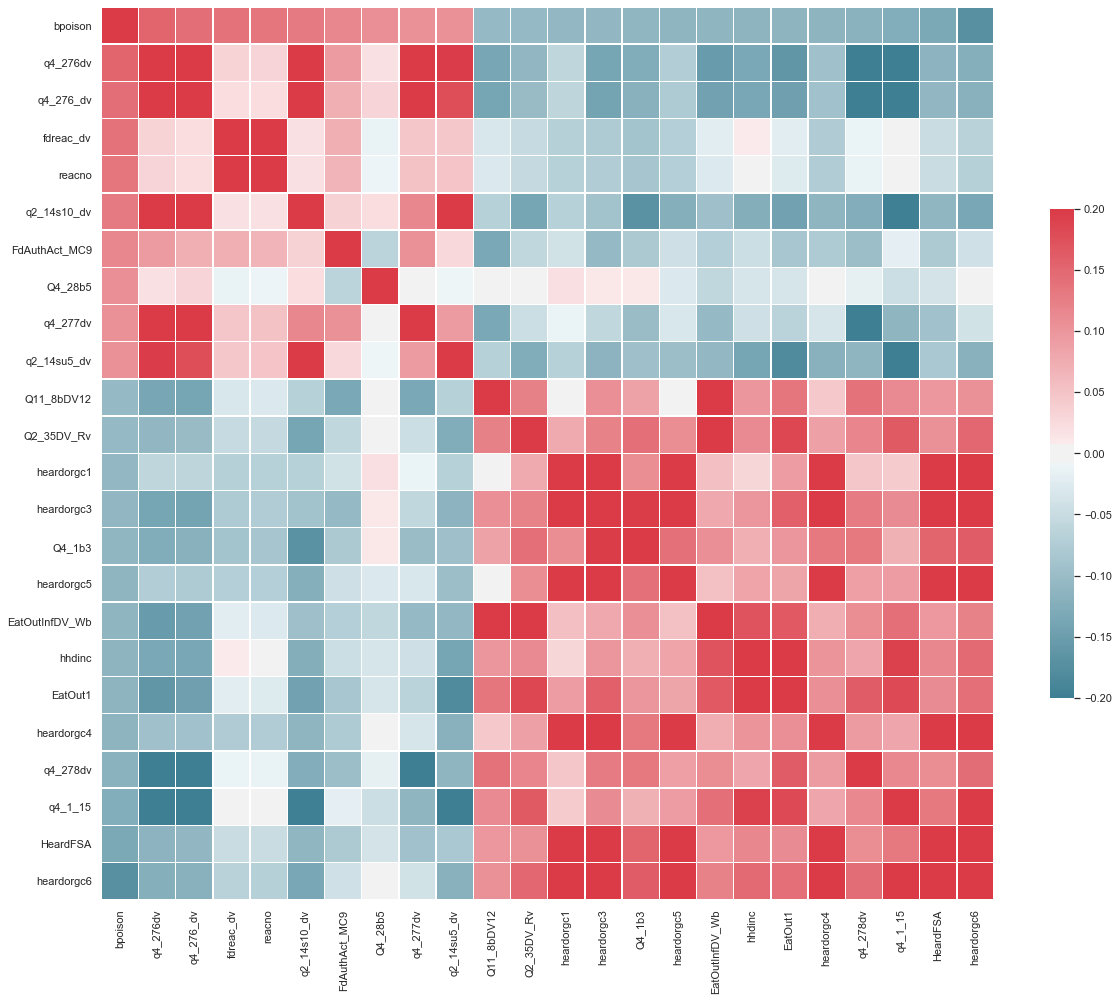

In [18]:
# Generate a plot showing correlation between features highly correlated with output variable

data_correlated_target = imputed[relevant_features.index]

# Correlation matrix between highly correlated variables
corr_matrix = data_correlated_target.corr(method='spearman') # Could also do this using data_wales_scaled

sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap=cmap, vmax=0.2, vmin=-0.2, center=0,
            xticklabels=True, yticklabels=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

f.savefig('heatmap_correlated_bpoison.pdf', format = 'pdf')

## Predictive model

In [56]:
regr = RandomForestRegressor(random_state=0) # max_depth=2,
regr.fit(imputed.drop(['bpoison'], axis=1), imputed['bpoison'])
RandomForestRegressor(random_state=0) # max_depth=2, 
len(regr.feature_importances_)

features_importance = pd.DataFrame(
    {'features': imputed.drop(['bpoison'], axis=1).columns,
     'importance': regr.feature_importances_
    })

features_importance = features_importance.sort_values(['importance'], ascending=False)

features_importance['features_names']  = features_importance['features'].replace(questions_dict)

features_importance.head(50)

features  importance  \
350  Q4_28b8             0.194843     
348  Q4_28b6             0.142805     
339  Q4_26b              0.075593     
347  Q4_28b5             0.062237     
0    SerialNo            0.008681     
19   combinedW1_5weight  0.007687     
17   psu_dv              0.007529     
20   countryW1_5weight   0.007397     
466  heardorgc6          0.007326     
343  Q4_28b1             0.006220     
18   stratum_all_dv      0.005293     
2    age_dv              0.005082     
443  H2_42               0.004760     
441  h2_28fb             0.004665     
396  h2_25_dv            0.004371     
322  q4_276dv            0.004302     
345  Q4_28b3             0.004077     
442  h2_28mb             0.004059     
438  h2_26b              0.004055     
344  Q4_28b2             0.004046     
303  Q4_24               0.003934     
374  chemiop2            0.003899     
391  dh2_11_12_13        0.003648     
49   q2_14su8a_dv        0.003645     
59   q2_14s16_dv         0.003636     
7    hhdinc              0.003614     
199  Q4_10               0.003613     
90   Q2_35DV_Rv          0.003595     
368  overallrp           0.003578     
58   q2_14s15_dv         0.003352     
398  h2_27_dv            0.003135     
499  FdAuthAct_MC9       0.003088     
349  Q4_28b7             0.002995     
475  C5                  0.002977     
376  chemiop4            0.002911     
390  H2_22               0.002866     
373  chemiop1            0.002851     
388  H2_20               0.002848     
198  Q4_9                0.002843     
437  h2_25b              0.002806     
440  h2_27mb             0.002766     
125  provfd2             0.002719     
471  C1                  0.002717     
56   q2_14s14_dv         0.002596     
155  SprayWipe           0.002595     
207  Q4_12               0.002593     
294  Q4_22               0.002574     
444  H2_43               0.002561     
399  h2_28_dv            0.002559     
395  h2_24_dv            0.002547     

                                                                                                                                                                                                   features_names  
350  Since you most recently had food poisoning, have you: Took no action                                                                                                                                          
348  Since you most recently had food poisoning, have you: Stopped eating at certain food establishments (e.g. restaurants/cafes)                                                                                  
339  Have you had food poisoning in the last year?                                                                                                                                                                 
347  Since you most recently had food poisoning, have you: Stopped eating certain foods                                                                                                                            
0    Serial Number                                                                                                                                                                                                 
19    Combined all countries calibration weight core+boost+extra (scaled to countries %)                                                                                                                           
17   primary sample unit                                                                                                                                                                                           
20    Combined all countries calibration weight core+boost+extra                                                                                                                                                   
466  Whether heard of: OFCOM, Office of Communications                                                               